# Benchmarking Geral

* `Objetivo:` Avaliar a classificação de séries temporais usando 3 diferentes abordagens, incluindo nossa hipótese, de codificar séries temporais através do Gráfico de Recorrência;

* `Cenário Comparativo`: 
    - <u>Dados:</u> Considerando os dados estabelecidos no *Benchmarking 1*;
        * *Detalhes:* Base REDD, baixa Frequência, Resid. 3, com 9 aparelhos (4k amostras treino/4k teste);
        * *Amostras:* Blocos de 5 minutos (300 segundos - 100 unidade, dado delay *3s*) de cada medição;
    
    - <u>Atributos *(Feature Space)*:</u> representação vetorial das amostras;
        1. **Abordagem Estatística (Benchmarking 1)**: Média, Desvio Padrão, Máximo, Energia Total, Hora do Dia e Temperatura Ambiente (zerado, neste caso, pois não foi disponibilizado pelos autores); 
        2. **Abordagem GAF (Benchmarking 2)**: Representação visual da amostra, através do algoritmo *Wang and Oates’[20]/Gramian Angular Field Matrices (GAF)*, e subsequente *embedding* com uma Rede Neural com arquitetura VGG16;
        3. **Abordagem RP (Hipótese 1)**: Nossa hipótese, converter a amostra em uma representação visual com a técnica de Gráfico de Recorrência (RP, do inglês *Recurrence Plot*); seguindo o *Benchmarking 2*, é realizado o *embedding* da imagem resultante com uma Rede Neural com arquitetura VGG16.
        4. **Abordagem RP+RQA (Hipótese 2)**: A partir do RP, extrair métricas de RQA, as quais alimentarão o classificador de cargas.
        
    - <u>Método de Classificação:</u> Rede Neural Multi-camadas (MLP, sem hiperparametrização - pacote [Scikit-lean](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier));
    
    - <u>Métrica(s):</u> uma vez que o problema irá ser tratado como classificação multi-rótulo, irão ser adotadas as seguintes métricas (via pacote [Scikit-learn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html))
        * Classificaton Report, contendo:
            * Acurácia;
            * Precisão;
            * Recall;
            * F1-score;
            * Hamming Loss;
            * Suporte (0/1);
        * Matriz de confusão.

# Configurando ambiente e parâmetros

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rc('text', usetex=False)
from matplotlib.image import imsave
import pandas as pd
import pickle as cPickle
import os, sys, cv2
from math import *
from pprint import pprint
from tqdm import tqdm_notebook
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from glob import glob
from IPython.display import display

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, hamming_loss, auc, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *

from pyts.image import RecurrencePlot, GramianAngularField

REDD_RESOURCES_PATH = 'datasets/REDD'

BENCHMARKING1_RESOURCES_PATH = 'benchmarkings/cs446 project-electric-load-identification-using-machine-learning/'
BENCHMARKING2_RESOURCES_PATH = 'benchmarkings/Imaging-NILM-time-series/'
HYPOTHESIS_RESOURCES_PATH = 'datasets/hipotese1-recurrenceplot-vggembedding/'

sys.path.append(os.path.join(BENCHMARKING1_RESOURCES_PATH, ''))
sys.path.append(os.path.join(BENCHMARKING2_RESOURCES_PATH, ''))
sys.path.append(os.path.join(HYPOTHESIS_RESOURCES_PATH, ''))

from serie2QMlib import *

import warnings
warnings.filterwarnings(action='ignore')

# Carregando os dados

In [5]:
# devices to be used in training and testing
use_idx = np.array([3,4,6,7,10,11,13,17,19])

label_columns_idx = ["APLIANCE_{}".format(i) for i in use_idx]

appliance_labels = [
    "Electronics", 
    "Refrigerator", 
    "Dishwasher",
    "Furnace", 
    "Washer Dryer 1", 
    "Washer Dryer 2", 
    "Microwave", 
    "Bathroom GFI",
    "Kitchen Outlets"
]

# Select some appliances for paper
valid_appliances = [
    "Refrigerator", "Dishwasher", "Furnace", "Wash Dryer 1", "Microwave"
]
valid_appliances_index = [
    1, 2, 3, 4, 6
]
#np.array(appliance_labels)[valid_appliances_index])

## Informações Estatísticas (Bench. 1)

In [10]:
Xb1_train = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/train_instances.npy') )
yb1_train = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/train_labels_binary.npy') )

Xb1_test = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/test_instances.npy') )
yb1_test = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/test_labels_binary.npy') )

In [11]:
# Select appliances for paper
yb1_train = yb1_train[:, valid_appliances_index]
yb1_test = yb1_test[:, valid_appliances_index]

## Imagens GAF (Bench. 2)

In [18]:
Xb2_train = np.load( os.path.join(BENCHMARKING2_RESOURCES_PATH, 'datasets/X_train.npy') )
yb2_train = np.load( os.path.join(BENCHMARKING2_RESOURCES_PATH, 'datasets/y_train.npy') )

Xb2_test = np.load( os.path.join(BENCHMARKING2_RESOURCES_PATH, 'datasets/X_test.npy') )
yb2_test = np.load( os.path.join(BENCHMARKING2_RESOURCES_PATH, 'datasets/y_test.npy') )

In [19]:
# Select appliances for paper
yb2_train = yb2_train[:, valid_appliances_index]
yb2_test = yb2_test[:, valid_appliances_index]

## Gráficos de Recorrência (Hipótese 1)

In [21]:
Xh1_train = np.load( os.path.join(HYPOTHESIS_RESOURCES_PATH, 'X_train.npy') )
yh1_train = np.load( os.path.join(HYPOTHESIS_RESOURCES_PATH, 'y_train.npy') )

Xh1_test = np.load( os.path.join(HYPOTHESIS_RESOURCES_PATH, 'X_test.npy') )
yh1_test = np.load( os.path.join(HYPOTHESIS_RESOURCES_PATH, 'y_test.npy') )

In [22]:
# Select appliances for paper
yh1_train = yh1_train[:, valid_appliances_index]
yh1_test = yh1_test[:, valid_appliances_index]

## RP+RQA (Hipótese 2)

In [23]:
""" 
References:
    - https://contentlab.io/using-rqa-and-neural-networks-to-analyze-complex-time-series/
    - https://github.com/JuliaDynamics/RecurrenceAnalysis.jl/wiki/Comparison-of-software-packages-for-RQA
    - PyRQA
    - https://stackoverflow.com/questions/43077427/python-pyopencl-import-error
"""

# # Erro: 
#     RuntimeError: clGetDeviceInfo failed: OUT_OF_RESOURCES
# # Solução: 
#     1. Adicionar o comando 'if self.verbose:' em ~\anaconda3\envs\doutorado\lib\site-packages\pyrqa\opencl.py na linha 262
#     2. Implementar try_or function em ~\anaconda3\envs\doutorado\lib\site-packages\pyrqa\opencl.py e alterar linha 510-511 (função get_device_info)
#         def try_or(fn, default):
#             try:
#                 return fn()
#             except:
#                 return default
#    
#         import pyopencl as cl  # Import the OpenCL GPU computing API
#         print('\n' + '=' * 60 + '\nOpenCL Platforms and Devices')
#         for platform in cl.get_platforms():  # Print each platform on this computer
#             print('=' * 60)
#             print('Platform - Name:  ' + platform.name)
#             print('Platform - Vendor:  ' + platform.vendor)
#             print('Platform - Version:  ' + platform.version)
#             print('Platform - Profile:  ' + platform.profile)
#             for device in platform.get_devices():  # Print each device per-platform
#                 print('    ' + '-' * 56)
#                 print('    Device - Name:  ' + device.name)
#                 print('    Device - Type:  ' + cl.device_type.to_string(device.type))
#                 #print('    Device - Max Clock Speed:  {0} Mhz'.format(device.max_clock_frequency))
#                 print('    Device - Max Clock Speed:  {0} Mhz'.format( try_or(lambda: device.max_clock_frequency, '<n/a>') ) )
#                 print('    Device - Compute Units:  {0}'.format(device.max_compute_units))
#                 print('    Device - Local Memory:  {0:.0f} KB'.format(device.local_mem_size/1024))
#                 print('    Device - Constant Memory:  {0:.0f} KB'.format(device.max_constant_buffer_size/1024))
#                 print('    Device - Global Memory: {0:.0f} GB'.format(device.global_mem_size/1073741824.0))
#         print('\n')

' \nReferences:\n    - https://contentlab.io/using-rqa-and-neural-networks-to-analyze-complex-time-series/\n    - https://github.com/JuliaDynamics/RecurrenceAnalysis.jl/wiki/Comparison-of-software-packages-for-RQA\n    - PyRQA\n    - https://stackoverflow.com/questions/43077427/python-pyopencl-import-error\n'

In [24]:
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.computing_type import ComputingType
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation

def calculate_rqa(series, result_format = 'pandas'):
    rqa_data = []
    for serie in tqdm_notebook(series):
        settings = Settings(
            TimeSeries(
                serie, 
                embedding_dimension=1, time_delay=1 # Same series from PyTS package used in our hypothesis (https://pyts.readthedocs.io/en/latest/generated/pyts.image.RecurrencePlot.html#pyts.image.RecurrencePlot)
            ), # Performing RP conversions from TS
            computing_type=ComputingType.Classic,
            neighbourhood=FixedRadius(0.65),
            similarity_measure=EuclideanMetric,
            theiler_corrector=1
        )
        rqa_result = RQAComputation.create(settings,verbose=False).run()
        rqa_data.append(rqa_result.to_array()[3:])
        
    if result_format == 'pandas':
        return pd.DataFrame(
            data = rqa_data, 
            columns =  [
                "Recurrence rate (RR)",
                "Determinism (DET)", 
                "Average diagonal line length (L)",
                "Longest diagonal line length (L_max)",
                "Divergence (DIV)",
                "Entropy diagonal lines (L_entr)",
                "Laminarity (LAM)",
                "Trapping time (TT)",
                "Longest vertical line length (V_max)",
                "Entropy vertical lines (V_entr)",
                "Average white vertical line length (W)",
                "Longest white vertical line length (W_max)",
                "Longest white vertical line length inverse (W_div)",
                "Entropy white vertical lines (W_entr)",
                "Ratio determinism / recurrence rate (DET/RR)",
                "Ratio laminarity / determinism (LAM/DET)"
            ]
        )
    else:
        return rqa_data
    
# # Testing RQA calc...
# data_points = [
#     [0.1, 0.5, 1.3, 0.7, 0.8, 1.4, 1.6, 1.2, 0.4, 1.1, 0.8, 0.2, 1.3],
#     [1.6, 1.2, 0.4, 1.1, 0.8, 0.2, 1.3, 0.1, 0.5, 1.3, 0.7, 0.8, 1.4]
# ]
# rqa_series = calculate_rqa(data_points)
# rqa_series

In [26]:
print("Calculating RQA from chunked series dataset (train / test)...")

# Train...
path_train = os.path.join(HYPOTHESIS_RESOURCES_PATH, 'df_rqa_train.csv') 
if not os.path.exists(path_train):
    Xh2_train = calculate_rqa(
        np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/train_power_chunks.npy') )
    ).replace([np.inf, -np.inf], np.nan).fillna(0)
    Xh2_train.to_csv( path_train )
else:
    Xh2_train = pd.read_csv(path_train, index_col=[0])
    
# Test...
path_test = os.path.join(HYPOTHESIS_RESOURCES_PATH, 'df_rqa_test.csv') 
if not os.path.exists(path_train):
    Xh2_test = calculate_rqa(
        np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/test_power_chunks.npy') )
    ).replace([np.inf, -np.inf], np.nan).fillna(0)
    Xh2_test.to_csv( path_test )
else:
    Xh2_test = pd.read_csv(path_test, index_col=[0])

Calculating RQA from chunked series dataset (train / test)...


# Avaliando Classificadores

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import multilabel_confusion_matrix

# def metrics(test, predicted):
#     return acc, prec, rec, f1, f1m, hl

def plot_predicted_and_ground_truth(test, predicted):
    #import matplotlib.pyplot as plt
    plt.plot(predicted.flatten(), label = 'pred')
    plt.plot(test.flatten(), label= 'Y')
    plt.show();
    return

def classification_report(y_test, y_pred, labels = None):
    
    final_performance = []
    
    for i in range(y_test.shape[1]):
    
        test = y_test[:, i]
        predicted = y_pred[:, i]
        #acc, prec, rec, f1, f1m, hl, supp = metrics(y_test[:, i], y_pred[:, i])
        acc = accuracy_score(test, predicted)
        prec = precision_score(test, predicted)
        rec = recall_score(test, predicted)    
        f1 = f1_score(test, predicted)
        f1m = f1_score(test, predicted, average='macro')
        hl = hamming_loss(test, predicted)   
        auc_ = roc_auc_score(test, predicted)
        y_i = y_test[:, i]
        supp_0 = y_i[y_i==0].shape[0]
        supp_1 = y_i[y_i==1].shape[0]

        final_performance.append([
            labels[i] if labels is not None else label_columns_idx[i], 
            round(acc*100, 2), 
            round(prec*100, 2), 
            round(rec*100, 2), 
            round(f1*100, 2), 
            round(f1m*100, 2),
            round(hl, 2),
            round(auc_, 2),
            supp_0,
            supp_1
        ])

    print("CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):")
    df_metrics = pd.DataFrame(
        data = final_performance,
        columns = ["Appliance", "Accuracy", "Precision", "Recall", "F1-score", "F1-macro", "Hamming Loss", "AUC", "Support (y=0)", "Support (y=1)"]
    )
    display(df_metrics)

    print("")
    print("OVERALL AVERAGE PERFORMANCE:")
    display(df_metrics.describe().round(2).loc[['mean','max','min']])
    
    print("")
    print("CONFUSION MATRIX (OFF/ON), BY APPLIANCE:")
    
    cms = multilabel_confusion_matrix(y_test, y_pred)
    for i, a in enumerate(labels):
        print("")
        print(" - {}:".format(a))
        print(cms[i])
    #print(, labels= appliance_labels)
    
# Default model classifiers
mlp_classifier = Pipeline([
#     ('scaler', StandardScaler()), 
    ('clf', MLPClassifier( random_state = 33))
])  
svm_classifier = Pipeline([
#     ('scaler', StandardScaler()), 
    ('clf', SVC())
])

In [3]:
mlp_classifier

Pipeline(memory=None,
         steps=[('clf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=200,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=33, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

## MLP

### Benchmarking 1

In [29]:
model_b1 = mlp_classifier#RandomForestClassifier(n_estimators=10)#DecisionTreeClassifier(max_depth=15)
model_b1.fit(Xb1_train, yb1_train)

y_test = np.array(yb1_test)
y_pred = np.array(model_b1.predict(Xb1_test))

classification_report(y_test, y_pred, labels = valid_appliances)

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,58.25,50.00,0.12,0.24,36.92,0.42,0.50,2330,1670
1,Dishwasher,98.68,0.00,0.00,0.00,49.67,0.01,0.50,3967,33
2,Furnace,71.62,1.57,78.26,3.07,43.23,0.28,0.75,3977,23
3,Wash Dryer 1,98.08,55.56,18.75,28.04,63.53,0.02,0.59,3920,80
4,Microwave,99.50,0.00,0.00,0.00,49.87,0.00,0.50,3981,19



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,85.23,21.43,19.43,6.27,48.64,0.15,0.57,3635.0,365.0
max,99.50,55.56,78.26,28.04,63.53,0.42,0.75,3981.0,1670.0
min,58.25,0.00,0.00,0.00,36.92,0.00,0.50,2330.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Refrigerator:
[[2328    2]
 [1668    2]]

 - Dishwasher:
[[3947   20]
 [  33    0]]

 - Furnace:
[[2847 1130]
 [   5   18]]

 - Wash Dryer 1:
[[3908   12]
 [  65   15]]

 - Microwave:
[[3980    1]
 [  19    0]]


### Benchmarking 2

In [30]:
model_b2 = mlp_classifier#RandomForestClassifier(n_estimators=10)#DecisionTreeClassifier(max_depth=15)
model_b2.fit(Xb2_train, yb2_train)

y_test = np.array(yb2_test)
y_pred = np.array(model_b2.predict(Xb2_test).astype(int))

classification_report(y_test, y_pred, labels = valid_appliances)

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,61.90,55.15,46.83,50.65,59.81,0.38,0.60,2330,1670
1,Dishwasher,98.40,3.03,3.03,3.03,51.11,0.02,0.51,3967,33
2,Furnace,95.85,3.27,21.74,5.68,51.78,0.04,0.59,3977,23
3,Wash Dryer 1,98.85,75.76,62.50,68.49,83.95,0.01,0.81,3920,80
4,Microwave,99.20,6.67,5.26,5.88,52.74,0.01,0.52,3981,19



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,90.84,28.78,27.87,26.75,59.88,0.09,0.61,3635.0,365.0
max,99.20,75.76,62.50,68.49,83.95,0.38,0.81,3981.0,1670.0
min,61.90,3.03,3.03,3.03,51.11,0.01,0.51,2330.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Refrigerator:
[[1694  636]
 [ 888  782]]

 - Dishwasher:
[[3935   32]
 [  32    1]]

 - Furnace:
[[3829  148]
 [  18    5]]

 - Wash Dryer 1:
[[3904   16]
 [  30   50]]

 - Microwave:
[[3967   14]
 [  18    1]]


### Hipótese 1: RP+Vgg

In [31]:
model_h1  = mlp_classifier#RandomForestClassifier(n_estimators=10)#DecisionTreeClassifier(max_depth=15)
model_h1.fit(Xh1_train, yh1_train)

y_test = np.array(yh1_test)
y_pred = np.array(model_h1.predict(Xh1_test))

classification_report(y_test, y_pred, labels = valid_appliances)

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,62.52,56.74,43.11,49.00,59.69,0.37,0.60,2330,1670
1,Dishwasher,98.40,0.00,0.00,0.00,49.60,0.02,0.50,3967,33
2,Furnace,96.43,4.55,26.09,7.74,52.96,0.04,0.61,3977,23
3,Wash Dryer 1,98.95,77.94,66.25,71.62,85.54,0.01,0.83,3920,80
4,Microwave,99.30,26.32,26.32,26.32,62.98,0.01,0.63,3981,19



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,91.12,33.11,32.35,30.94,62.15,0.09,0.63,3635.0,365.0
max,99.30,77.94,66.25,71.62,85.54,0.37,0.83,3981.0,1670.0
min,62.52,0.00,0.00,0.00,49.60,0.01,0.50,2330.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Refrigerator:
[[1781  549]
 [ 950  720]]

 - Dishwasher:
[[3936   31]
 [  33    0]]

 - Furnace:
[[3851  126]
 [  17    6]]

 - Wash Dryer 1:
[[3905   15]
 [  27   53]]

 - Microwave:
[[3967   14]
 [  14    5]]


### Hipótese 2: Atributos RQA (RP)

In [32]:
model_h2  = mlp_classifier#RandomForestClassifier(n_estimators=10)#DecisionTreeClassifier(max_depth=15)
model_h2.fit(Xh2_train, yh1_train)

y_test = np.array(yh1_test)
y_pred = np.array(model_h2.predict(Xh2_test))

classification_report(y_test, y_pred, labels = valid_appliances)

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,58.13,45.76,1.62,3.12,38.21,0.42,0.5,2330,1670
1,Dishwasher,99.18,0.00,0.00,0.00,49.79,0.01,0.5,3967,33
2,Furnace,99.42,0.00,0.00,0.00,49.86,0.01,0.5,3977,23
3,Wash Dryer 1,98.00,0.00,0.00,0.00,49.49,0.02,0.5,3920,80
4,Microwave,99.52,0.00,0.00,0.00,49.88,0.00,0.5,3981,19



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,90.85,9.15,0.32,0.62,47.45,0.09,0.5,3635.0,365.0
max,99.52,45.76,1.62,3.12,49.88,0.42,0.5,3981.0,1670.0
min,58.13,0.00,0.00,0.00,38.21,0.00,0.5,2330.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Refrigerator:
[[2298   32]
 [1643   27]]

 - Dishwasher:
[[3967    0]
 [  33    0]]

 - Furnace:
[[3977    0]
 [  23    0]]

 - Wash Dryer 1:
[[3920    0]
 [  80    0]]

 - Microwave:
[[3981    0]
 [  19    0]]


### Conclusão Parcial

Considerando um cenário de classificação supervisionado, a adoção de RP's mostram evidente superioridade de desempenho no processo de classificação de séries temporais (multilabel) frente a atributos baseado em estatísticas ou imagens GAF, sendo esta também uma representação razoável.

Uma vez que os melhores resultados obtidos aqui foram a partir de representações visuais de séries, se justifica comparar a classificação através modelos de Aprendizado Profundo (DL, do inglês *Deep Learning*), os quais buscam - através de de funções não-lineares organizadas de modo hierárquico - extrair características não-trivias de imagens e, assim, realizar classificações ainda mais eficazes.

Neste sentido, iremos avaliar na sequência as seguintes questões:
    1. A adoção de um modelo de DL oferece ganhos no processo de classificação de séries temporais a partir de imagens?
    2. Mecanismo de representação GAF ou RP oferece a melhor estratégia para conversão de séries em imagens (considerando DL)?

## Multilabel Deep Learning

In [4]:
from tqdm import tqdm, tqdm_notebook
from time import time

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

from keras_tqdm import TQDMNotebookCallback
tqdm_callback = TQDMNotebookCallback()
setattr(tqdm_callback,'on_train_batch_begin',lambda x,y:None)
setattr(tqdm_callback,'on_train_batch_end',lambda x,y:None)
setattr(tqdm_callback,'on_test_batch_begin',lambda x,y:None)
setattr(tqdm_callback,'on_test_batch_end',lambda x,y:None)
setattr(tqdm_callback,'on_test_begin', lambda x:None)
setattr(tqdm_callback,'on_test_end', lambda x:None)

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def cnn_model(output_layer_length = len(valid_appliances)):
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(output_layer_length, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',f1_m])
    
    return model

Using TensorFlow backend.


NameError: name 'valid_appliances' is not defined

### GAF

In [93]:
from tqdm import tqdm 

print("Loading GAF images (train)...")
gaf_images = []
yh3_train = []
for path in tqdm_notebook(glob( os.path.join(BENCHMARKING2_RESOURCES_PATH, "GeneratedImages", "*_PAA_GADF_train_*.png") )):    
    # GADF...
    img = keras_image.load_img( path, target_size=(128, 128 ,3))
    img = keras_image.img_to_array(img)
    img = img/255
    gaf_images.append(img)
    # Labels...
    image_labels = [int(l) for l in list(path.split("\\")[-1].split(".")[0].split("_")[-1])]
    yh3_train.append(image_labels)
    
Xh3_train = np.array(gaf_images)
yh3_train = np.array(yh3_train)

Loading GAF images (train)...


(4000, 128, 128, 3)
[1 0 0 0 0 0 0 0 0]


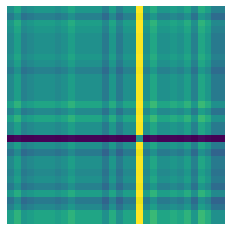

In [94]:
print(Xh3_train.shape)
print(yh3_train[88])
plt.imshow(Xh3_train[88])
plt.axis('off')
plt.savefig('resources/images/gaf-train.png', bbox_inches='tight', transparent=True)

In [95]:
print("Loading GAF images (test)...")
gaf_images = []
yh3_test = []
for path in tqdm_notebook(glob( os.path.join(BENCHMARKING2_RESOURCES_PATH, "GeneratedImages", "*_PAA_GADF_test_*.png") )):    
    # GADF...
    img = keras_image.load_img( path, target_size=(128, 128 ,3))
    img = keras_image.img_to_array(img)
    img = img/255
    gaf_images.append(img)
    # Labels...
    image_labels = [int(l) for l in list(path.split("\\")[-1].split(".")[0].split("_")[-1])]
    yh3_test.append(image_labels)
    
Xh3_test = np.array(gaf_images)
yh3_test = np.array(yh3_test)

Loading GAF images (test)...



 88%|███████████████████████████████████████████████████████████████████▊         | 3525/4000 [00:22<00:01, 315.67it/s]

(4000, 128, 128, 3)
[0 0 0 0 0 0 0 0 0]


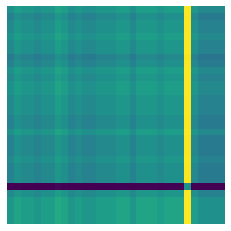

In [96]:
print(Xh3_test.shape)
print(yh3_test[88])
plt.imshow(Xh3_test[88])
plt.axis('off')
plt.savefig('resources/images/gaf-test.png', bbox_inches='tight', transparent=True)

In [97]:
# Select appliances for paper
yh3_train = yh3_train[:, valid_appliances_index]
yh3_test = yh3_test[:, valid_appliances_index]

In [174]:
model_h3 = cnn_model()

model_h3.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 124, 124, 16)      1216      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 58, 58, 32)        12832     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 25, 25, 64)       

In [176]:
# Model fit...
print("Training the model...")
callback = model_h3.fit(
    Xh3_train, yh3_train,
    validation_data=(Xh3_test, yh3_test), 
    epochs=100, batch_size=32,
    verbose = 2#, callbacks = [tqdm_callback]
)

Training the model...
Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 6s - loss: 0.2414 - acc: 0.8999 - f1_m: 0.3134 - val_loss: 0.1908 - val_acc: 0.9212 - val_f1_m: 0.3811
Epoch 2/100
4000/4000 - 6s - loss: 0.2277 - acc: 0.9057 - f1_m: 0.3771 - val_loss: 0.1786 - val_acc: 0.9246 - val_f1_m: 0.3835
Epoch 3/100
4000/4000 - 6s - loss: 0.2237 - acc: 0.9094 - f1_m: 0.4083 - val_loss: 0.2277 - val_acc: 0.9026 - val_f1_m: 0.5361
Epoch 4/100
4000/4000 - 6s - loss: 0.2224 - acc: 0.9107 - f1_m: 0.4054 - val_loss: 0.1862 - val_acc: 0.9204 - val_f1_m: 0.4338
Epoch 5/100
4000/4000 - 6s - loss: 0.2183 - acc: 0.9125 - f1_m: 0.4035 - val_loss: 0.1707 - val_acc: 0.9254 - val_f1_m: 0.4217
Epoch 6/100
4000/4000 - 6s - loss: 0.2164 - acc: 0.9127 - f1_m: 0.4125 - val_loss: 0.1818 - val_acc: 0.9219 - val_f1_m: 0.4685
Epoch 7/100
4000/4000 - 6s - loss: 0.2144 - acc: 0.9150 - f1_m: 0.4314 - val_loss: 0.1764 - val_acc: 0.9230 - val_f1_m: 0.4459
Epoch 8/100
4000/4000 - 6s - loss: 0.2122

Epoch 65/100
4000/4000 - 6s - loss: 0.1159 - acc: 0.9529 - f1_m: 0.7482 - val_loss: 0.1995 - val_acc: 0.9173 - val_f1_m: 0.5144
Epoch 66/100
4000/4000 - 6s - loss: 0.1189 - acc: 0.9502 - f1_m: 0.7344 - val_loss: 0.2063 - val_acc: 0.9166 - val_f1_m: 0.5220
Epoch 67/100
4000/4000 - 6s - loss: 0.1138 - acc: 0.9534 - f1_m: 0.7512 - val_loss: 0.2106 - val_acc: 0.9149 - val_f1_m: 0.5144
Epoch 68/100
4000/4000 - 6s - loss: 0.1147 - acc: 0.9526 - f1_m: 0.7482 - val_loss: 0.2242 - val_acc: 0.9157 - val_f1_m: 0.5173
Epoch 69/100
4000/4000 - 6s - loss: 0.1090 - acc: 0.9550 - f1_m: 0.7673 - val_loss: 0.2037 - val_acc: 0.9202 - val_f1_m: 0.5203
Epoch 70/100
4000/4000 - 6s - loss: 0.1116 - acc: 0.9535 - f1_m: 0.7565 - val_loss: 0.2200 - val_acc: 0.9158 - val_f1_m: 0.4898
Epoch 71/100
4000/4000 - 6s - loss: 0.1082 - acc: 0.9550 - f1_m: 0.7646 - val_loss: 0.2066 - val_acc: 0.9126 - val_f1_m: 0.5253
Epoch 72/100
4000/4000 - 6s - loss: 0.1044 - acc: 0.9568 - f1_m: 0.7746 - val_loss: 0.2235 - val_acc: 0.

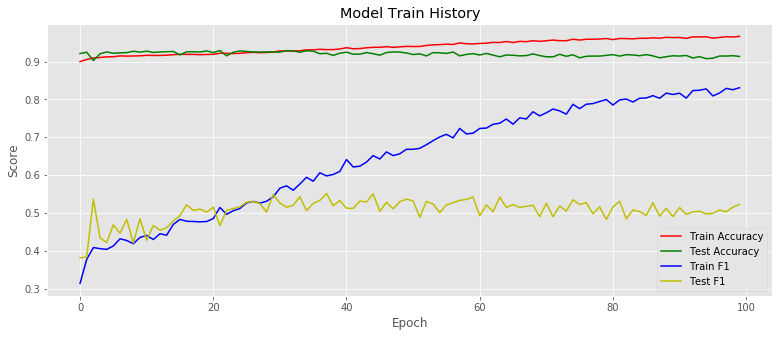

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,62.40,55.00,54.67,54.83,61.31,0.38,0.61,2330,1670
1,Dishwasher,99.00,11.11,3.03,4.76,52.13,0.01,0.51,3967,33
2,Furnace,97.55,3.70,13.04,5.77,52.26,0.02,0.56,3977,23
3,Wash Dryer 1,98.32,56.19,73.75,63.78,81.46,0.02,0.86,3920,80
4,Microwave,99.48,0.00,0.00,0.00,49.87,0.01,0.50,3981,19



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,91.35,25.20,28.90,25.83,59.41,0.09,0.61,3635.0,365.0
max,99.48,56.19,73.75,63.78,81.46,0.38,0.86,3981.0,1670.0
min,62.40,0.00,0.00,0.00,49.87,0.01,0.50,2330.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Refrigerator:
[[1583  747]
 [ 757  913]]

 - Dishwasher:
[[3959    8]
 [  32    1]]

 - Furnace:
[[3899   78]
 [  20    3]]

 - Wash Dryer 1:
[[3874   46]
 [  21   59]]

 - Microwave:
[[3979    2]
 [  19    0]]


In [177]:
# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(model_h3.predict(Xh3_test).round())
classification_report(y_test, y_pred, labels = valid_appliances)

### Gráfico de Recorrência (RP)

In [130]:
# TODO: carregar imagens a partir das series / testar otimização de hiperparametros Recurrence Plot (PyTS package)
print("Loading RP images (train)...")
rp_images = []
yh4_train = []
for path in tqdm_notebook(glob( os.path.join(HYPOTHESIS_RESOURCES_PATH, "*train_color.png") )):    
    # RP...
    img = keras_image.load_img( path, target_size=(128, 128 ,3))
    img = keras_image.img_to_array(img)
    img = img/255
    rp_images.append(img)
    # Labels...
    image_labels = [int(l) for l in list(path.split("\\")[-1].split(".")[0].split("_")[1])]
    yh4_train.append(image_labels)
    
Xh4_train = np.array(rp_images)
yh4_train = np.array(yh4_train)

Loading RP images (train)...


(4000, 128, 128, 3)
[1 0 0 0 0 0 0 0 0]


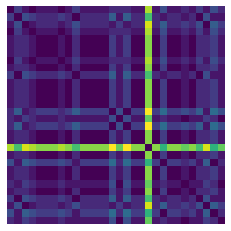

In [131]:
print(Xh4_train.shape)
print(yh4_train[88])
plt.imshow(Xh4_train[88])
plt.axis('off')
plt.savefig('resources/images/rp-train.png', bbox_inches='tight', transparent=True)

In [132]:
print("Loading RP images (test)...")
rp_images = []
yh4_test = []
for path in tqdm_notebook(glob( os.path.join(HYPOTHESIS_RESOURCES_PATH, "*test_color.png") )):    
    # RP...
    img = keras_image.load_img( path, target_size=(128, 128 ,3))
    img = keras_image.img_to_array(img)
    img = img/255
    rp_images.append(img)
    # Labels...
    image_labels = [int(l) for l in list(path.split("\\")[-1].split(".")[0].split("_")[1])]
    yh4_test.append(image_labels)
    
Xh4_test = np.array(rp_images)
yh4_test = np.array(yh4_test)

Loading RP images (test)...


(4000, 128, 128, 3)
[0 0 0 0 0 0 0 0 0]


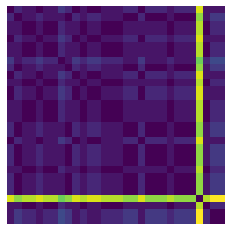

In [133]:
print(Xh4_test.shape)
print(yh4_test[88])
fig = plt.figure()
plt.imshow(Xh4_test[88])
plt.axis('off')
plt.savefig('resources/images/rp-test.png', bbox_inches='tight', transparent=True)

In [134]:
# Select appliances for paper
yh4_train = yh4_train[:, valid_appliances_index]
yh4_test = yh4_test[:, valid_appliances_index]

In [287]:
model_h4 = cnn_model()
model_h4.summary()

# from tensorflow.keras.utils import plot_model
# plot_model(model_h4)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 124, 124, 16)      1216      
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_132 (Dropout)        (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 58, 58, 32)        12832     
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_133 (Dropout)        (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 25, 25, 64)      

In [288]:
# Model fit...
print("Training the model...")
callback = model_h4.fit(
    Xh4_train, yh4_train,
    validation_data=(Xh4_test, yh4_test), 
    epochs=100, batch_size=32,
    verbose = 2#, callbacks = [tqdm_callback]
)

Training the model...
Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 7s - loss: 0.2914 - acc: 0.8735 - f1_m: 0.2725 - val_loss: 0.2623 - val_acc: 0.9087 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 6s - loss: 0.2444 - acc: 0.8915 - f1_m: 0.2148 - val_loss: 0.1777 - val_acc: 0.9088 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 6s - loss: 0.2370 - acc: 0.8960 - f1_m: 0.1664 - val_loss: 0.1853 - val_acc: 0.9239 - val_f1_m: 0.3473
Epoch 4/100
4000/4000 - 6s - loss: 0.2244 - acc: 0.9092 - f1_m: 0.3482 - val_loss: 0.1812 - val_acc: 0.9228 - val_f1_m: 0.3937
Epoch 5/100
4000/4000 - 6s - loss: 0.2206 - acc: 0.9123 - f1_m: 0.3846 - val_loss: 0.1785 - val_acc: 0.9208 - val_f1_m: 0.4238
Epoch 6/100
4000/4000 - 6s - loss: 0.2178 - acc: 0.9141 - f1_m: 0.3870 - val_loss: 0.1915 - val_acc: 0.9081 - val_f1_m: 0.4896
Epoch 7/100
4000/4000 - 6s - loss: 0.2191 - acc: 0.9133 - f1_m: 0.3729 - val_loss: 0.1805 - val_acc: 0.9213 - val_f1_m: 0.4247
Epoch 8/100
4000/4000 - 6s - loss

Epoch 65/100
4000/4000 - 6s - loss: 0.1357 - acc: 0.9366 - f1_m: 0.6335 - val_loss: 0.1706 - val_acc: 0.9244 - val_f1_m: 0.5044
Epoch 66/100
4000/4000 - 6s - loss: 0.1387 - acc: 0.9370 - f1_m: 0.6342 - val_loss: 0.1722 - val_acc: 0.9242 - val_f1_m: 0.5034
Epoch 67/100
4000/4000 - 6s - loss: 0.1377 - acc: 0.9368 - f1_m: 0.6360 - val_loss: 0.1702 - val_acc: 0.9233 - val_f1_m: 0.4852
Epoch 68/100
4000/4000 - 6s - loss: 0.1334 - acc: 0.9381 - f1_m: 0.6455 - val_loss: 0.1799 - val_acc: 0.9251 - val_f1_m: 0.5121
Epoch 69/100
4000/4000 - 6s - loss: 0.1311 - acc: 0.9416 - f1_m: 0.6682 - val_loss: 0.1797 - val_acc: 0.9201 - val_f1_m: 0.5237
Epoch 70/100
4000/4000 - 6s - loss: 0.1305 - acc: 0.9405 - f1_m: 0.6690 - val_loss: 0.1807 - val_acc: 0.9196 - val_f1_m: 0.5373
Epoch 71/100
4000/4000 - 6s - loss: 0.1316 - acc: 0.9407 - f1_m: 0.6648 - val_loss: 0.1810 - val_acc: 0.9228 - val_f1_m: 0.5184
Epoch 72/100
4000/4000 - 6s - loss: 0.1301 - acc: 0.9406 - f1_m: 0.6679 - val_loss: 0.1997 - val_acc: 0.

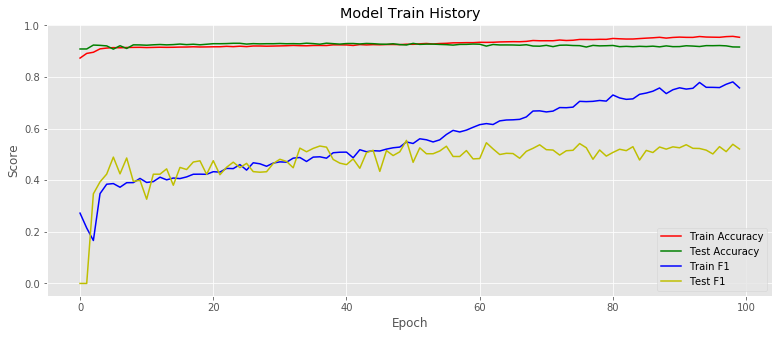

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,64.95,59.17,51.80,55.24,63.22,0.35,0.63,2330,1670
1,Dishwasher,99.02,0.00,0.00,0.00,49.76,0.01,0.50,3967,33
2,Furnace,95.98,2.08,13.04,3.59,50.77,0.04,0.55,3977,23
3,Wash Dryer 1,98.78,65.98,80.00,72.32,85.85,0.01,0.90,3920,80
4,Microwave,99.42,30.00,15.79,20.69,60.20,0.01,0.58,3981,19



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,91.63,31.45,32.13,30.37,61.96,0.08,0.63,3635.0,365.0
max,99.42,65.98,80.00,72.32,85.85,0.35,0.90,3981.0,1670.0
min,64.95,0.00,0.00,0.00,49.76,0.01,0.50,2330.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Refrigerator:
[[1733  597]
 [ 805  865]]

 - Dishwasher:
[[3961    6]
 [  33    0]]

 - Furnace:
[[3836  141]
 [  20    3]]

 - Wash Dryer 1:
[[3887   33]
 [  16   64]]

 - Microwave:
[[3974    7]
 [  16    3]]


In [289]:
# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(model_h4.predict(Xh4_test).round())
classification_report(y_test, y_pred, labels = valid_appliances)

## Validação Cruzada dos modelos CNN

In [88]:
from sklearn.pipeline import Pipeline
from pyts.image import RecurrencePlot, GramianAngularField
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import numpy as np
import random as rn
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
SEED = 33 # Here sd means seed.
np.random.seed(SEED)
rn.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
tf.random.set_seed(SEED)


def calculate_metrics(estimator, X_test, y_test):
    y_pred = np.array(estimator.model.predict(X_test).round()) # TODO: corrigir '.model' (https://github.com/keras-team/keras/issues/9331)
    return (
        accuracy_score(y_test, y_pred), 
        precision_score(y_test, y_pred, average='macro'), 
        recall_score(y_test, y_pred, average='macro'),
        f1_score(y_test, y_pred, average='micro'),
        f1_score(y_test, y_pred, average='macro')
    )

def global_scorer(estimator, X_test, y_test):
    acc, prec, rec, f1, f1m = calculate_metrics(estimator, X_test, y_test)
    return acc, prec, rec, f1, f1m

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    acc, prec, rec, f1, f1m = global_scorer(model, X_test, y_test)
    return [acc, prec, rec, f1, f1m]

#label_encoder = LabelEncoder()

kfold = StratifiedKFold(
    n_splits=10, 
    shuffle=True, 
    random_state= 33
)

train_power_chunks = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/train_power_chunks.npy') )
test_power_chunks = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/test_power_chunks.npy') )

# Power chunks (X) / labels
X = np.concatenate((train_power_chunks, test_power_chunks), axis=0)
y = np.concatenate((yh1_train, yh1_test), axis=0)

In [89]:
print("Loading GAFD images...")
X_gaf = []
#for path in tqdm_notebook(glob( os.path.join(HYPOTHESIS_RESOURCES_PATH, "*_color.png") )):    
for path in tqdm_notebook(glob( os.path.join(BENCHMARKING2_RESOURCES_PATH, "GeneratedImages", "*_PAA_GADF_*_*.png") )):    
    # RP...
    img = keras_image.load_img( path, target_size=(128, 128 ,3))
    img = keras_image.img_to_array(img)
    img = img/255
    X_gaf.append(img)
X_gaf = np.array(X_gaf)

print("Validating model...")
i = 1
results_gaf = []
for train, test in kfold.split(X_gaf, y.argmax(1)):
    print("Split iter. #{}...".format(i))
    acc, prec, rec, f1, f1m = train_and_evaluate_model(
        KerasClassifier(
            build_fn=cnn_model,
            epochs=100, 
            batch_size=32, 
            verbose=2
        ), 
        X_gaf[train,:], y[train,:], 
        X_gaf[test,:], y[test,:]
    )
    results_gaf.append([acc, prec, rec, f1, f1m])
    print("Split iter. #{} results: ".format(i), (acc, prec, rec, f1, f1m))
    i += 1

print("Final average results: ", np.mean(results_gaf, axis = 1)) 

Loading GAFD images...


Validating model...
Split iter. #1...
Train on 7198 samples
Epoch 1/100
7198/7198 - 8s - loss: 0.2694 - acc: 0.8830 - f1_m: 0.3226
Epoch 2/100
7198/7198 - 7s - loss: 0.2269 - acc: 0.8955 - f1_m: 0.2292
Epoch 3/100
7198/7198 - 7s - loss: 0.2232 - acc: 0.8991 - f1_m: 0.1265
Epoch 4/100
7198/7198 - 7s - loss: 0.2177 - acc: 0.9010 - f1_m: 0.0646
Epoch 5/100
7198/7198 - 7s - loss: 0.2161 - acc: 0.9024 - f1_m: 0.0239
Epoch 6/100
7198/7198 - 7s - loss: 0.2175 - acc: 0.9027 - f1_m: 0.0107
Epoch 7/100
7198/7198 - 7s - loss: 0.2150 - acc: 0.9032 - f1_m: 0.0019
Epoch 8/100
7198/7198 - 7s - loss: 0.2143 - acc: 0.9033 - f1_m: 4.9383e-04
Epoch 9/100
7198/7198 - 7s - loss: 0.2131 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 10/100
7198/7198 - 7s - loss: 0.2122 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 11/100
7198/7198 - 7s - loss: 0.2121 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 12/100
7198/7198 - 7s - loss: 0.2123 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 13/100
7198/7198 - 7s - loss: 0.2133 - acc: 0.9034 - f1_m: 

Epoch 8/100
7198/7198 - 7s - loss: 0.2159 - acc: 0.9029 - f1_m: 0.0107
Epoch 9/100
7198/7198 - 7s - loss: 0.2149 - acc: 0.9031 - f1_m: 0.0023
Epoch 10/100
7198/7198 - 7s - loss: 0.2138 - acc: 0.9031 - f1_m: 4.6784e-04
Epoch 11/100
7198/7198 - 7s - loss: 0.2141 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 12/100
7198/7198 - 7s - loss: 0.2135 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 13/100
7198/7198 - 7s - loss: 0.2142 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 14/100
7198/7198 - 7s - loss: 0.2123 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 15/100
7198/7198 - 7s - loss: 0.2133 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 16/100
7198/7198 - 7s - loss: 0.2134 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 17/100
7198/7198 - 7s - loss: 0.2124 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 18/100
7198/7198 - 7s - loss: 0.2120 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 19/100
7198/7198 - 7s - loss: 0.2116 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 20/100
7198/7198 - 7s - loss: 0.2114 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 21/100
7198/7198

Epoch 16/100
7199/7199 - 7s - loss: 0.2113 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 17/100
7199/7199 - 7s - loss: 0.2114 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 18/100
7199/7199 - 7s - loss: 0.2116 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 19/100
7199/7199 - 7s - loss: 0.2115 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 20/100
7199/7199 - 7s - loss: 0.2111 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 21/100
7199/7199 - 7s - loss: 0.2111 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 22/100
7199/7199 - 7s - loss: 0.2107 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 23/100
7199/7199 - 7s - loss: 0.2106 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 24/100
7199/7199 - 7s - loss: 0.2106 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 25/100
7199/7199 - 7s - loss: 0.2102 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 26/100
7199/7199 - 7s - loss: 0.2100 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 27/100
7199/7199 - 7s - loss: 0.2110 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 28/100
7199/7199 - 7s - loss: 0.2108 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 29/100

Epoch 23/100
7199/7199 - 7s - loss: 0.2111 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 24/100
7199/7199 - 7s - loss: 0.2113 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 25/100
7199/7199 - 7s - loss: 0.2112 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 26/100
7199/7199 - 7s - loss: 0.2113 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 27/100
7199/7199 - 7s - loss: 0.2116 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 28/100
7199/7199 - 7s - loss: 0.2111 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 29/100
7199/7199 - 7s - loss: 0.2113 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 30/100
7199/7199 - 7s - loss: 0.2119 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 31/100
7199/7199 - 7s - loss: 0.2106 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 32/100
7199/7199 - 7s - loss: 0.2107 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 33/100
7199/7199 - 7s - loss: 0.2106 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 34/100
7199/7199 - 7s - loss: 0.2112 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 35/100
7199/7199 - 7s - loss: 0.2107 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 36/100

Epoch 30/100
7200/7200 - 7s - loss: 0.2108 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 31/100
7200/7200 - 7s - loss: 0.2110 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 32/100
7200/7200 - 7s - loss: 0.2111 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 33/100
7200/7200 - 7s - loss: 0.2107 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 34/100
7200/7200 - 7s - loss: 0.2110 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 35/100
7200/7200 - 7s - loss: 0.2112 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 36/100
7200/7200 - 7s - loss: 0.2109 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 37/100
7200/7200 - 7s - loss: 0.2106 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 38/100
7200/7200 - 7s - loss: 0.2110 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 39/100
7200/7200 - 7s - loss: 0.2111 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 40/100
7200/7200 - 7s - loss: 0.2109 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 41/100
7200/7200 - 7s - loss: 0.2111 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 42/100
7200/7200 - 7s - loss: 0.2108 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 43/100

Epoch 38/100
7200/7200 - 7s - loss: 0.2107 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 39/100
7200/7200 - 7s - loss: 0.2113 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 40/100
7200/7200 - 7s - loss: 0.2108 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 41/100
7200/7200 - 7s - loss: 0.2116 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 42/100
7200/7200 - 7s - loss: 0.2111 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 43/100
7200/7200 - 7s - loss: 0.2110 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 44/100
7200/7200 - 7s - loss: 0.2105 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 45/100
7200/7200 - 7s - loss: 0.2110 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 46/100
7200/7200 - 7s - loss: 0.2111 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 47/100
7200/7200 - 7s - loss: 0.2108 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 48/100
7200/7200 - 7s - loss: 0.2109 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 49/100
7200/7200 - 7s - loss: 0.2113 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 50/100
7200/7200 - 7s - loss: 0.2110 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 51/100

Epoch 52/100
7201/7201 - 7s - loss: 0.2104 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 53/100
7201/7201 - 7s - loss: 0.2099 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 54/100
7201/7201 - 7s - loss: 0.2098 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 55/100
7201/7201 - 7s - loss: 0.2103 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 56/100
7201/7201 - 7s - loss: 0.2104 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 57/100
7201/7201 - 7s - loss: 0.2099 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 58/100
7201/7201 - 7s - loss: 0.2095 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 59/100
7201/7201 - 7s - loss: 0.2100 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 60/100
7201/7201 - 7s - loss: 0.2096 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 61/100
7201/7201 - 7s - loss: 0.2102 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 62/100
7201/7201 - 7s - loss: 0.2098 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 63/100
7201/7201 - 7s - loss: 0.2102 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 64/100
7201/7201 - 7s - loss: 0.2094 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 65/100

Epoch 59/100
7202/7202 - 7s - loss: 0.2100 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 60/100
7202/7202 - 7s - loss: 0.2104 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 61/100
7202/7202 - 7s - loss: 0.2106 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 62/100
7202/7202 - 7s - loss: 0.2100 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 63/100
7202/7202 - 7s - loss: 0.2099 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 64/100
7202/7202 - 7s - loss: 0.2104 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 65/100
7202/7202 - 7s - loss: 0.2104 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 66/100
7202/7202 - 7s - loss: 0.2098 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 67/100
7202/7202 - 7s - loss: 0.2102 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 68/100
7202/7202 - 7s - loss: 0.2104 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 69/100
7202/7202 - 8s - loss: 0.2103 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 70/100
7202/7202 - 7s - loss: 0.2103 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 71/100
7202/7202 - 7s - loss: 0.2100 - acc: 0.9027 - f1_m: 0.0000e+00
Epoch 72/100

In [90]:
print("Loading RP images...")
X_rp = []
for path in tqdm_notebook(glob( os.path.join(HYPOTHESIS_RESOURCES_PATH, "*_color.png") )):    
    # RP...
    img = keras_image.load_img( path, target_size=(128, 128 ,3))
    img = keras_image.img_to_array(img)
    img = img/255
    X_rp.append(img)
X_rp = np.array(X_rp)

print("Validating model...")
i = 1
results_rp = []
for train, test in kfold.split(X_rp, y.argmax(1)):
    print("Split iter. #{}...".format(i))
    acc, prec, rec, f1, f1m = train_and_evaluate_model(
        KerasClassifier(
            build_fn=cnn_model,
            epochs=100, 
            batch_size=32, 
            verbose=2
        ), 
        X_rp[train,:], y[train,:], 
        X_rp[test,:], y[test,:]
    )
    results_rp.append([acc, prec, rec, f1, f1m])
    print("Split iter. #{} results: ".format(i), (acc, prec, rec, f1, f1m))
    i += 1

print("Final average results: ", np.mean(results_rp, axis = 1)) 

Loading RP images...


Validating model...
Split iter. #1...
Train on 7198 samples
Epoch 1/100
7198/7198 - 8s - loss: 0.2706 - acc: 0.8814 - f1_m: 0.3241
Epoch 2/100
7198/7198 - 7s - loss: 0.2253 - acc: 0.8964 - f1_m: 0.2529
Epoch 3/100
7198/7198 - 7s - loss: 0.2216 - acc: 0.8978 - f1_m: 0.1824
Epoch 4/100
7198/7198 - 7s - loss: 0.2188 - acc: 0.9010 - f1_m: 0.0884
Epoch 5/100
7198/7198 - 7s - loss: 0.2174 - acc: 0.9026 - f1_m: 0.0618
Epoch 6/100
7198/7198 - 7s - loss: 0.2176 - acc: 0.9024 - f1_m: 0.0263
Epoch 7/100
7198/7198 - 7s - loss: 0.2165 - acc: 0.9036 - f1_m: 0.0066
Epoch 8/100
7198/7198 - 8s - loss: 0.2140 - acc: 0.9034 - f1_m: 0.0029
Epoch 9/100
7198/7198 - 7s - loss: 0.2138 - acc: 0.9034 - f1_m: 0.0011
Epoch 10/100
7198/7198 - 8s - loss: 0.2126 - acc: 0.9034 - f1_m: 0.0012
Epoch 11/100
7198/7198 - 8s - loss: 0.2125 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 12/100
7198/7198 - 7s - loss: 0.2120 - acc: 0.9034 - f1_m: 0.0000e+00
Epoch 13/100
7198/7198 - 7s - loss: 0.2114 - acc: 0.9034 - f1_m: 0.0000e+00
E

Epoch 8/100
7198/7198 - 7s - loss: 0.2132 - acc: 0.9028 - f1_m: 0.0082
Epoch 9/100
7198/7198 - 7s - loss: 0.2134 - acc: 0.9032 - f1_m: 0.0049
Epoch 10/100
7198/7198 - 7s - loss: 0.2129 - acc: 0.9031 - f1_m: 5.2288e-04
Epoch 11/100
7198/7198 - 7s - loss: 0.2126 - acc: 0.9032 - f1_m: 0.0011
Epoch 12/100
7198/7198 - 7s - loss: 0.2122 - acc: 0.9031 - f1_m: 6.3492e-04
Epoch 13/100
7198/7198 - 7s - loss: 0.2116 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 14/100
7198/7198 - 7s - loss: 0.2124 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 15/100
7198/7198 - 7s - loss: 0.2121 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 16/100
7198/7198 - 7s - loss: 0.2112 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 17/100
7198/7198 - 7s - loss: 0.2118 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 18/100
7198/7198 - 7s - loss: 0.2110 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 19/100
7198/7198 - 7s - loss: 0.2105 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 20/100
7198/7198 - 7s - loss: 0.2105 - acc: 0.9031 - f1_m: 0.0000e+00
Epoch 21/100
7198/7198 - 7

Epoch 22/100
7199/7199 - 7s - loss: 0.2114 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 23/100
7199/7199 - 7s - loss: 0.2118 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 24/100
7199/7199 - 7s - loss: 0.2118 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 25/100
7199/7199 - 7s - loss: 0.2118 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 26/100
7199/7199 - 7s - loss: 0.2117 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 27/100
7199/7199 - 7s - loss: 0.2118 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 28/100
7199/7199 - 7s - loss: 0.2106 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 29/100
7199/7199 - 7s - loss: 0.2102 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 30/100
7199/7199 - 7s - loss: 0.2111 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 31/100
7199/7199 - 7s - loss: 0.2105 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 32/100
7199/7199 - 7s - loss: 0.2116 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 33/100
7199/7199 - 7s - loss: 0.2111 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 34/100
7199/7199 - 7s - loss: 0.2114 - acc: 0.9028 - f1_m: 0.0000e+00
Epoch 35/100

Epoch 29/100
7200/7200 - 7s - loss: 0.2115 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 30/100
7200/7200 - 7s - loss: 0.2116 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 31/100
7200/7200 - 7s - loss: 0.2111 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 32/100
7200/7200 - 7s - loss: 0.2107 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 33/100
7200/7200 - 7s - loss: 0.2105 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 34/100
7200/7200 - 7s - loss: 0.2106 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 35/100
7200/7200 - 7s - loss: 0.2110 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 36/100
7200/7200 - 7s - loss: 0.2109 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 37/100
7200/7200 - 7s - loss: 0.2112 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 38/100
7200/7200 - 7s - loss: 0.2108 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 39/100
7200/7200 - 7s - loss: 0.2112 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 40/100
7200/7200 - 7s - loss: 0.2106 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 41/100
7200/7200 - 7s - loss: 0.2111 - acc: 0.9033 - f1_m: 0.0000e+00
Epoch 42/100

Epoch 43/100
7201/7201 - 18s - loss: 0.2100 - acc: 0.9026 - f1_m: 0.0000e+00
Epoch 44/100
7201/7201 - 18s - loss: 0.2106 - acc: 0.9026 - f1_m: 0.0000e+00
Epoch 45/100
7201/7201 - 18s - loss: 0.2104 - acc: 0.9026 - f1_m: 0.0000e+00
Epoch 46/100
7201/7201 - 18s - loss: 0.2102 - acc: 0.9026 - f1_m: 0.0000e+00
Epoch 47/100
7201/7201 - 18s - loss: 0.2101 - acc: 0.9026 - f1_m: 0.0000e+00
Epoch 48/100
7201/7201 - 18s - loss: 0.2103 - acc: 0.9026 - f1_m: 0.0000e+00
Epoch 49/100
7201/7201 - 18s - loss: 0.2102 - acc: 0.9026 - f1_m: 0.0000e+00
Epoch 50/100
7201/7201 - 18s - loss: 0.2102 - acc: 0.9026 - f1_m: 0.0000e+00
Epoch 51/100
7201/7201 - 18s - loss: 0.2101 - acc: 0.9026 - f1_m: 0.0000e+00
Epoch 52/100
7201/7201 - 18s - loss: 0.2100 - acc: 0.9026 - f1_m: 0.0000e+00
Epoch 53/100
7201/7201 - 18s - loss: 0.2099 - acc: 0.9026 - f1_m: 0.0000e+00
Epoch 54/100
7201/7201 - 18s - loss: 0.2103 - acc: 0.9026 - f1_m: 0.0000e+00
Epoch 55/100
7201/7201 - 18s - loss: 0.2097 - acc: 0.9026 - f1_m: 0.0000e+00

KeyboardInterrupt: 

In [178]:
# class ImageProcessing():
#     def __init__(self, image_size_px = 128, Y = None):
#         self.image_size_px = image_size_px
        
#     def fit(self, images, Y = None, mode = "train"):
#         return self

#     def transform(self, images, Y = None, mode = 'train'):
#         processed_images = []
#         try:
            
#             for idx, image in tqdm(enumerate(images)):
#                 labels = Y[idx, :].astype('str').tolist()
#                 labels_str = ''.join(labels)
#                 np.save(
#                     os.path.join( 
#                         HYPOTHESIS_RESOURCES_PATH, 
#                         "{}_{}_{}.npy".format(idx, labels_str, mode) 
#                     ), 
#                     image
#                 )
#                 image_path = os.path.join( 
#                         HYPOTHESIS_RESOURCES_PATH, 
#                         "{}_{}_{}_color.png".format(idx, labels_str, mode) 
#                     )
#                 imsave(
#                     image_path, 
#                     arr=image
#                 )
#                 # Reading image in 3channel RGB mode
#                 img = keras_image.load_img( image_path, target_size=(self.image_size_px, self.image_size_px ,3))
#                 img = keras_image.img_to_array(img)
#                 img = img/255                
#                 processed_images.append(img)
            
#         except Exception as err:
#             print('ImageProcessing.transform(): {}'.format(err))
            
#         return np.array(processed_images)

#     def fit_transform(self, images, Y = None, mode = 'train'):
#         self.fit(images)
#         return self.transform(images, Y, mode)

# clf_rp = KerasClassifier(
#     cnn_model,
#     epochs=100, 
#     batch_size=32, 
#     verbose=2
# )

# cnn_rp_pipeline = Pipeline([
#     ('recurrenceplot', RecurrencePlot()),
#     ('imageprocessing', ImageProcessing()),
#     ('clf', clf_rp)
# ])

# result = cnn_rp_pipeline.fit(
#     train_power_chunks, 
#     yh1_train, 
#     imageprocessing__mode = "train")

In [267]:
# # Test colored imagens
# cnn_rp_pipeline = Pipeline([
#     ('recurrenceplot', RecurrencePlot()),
#     ('imageprocessing', ImageProcessing()),
#     #('clf', clf_rp)
# ])
# images = cnn_rp_pipeline.fit_transform(
#     train_power_chunks, 
#     yh1_train, 
#     imageprocessing__mode = "train")

# # Visualizing Serie/RP
# image = images[0]
# fig = plt.figure(figsize=(2,2))
# fig.tight_layout(); # Or equivalently,  "plt.tight_layout()"
# ax = fig.add_subplot(1, 1, 1);
# ax.imshow(image, origin="lower", aspect="auto");
# plt.axis('off');

# # Visualizing Serie/RP
# image_ = Image.fromarray(image[:,:,0]*255).convert('RGB').resize((image_size_px, image_size_px))
# fig = plt.figure(figsize=(2,2))
# fig.tight_layout(); # Or equivalently,  "plt.tight_layout()"
# ax = fig.add_subplot(1, 1, 1);
# ax.imshow(image_, origin="lower", aspect="auto");
# plt.axis('off');

# Amostras de Imagens Individuais

Appliance `Refrigerator`:


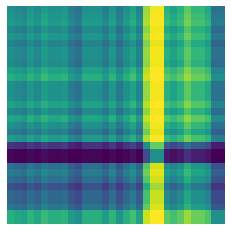

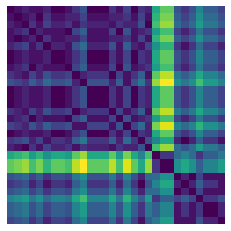

In [141]:
idx_appliance = 0

index = np.where(
    (yh3_train[:, idx_appliance] == 1) & 
    (yh3_train[:, 1] == 0) & (yh3_train[:, 2] == 0) &
    (yh3_train[:, 3] == 0) & (yh3_train[:, 4] == 0)
)[0][0]

print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
fig = plt.figure()
plt.imshow(Xh3_train[index])
plt.axis('off')
plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

fig = plt.figure()
plt.imshow(Xh4_train[index])
plt.axis('off')
plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

Appliance `Dishwasher`:


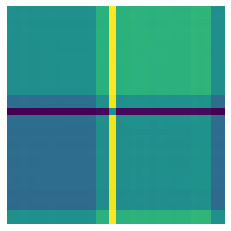

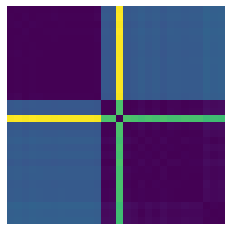

In [142]:
idx_appliance = 1

index = np.where(
    (yh3_train[:, idx_appliance] == 1) & 
    (yh3_train[:, 0] == 0) & (yh3_train[:, 2] == 0) &
    (yh3_train[:, 3] == 0) & (yh3_train[:, 4] == 0)
)[0][0]

print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
fig = plt.figure()
plt.imshow(Xh3_train[index])
plt.axis('off')
plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

fig = plt.figure()
plt.imshow(Xh4_train[index])
plt.axis('off')
plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

Appliance `Furnace`:


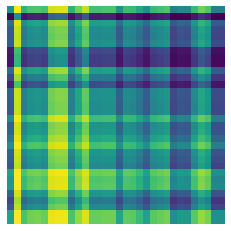

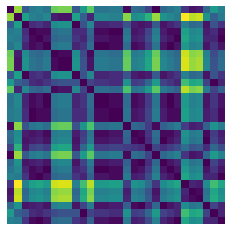

In [143]:
idx_appliance = 2

index = np.where(
    (yh3_train[:, idx_appliance] == 1) & 
    (yh3_train[:, 0] == 0) & (yh3_train[:, 1] == 0) &
    (yh3_train[:, 3] == 0) & (yh3_train[:, 4] == 0)
)[0][0]

print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
fig = plt.figure()
plt.imshow(Xh3_train[index])
plt.axis('off')
plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

fig = plt.figure()
plt.imshow(Xh4_train[index])
plt.axis('off')
plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

Appliance `Wash Dryer 1`:


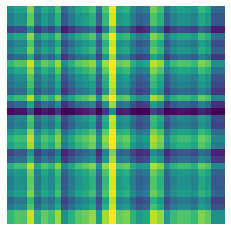

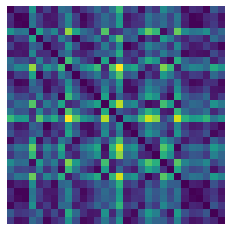

In [144]:
idx_appliance = 3

index = np.where(
    (yh3_train[:, idx_appliance] == 1) & 
    (yh3_train[:, 0] == 0) & (yh3_train[:, 1] == 0) &
    (yh3_train[:, 2] == 0) & (yh3_train[:, 4] == 0)
)[0][0]

print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
fig = plt.figure()
plt.imshow(Xh3_train[index])
plt.axis('off')
plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

fig = plt.figure()
plt.imshow(Xh4_train[index])
plt.axis('off')
plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

Appliance `Microwave`:


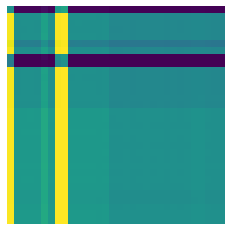

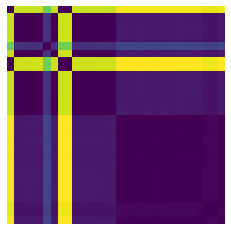

In [145]:
idx_appliance = 4

index = np.where(
    (yh3_train[:, idx_appliance] == 1) & 
    (yh3_train[:, 0] == 0) & (yh3_train[:, 1] == 0) &
    (yh3_train[:, 2] == 0) & (yh3_train[:, 3] == 0)
)[0][0]

print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
fig = plt.figure()
plt.imshow(Xh3_train[index])
plt.axis('off')
plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

fig = plt.figure()
plt.imshow(Xh4_train[index])
plt.axis('off')
plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

# Deep Learning

In [116]:
import shutil
from tensorflow.keras import optimizers

class ImageProcessing():
    def __init__(self, image_size_px = 128, Y = None):
        self.image_size_px = image_size_px
        
    def fit(self, images, Y = None, mode = "train"):
        return self

    def transform(self, images, Y = None, mode = 'train'):
        processed_images = []
        try:
#             for idx, image in tqdm_notebook(enumerate(images), total=len(images)):
#                 img = np.stack((image,) * 3, -1)
#                 processed_images.append(img/255)
            if os.path.isdir(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp")):        
                shutil.rmtree(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))
            os.makedirs(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))
                
            for idx, image in tqdm_notebook(enumerate(images)):
#                 labels = Y[idx, :].astype('str').tolist()
#                 labels_str = ''.join(labels)
                image_path = os.path.join( 
                        HYPOTHESIS_RESOURCES_PATH, "temp",
                        "{}_{}_color.png".format(idx, mode) 
                    )
                imsave(
                    image_path, 
                    arr=image
                )
                # Reading image in 3channel RGB mode
                img = keras_image.load_img( image_path, target_size=(self.image_size_px, self.image_size_px ,3))
                img = keras_image.img_to_array(img)
                img = img/255                
                #img = MinMaxScaler(feature_range=(-1, 1)).fit_transform(img.reshape(1,-1)).reshape(img.shape)
                processed_images.append(img)
            
            shutil.rmtree(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))
            
        except Exception as err:
            print('ImageProcessing.transform(): {}'.format(err))
            
        return np.array(processed_images)
        #return processed_images

    def fit_transform(self, images, Y = None, mode = 'train'):
        self.fit(images)
        return self.transform(images, Y, mode)

def vgg_model_multilabel():
    base_model = VGG16(
        weights='imagenet',
        #weights = None,
        include_top=False, #imports the mobilenet model and discards the last neuron layer.
        input_shape = train_rp_images[0].shape
    ) 
    # mark loaded layers as not trainable
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x) #dense layer 2
    x = Dropout(0.5)(x)
    x = Dense(64,activation='relu')(x) #dense layer 3
    x = Dropout(0.5)(x)
    
    output_layer = Dense(len(valid_appliances), activation='softmax')(x) #final layer with softmax activation
    
    model = Model(
        inputs  = base_model.input,
        outputs = output_layer
    )    
    model.compile(
        optimizer=optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
        loss='categorical_crossentropy',
        metrics=['accuracy', f1_m]
    )
    
    return model

def vgg_model_appliance():
    base_model = VGG16(
        weights='imagenet',
        #weights = None,
        include_top=False, #imports the mobilenet model and discards the last neuron layer.
        input_shape = train_rp_images[0].shape
    ) 
    # mark loaded layers as not trainable
    for layer in base_model.layers:
        layer.trainable = False
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    
#     #x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#     x=Dense(1024,activation='relu')(x) #dense layer 2
#     x=Dense(512,activation='relu')(x) #dense layer 3
#     #output_layer = Dense(2, activation='softmax')(x) #final layer with softmax activation
    
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x) #dense layer 2
    x = Dropout(0.5)(x)
    x = Dense(64,activation='relu')(x) #dense layer 3
    x = Dropout(0.5)(x)
    
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(
        inputs  = base_model.input,
        outputs = output_layer
    )    
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', f1_m])
    
    return model

def tiled_cnn_model( ):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(len(valid_appliances), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',f1_m])
    
    return model

In [7]:
print("Processing GAF datasets (train/test)...")
gaf_pipeline = Pipeline([
    ('gramianangularfield', GramianAngularField()),
    ('imageprocessing', ImageProcessing())
])

power_chunks = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/train_power_chunks.npy') )
train_gaf_images = gaf_pipeline.fit_transform(
    power_chunks,      
    imageprocessing__mode = "train")

power_chunks = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/test_power_chunks.npy') )
test_gaf_images = gaf_pipeline.fit_transform(
    power_chunks,      
    imageprocessing__mode = "test")

print("Processing RP datasets (train/test)...")
rp_pipeline = Pipeline([
    ('recurrenceplot', RecurrencePlot()),
    ('imageprocessing', ImageProcessing())
])

power_chunks = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/train_power_chunks.npy') )
train_rp_images = rp_pipeline.fit_transform(
    power_chunks,      
    imageprocessing__mode = "train")

power_chunks = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/test_power_chunks.npy') )
test_rp_images = rp_pipeline.fit_transform(
    power_chunks,      
    imageprocessing__mode = "test")
# # Visualizing Serie/Image
# fig = plt.figure(figsize=(2,2))
# fig.tight_layout(); # Or equivalently,  "plt.tight_layout()"
# ax = fig.add_subplot(1, 1, 1);
# ax.imshow(test_gaf_images[0], origin="lower", aspect="auto");
# ax = fig.add_subplot(1, 2, 1);
# ax.plot(list(power_chunks[0, :]), range(len(power_chunks[0, :])));
# plt.axis('off');

del power_chunks

Processing GAF datasets (train/test)...



Processing RP datasets (train/test)...


## Classificador Multilabel

### GAF

Training GAF multilabel model...
Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 7s - loss: 0.4263 - acc: 0.9442 - f1_m: 0.5214 - val_loss: 0.2987 - val_acc: 0.9833 - val_f1_m: 0.4757
Epoch 2/100
4000/4000 - 7s - loss: 0.3901 - acc: 0.9505 - f1_m: 0.5171 - val_loss: 0.2854 - val_acc: 0.9833 - val_f1_m: 0.4731
Epoch 3/100
4000/4000 - 7s - loss: 0.3715 - acc: 0.9495 - f1_m: 0.5152 - val_loss: 0.2196 - val_acc: 0.9833 - val_f1_m: 0.5471
Epoch 4/100
4000/4000 - 7s - loss: 0.3574 - acc: 0.9465 - f1_m: 0.5150 - val_loss: 0.2212 - val_acc: 0.9833 - val_f1_m: 0.5565
Epoch 5/100
4000/4000 - 7s - loss: 0.3478 - acc: 0.9440 - f1_m: 0.5176 - val_loss: 0.2429 - val_acc: 0.9758 - val_f1_m: 0.5410
Epoch 6/100
4000/4000 - 7s - loss: 0.3317 - acc: 0.9440 - f1_m: 0.5177 - val_loss: 0.2299 - val_acc: 0.9730 - val_f1_m: 0.5362
Epoch 7/100
4000/4000 - 7s - loss: 0.3181 - acc: 0.9423 - f1_m: 0.5188 - val_loss: 0.2515 - val_acc: 0.9775 - val_f1_m: 0.5533
Epoch 8/100
4000/4000 - 7s - l

Epoch 65/100
4000/4000 - 7s - loss: 0.1432 - acc: 0.9567 - f1_m: 0.5814 - val_loss: 0.2155 - val_acc: 0.9517 - val_f1_m: 0.5487
Epoch 66/100
4000/4000 - 7s - loss: 0.1462 - acc: 0.9555 - f1_m: 0.5798 - val_loss: 0.2031 - val_acc: 0.9507 - val_f1_m: 0.5417
Epoch 67/100
4000/4000 - 7s - loss: 0.1392 - acc: 0.9557 - f1_m: 0.5835 - val_loss: 0.2062 - val_acc: 0.9505 - val_f1_m: 0.5450
Epoch 68/100
4000/4000 - 7s - loss: 0.1413 - acc: 0.9572 - f1_m: 0.5815 - val_loss: 0.2159 - val_acc: 0.9362 - val_f1_m: 0.5357
Epoch 69/100
4000/4000 - 7s - loss: 0.1418 - acc: 0.9520 - f1_m: 0.5817 - val_loss: 0.1993 - val_acc: 0.9505 - val_f1_m: 0.5439
Epoch 70/100
4000/4000 - 7s - loss: 0.1455 - acc: 0.9515 - f1_m: 0.5788 - val_loss: 0.2115 - val_acc: 0.9425 - val_f1_m: 0.5401
Epoch 71/100
4000/4000 - 7s - loss: 0.1448 - acc: 0.9538 - f1_m: 0.5798 - val_loss: 0.1992 - val_acc: 0.9572 - val_f1_m: 0.5513
Epoch 72/100
4000/4000 - 7s - loss: 0.1437 - acc: 0.9523 - f1_m: 0.5831 - val_loss: 0.2099 - val_acc: 0.

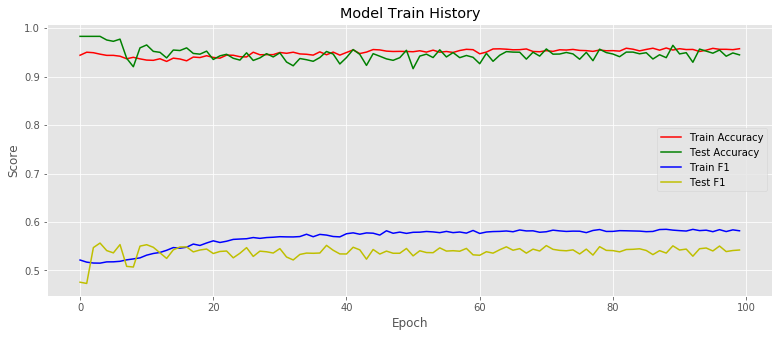

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,41.32,41.04,92.87,56.93,32.46,0.59,0.49,2330,1670
1,Dishwasher,98.88,7.14,3.03,4.26,51.84,0.01,0.51,3967,33
2,Furnace,96.80,3.54,17.39,5.88,52.13,0.03,0.57,3977,23
3,Wash Dryer 1,98.22,63.64,26.25,37.17,68.13,0.02,0.63,3920,80
4,Microwave,99.48,0.00,0.00,0.00,49.87,0.01,0.50,3981,19



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,86.94,23.07,27.91,20.85,50.89,0.13,0.54,3635.0,365.0
max,99.48,63.64,92.87,56.93,68.13,0.59,0.63,3981.0,1670.0
min,41.32,0.00,0.00,0.00,32.46,0.01,0.49,2330.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Refrigerator:
[[ 102 2228]
 [ 119 1551]]

 - Dishwasher:
[[3954   13]
 [  32    1]]

 - Furnace:
[[3868  109]
 [  19    4]]

 - Wash Dryer 1:
[[3908   12]
 [  59   21]]

 - Microwave:
[[3979    2]
 [  19    0]]


In [144]:
# Model fit...
print("Training GAF multilabel model...")

multiabel_gaf_model = tiled_cnn_model()#vgg_model_multilabel()

callback = multiabel_gaf_model.fit(
    train_gaf_images, yb1_train,
    validation_data=(test_gaf_images, yb1_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2#, callbacks = [tqdm_callback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_gaf_model.predict(test_gaf_images).round())
classification_report(yb1_test, y_pred, labels = valid_appliances)

Training GAF multilabel model...
Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 19s - loss: 0.5350 - accuracy: 0.8298 - f1_m: 0.4321 - val_loss: 0.2056 - val_accuracy: 0.9833 - val_f1_m: 0.5676
Epoch 2/100
4000/4000 - 18s - loss: 0.4493 - accuracy: 0.9367 - f1_m: 0.4935 - val_loss: 0.1914 - val_accuracy: 0.9833 - val_f1_m: 0.5686
Epoch 3/100
4000/4000 - 18s - loss: 0.4343 - accuracy: 0.9470 - f1_m: 0.4965 - val_loss: 0.1933 - val_accuracy: 0.9833 - val_f1_m: 0.5691
Epoch 4/100
4000/4000 - 18s - loss: 0.4185 - accuracy: 0.9490 - f1_m: 0.5004 - val_loss: 0.2003 - val_accuracy: 0.9833 - val_f1_m: 0.5680
Epoch 5/100
4000/4000 - 18s - loss: 0.4173 - accuracy: 0.9498 - f1_m: 0.4970 - val_loss: 0.1929 - val_accuracy: 0.9833 - val_f1_m: 0.5684
Epoch 6/100
4000/4000 - 18s - loss: 0.4045 - accuracy: 0.9507 - f1_m: 0.4982 - val_loss: 0.1899 - val_accuracy: 0.9833 - val_f1_m: 0.5664
Epoch 7/100
4000/4000 - 18s - loss: 0.4038 - accuracy: 0.9503 - f1_m: 0.5023 - val_loss: 0.

Epoch 60/100
4000/4000 - 18s - loss: 0.3640 - accuracy: 0.9490 - f1_m: 0.5172 - val_loss: 0.1840 - val_accuracy: 0.9833 - val_f1_m: 0.5644
Epoch 61/100
4000/4000 - 18s - loss: 0.3621 - accuracy: 0.9505 - f1_m: 0.5159 - val_loss: 0.1720 - val_accuracy: 0.9833 - val_f1_m: 0.5652
Epoch 62/100
4000/4000 - 18s - loss: 0.3621 - accuracy: 0.9490 - f1_m: 0.5175 - val_loss: 0.1717 - val_accuracy: 0.9833 - val_f1_m: 0.5647
Epoch 63/100
4000/4000 - 18s - loss: 0.3635 - accuracy: 0.9488 - f1_m: 0.5174 - val_loss: 0.1825 - val_accuracy: 0.9830 - val_f1_m: 0.5625
Epoch 64/100
4000/4000 - 18s - loss: 0.3634 - accuracy: 0.9495 - f1_m: 0.5164 - val_loss: 0.1805 - val_accuracy: 0.9833 - val_f1_m: 0.5643
Epoch 65/100
4000/4000 - 18s - loss: 0.3658 - accuracy: 0.9485 - f1_m: 0.5164 - val_loss: 0.1800 - val_accuracy: 0.9833 - val_f1_m: 0.5657
Epoch 66/100
4000/4000 - 18s - loss: 0.3643 - accuracy: 0.9488 - f1_m: 0.5162 - val_loss: 0.1697 - val_accuracy: 0.9830 - val_f1_m: 0.5654
Epoch 67/100
4000/4000 - 18

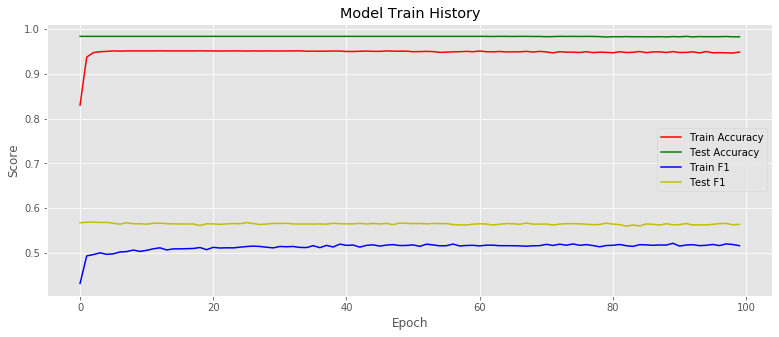

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,41.55,41.56,98.44,58.44,29.98,0.58,0.5,2330,1670
1,Dishwasher,99.18,0.00,0.00,0.00,49.79,0.01,0.5,3967,33
2,Furnace,99.42,0.00,0.00,0.00,49.86,0.01,0.5,3977,23
3,Wash Dryer 1,98.00,0.00,0.00,0.00,49.49,0.02,0.5,3920,80
4,Microwave,99.52,0.00,0.00,0.00,49.88,0.00,0.5,3981,19



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,87.53,8.31,19.69,11.69,45.80,0.12,0.5,3635.0,365.0
max,99.52,41.56,98.44,58.44,49.88,0.58,0.5,3981.0,1670.0
min,41.55,0.00,0.00,0.00,29.98,0.00,0.5,2330.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Refrigerator:
[[  18 2312]
 [  26 1644]]

 - Dishwasher:
[[3967    0]
 [  33    0]]

 - Furnace:
[[3977    0]
 [  23    0]]

 - Wash Dryer 1:
[[3920    0]
 [  80    0]]

 - Microwave:
[[3981    0]
 [  19    0]]


In [145]:
# Model fit...
print("Training GAF multilabel model...")

multiabel_gaf_model = vgg_model_multilabel()

callback = multiabel_gaf_model.fit(
    train_gaf_images, yb1_train,
    validation_data=(test_gaf_images, yb1_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2#, callbacks = [tqdm_callback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_gaf_model.predict(test_gaf_images).round())
classification_report(yb1_test, y_pred, labels = valid_appliances)

Training GAF multilabel model...
Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 6s - loss: 0.3047 - acc: 0.8722 - f1_m: 0.2993 - val_loss: 0.2118 - val_acc: 0.9087 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 6s - loss: 0.2550 - acc: 0.8899 - f1_m: 0.2562 - val_loss: 0.2056 - val_acc: 0.9087 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 6s - loss: 0.2416 - acc: 0.8972 - f1_m: 0.2806 - val_loss: 0.1911 - val_acc: 0.9196 - val_f1_m: 0.2942
Epoch 4/100
4000/4000 - 6s - loss: 0.2313 - acc: 0.9070 - f1_m: 0.3435 - val_loss: 0.1894 - val_acc: 0.9191 - val_f1_m: 0.4070
Epoch 5/100
4000/4000 - 6s - loss: 0.2255 - acc: 0.9118 - f1_m: 0.3720 - val_loss: 0.1892 - val_acc: 0.9226 - val_f1_m: 0.3533
Epoch 6/100
4000/4000 - 6s - loss: 0.2214 - acc: 0.9118 - f1_m: 0.3668 - val_loss: 0.1757 - val_acc: 0.9220 - val_f1_m: 0.3428
Epoch 7/100
4000/4000 - 6s - loss: 0.2203 - acc: 0.9130 - f1_m: 0.3806 - val_loss: 0.1736 - val_acc: 0.9222 - val_f1_m: 0.3216
Epoch 8/100
4000/4000 

Epoch 65/100
4000/4000 - 6s - loss: 0.1345 - acc: 0.9404 - f1_m: 0.6542 - val_loss: 0.2002 - val_acc: 0.9147 - val_f1_m: 0.4874
Epoch 66/100
4000/4000 - 6s - loss: 0.1340 - acc: 0.9413 - f1_m: 0.6717 - val_loss: 0.2011 - val_acc: 0.9128 - val_f1_m: 0.4761
Epoch 67/100
4000/4000 - 6s - loss: 0.1271 - acc: 0.9441 - f1_m: 0.6901 - val_loss: 0.2096 - val_acc: 0.9178 - val_f1_m: 0.4672
Epoch 68/100
4000/4000 - 6s - loss: 0.1302 - acc: 0.9436 - f1_m: 0.6801 - val_loss: 0.2056 - val_acc: 0.9143 - val_f1_m: 0.4855
Epoch 69/100
4000/4000 - 6s - loss: 0.1259 - acc: 0.9453 - f1_m: 0.6959 - val_loss: 0.2071 - val_acc: 0.9160 - val_f1_m: 0.4690
Epoch 70/100
4000/4000 - 6s - loss: 0.1268 - acc: 0.9454 - f1_m: 0.7004 - val_loss: 0.2074 - val_acc: 0.9156 - val_f1_m: 0.4667
Epoch 71/100
4000/4000 - 6s - loss: 0.1246 - acc: 0.9447 - f1_m: 0.6882 - val_loss: 0.2065 - val_acc: 0.9144 - val_f1_m: 0.4591
Epoch 72/100
4000/4000 - 6s - loss: 0.1251 - acc: 0.9471 - f1_m: 0.7105 - val_loss: 0.2071 - val_acc: 0.

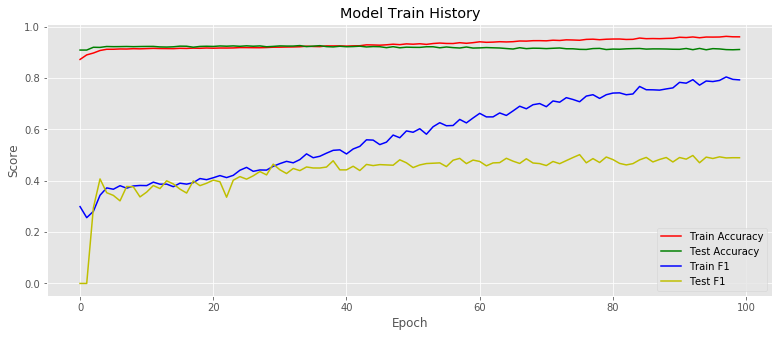

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,60.25,52.52,49.94,51.20,58.83,0.40,0.59,2330,1670
1,Dishwasher,99.05,0.00,0.00,0.00,49.76,0.01,0.50,3967,33
2,Furnace,97.88,4.41,13.04,6.59,52.76,0.02,0.56,3977,23
3,Wash Dryer 1,98.78,72.46,62.50,67.11,83.24,0.01,0.81,3920,80
4,Microwave,99.50,0.00,0.00,0.00,49.87,0.00,0.50,3981,19



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,91.09,25.88,25.1,24.98,58.89,0.09,0.59,3635.0,365.0
max,99.50,72.46,62.5,67.11,83.24,0.40,0.81,3981.0,1670.0
min,60.25,0.00,0.0,0.00,49.76,0.00,0.50,2330.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Refrigerator:
[[1576  754]
 [ 836  834]]

 - Dishwasher:
[[3962    5]
 [  33    0]]

 - Furnace:
[[3912   65]
 [  20    3]]

 - Wash Dryer 1:
[[3901   19]
 [  30   50]]

 - Microwave:
[[3980    1]
 [  19    0]]


In [146]:
# Model fit...
print("Training GAF multilabel model...")

multiabel_gaf_model = cnn_model()#vgg_model_multilabel()

callback = multiabel_gaf_model.fit(
    train_gaf_images, yb1_train,
    validation_data=(test_gaf_images, yb1_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2#, callbacks = [tqdm_callback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_gaf_model.predict(test_gaf_images).round())
classification_report(yb1_test, y_pred, labels = valid_appliances)

### RP

Training RP multilabel model...
Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 8s - loss: 0.4597 - acc: 0.9463 - f1_m: 0.5200 - val_loss: 0.2891 - val_acc: 0.9833 - val_f1_m: 0.4681
Epoch 2/100
4000/4000 - 7s - loss: 0.3828 - acc: 0.9507 - f1_m: 0.5237 - val_loss: 0.2334 - val_acc: 0.9833 - val_f1_m: 0.5630
Epoch 3/100
4000/4000 - 7s - loss: 0.3802 - acc: 0.9507 - f1_m: 0.5166 - val_loss: 0.3672 - val_acc: 0.9820 - val_f1_m: 0.3062
Epoch 4/100
4000/4000 - 7s - loss: 0.3729 - acc: 0.9490 - f1_m: 0.5224 - val_loss: 0.2653 - val_acc: 0.9827 - val_f1_m: 0.5232
Epoch 5/100
4000/4000 - 7s - loss: 0.3616 - acc: 0.9513 - f1_m: 0.5225 - val_loss: 0.2916 - val_acc: 0.9772 - val_f1_m: 0.4899
Epoch 6/100
4000/4000 - 7s - loss: 0.3499 - acc: 0.9465 - f1_m: 0.5202 - val_loss: 0.2275 - val_acc: 0.9808 - val_f1_m: 0.5289
Epoch 7/100
4000/4000 - 7s - loss: 0.3382 - acc: 0.9492 - f1_m: 0.5210 - val_loss: 0.3008 - val_acc: 0.9660 - val_f1_m: 0.5341
Epoch 8/100
4000/4000 - 7s - lo

Epoch 65/100
4000/4000 - 7s - loss: 0.1558 - acc: 0.9548 - f1_m: 0.5760 - val_loss: 0.2088 - val_acc: 0.9513 - val_f1_m: 0.5384
Epoch 66/100
4000/4000 - 7s - loss: 0.1541 - acc: 0.9545 - f1_m: 0.5766 - val_loss: 0.1746 - val_acc: 0.9665 - val_f1_m: 0.5547
Epoch 67/100
4000/4000 - 7s - loss: 0.1539 - acc: 0.9555 - f1_m: 0.5748 - val_loss: 0.1965 - val_acc: 0.9640 - val_f1_m: 0.5467
Epoch 68/100
4000/4000 - 7s - loss: 0.1518 - acc: 0.9578 - f1_m: 0.5781 - val_loss: 0.1815 - val_acc: 0.9643 - val_f1_m: 0.5532
Epoch 69/100
4000/4000 - 7s - loss: 0.1514 - acc: 0.9530 - f1_m: 0.5737 - val_loss: 0.2045 - val_acc: 0.9553 - val_f1_m: 0.5475
Epoch 70/100
4000/4000 - 7s - loss: 0.1546 - acc: 0.9557 - f1_m: 0.5769 - val_loss: 0.2042 - val_acc: 0.9575 - val_f1_m: 0.5444
Epoch 71/100
4000/4000 - 7s - loss: 0.1555 - acc: 0.9555 - f1_m: 0.5734 - val_loss: 0.1826 - val_acc: 0.9660 - val_f1_m: 0.5538
Epoch 72/100
4000/4000 - 7s - loss: 0.1445 - acc: 0.9592 - f1_m: 0.5806 - val_loss: 0.1892 - val_acc: 0.

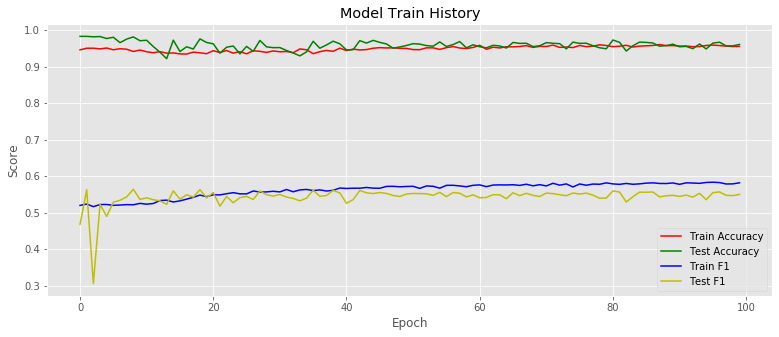

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,41.32,41.18,94.67,57.40,31.59,0.59,0.49,2330,1670
1,Dishwasher,99.05,0.00,0.00,0.00,49.76,0.01,0.50,3967,33
2,Furnace,97.75,2.82,8.70,4.26,51.56,0.02,0.53,3977,23
3,Wash Dryer 1,98.32,74.07,25.00,37.38,68.27,0.02,0.62,3920,80
4,Microwave,99.45,0.00,0.00,0.00,49.86,0.01,0.50,3981,19



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,87.18,23.61,25.67,19.81,50.21,0.13,0.53,3635.0,365.0
max,99.45,74.07,94.67,57.40,68.27,0.59,0.62,3981.0,1670.0
min,41.32,0.00,0.00,0.00,31.59,0.01,0.49,2330.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Refrigerator:
[[  72 2258]
 [  89 1581]]

 - Dishwasher:
[[3962    5]
 [  33    0]]

 - Furnace:
[[3908   69]
 [  21    2]]

 - Wash Dryer 1:
[[3913    7]
 [  60   20]]

 - Microwave:
[[3978    3]
 [  19    0]]


In [147]:
# Model fit...
print("Training RP multilabel model...")

multiabel_rp_model = tiled_cnn_model()#vgg_model_multilabel()

callback = multiabel_rp_model.fit(
    train_rp_images, yb1_train,
    validation_data=(test_rp_images, yb1_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2#, callbacks = [tqdm_callback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_rp_model.predict(test_rp_images).round())
classification_report(yb1_test, y_pred, labels = valid_appliances)

Training RP multilabel model...
Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 18s - loss: 0.5260 - accuracy: 0.8650 - f1_m: 0.4563 - val_loss: 0.2347 - val_accuracy: 0.9833 - val_f1_m: 0.5669
Epoch 2/100
4000/4000 - 18s - loss: 0.4473 - accuracy: 0.9392 - f1_m: 0.4919 - val_loss: 0.2234 - val_accuracy: 0.9833 - val_f1_m: 0.5686
Epoch 3/100
4000/4000 - 18s - loss: 0.4269 - accuracy: 0.9467 - f1_m: 0.5079 - val_loss: 0.2148 - val_accuracy: 0.9833 - val_f1_m: 0.5681
Epoch 4/100
4000/4000 - 18s - loss: 0.4191 - accuracy: 0.9488 - f1_m: 0.4996 - val_loss: 0.1997 - val_accuracy: 0.9833 - val_f1_m: 0.5673
Epoch 5/100
4000/4000 - 18s - loss: 0.4133 - accuracy: 0.9498 - f1_m: 0.5000 - val_loss: 0.1958 - val_accuracy: 0.9833 - val_f1_m: 0.5675
Epoch 6/100
4000/4000 - 18s - loss: 0.4153 - accuracy: 0.9503 - f1_m: 0.5037 - val_loss: 0.2062 - val_accuracy: 0.9833 - val_f1_m: 0.5622
Epoch 7/100
4000/4000 - 18s - loss: 0.4041 - accuracy: 0.9503 - f1_m: 0.5018 - val_loss: 0.1

Epoch 60/100
4000/4000 - 18s - loss: 0.3665 - accuracy: 0.9505 - f1_m: 0.5184 - val_loss: 0.1854 - val_accuracy: 0.9833 - val_f1_m: 0.5656
Epoch 61/100
4000/4000 - 18s - loss: 0.3687 - accuracy: 0.9505 - f1_m: 0.5212 - val_loss: 0.1814 - val_accuracy: 0.9833 - val_f1_m: 0.5660
Epoch 62/100
4000/4000 - 18s - loss: 0.3659 - accuracy: 0.9510 - f1_m: 0.5203 - val_loss: 0.1763 - val_accuracy: 0.9833 - val_f1_m: 0.5664
Epoch 63/100
4000/4000 - 18s - loss: 0.3651 - accuracy: 0.9507 - f1_m: 0.5171 - val_loss: 0.1799 - val_accuracy: 0.9833 - val_f1_m: 0.5642
Epoch 64/100
4000/4000 - 18s - loss: 0.3625 - accuracy: 0.9507 - f1_m: 0.5173 - val_loss: 0.1795 - val_accuracy: 0.9833 - val_f1_m: 0.5656
Epoch 65/100
4000/4000 - 18s - loss: 0.3632 - accuracy: 0.9495 - f1_m: 0.5201 - val_loss: 0.1801 - val_accuracy: 0.9833 - val_f1_m: 0.5650
Epoch 66/100
4000/4000 - 18s - loss: 0.3619 - accuracy: 0.9505 - f1_m: 0.5193 - val_loss: 0.1728 - val_accuracy: 0.9833 - val_f1_m: 0.5670
Epoch 67/100
4000/4000 - 18

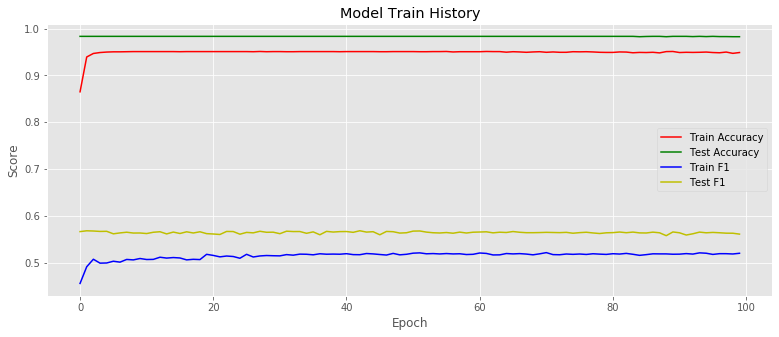

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,41.50,41.49,97.78,58.26,30.26,0.58,0.49,2330,1670
1,Dishwasher,99.18,0.00,0.00,0.00,49.79,0.01,0.50,3967,33
2,Furnace,99.42,0.00,0.00,0.00,49.86,0.01,0.50,3977,23
3,Wash Dryer 1,98.02,100.00,1.25,2.47,50.74,0.02,0.51,3920,80
4,Microwave,99.52,0.00,0.00,0.00,49.88,0.00,0.50,3981,19



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,87.53,28.3,19.81,12.15,46.11,0.12,0.50,3635.0,365.0
max,99.52,100.0,97.78,58.26,50.74,0.58,0.51,3981.0,1670.0
min,41.50,0.0,0.00,0.00,30.26,0.00,0.49,2330.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Refrigerator:
[[  27 2303]
 [  37 1633]]

 - Dishwasher:
[[3967    0]
 [  33    0]]

 - Furnace:
[[3977    0]
 [  23    0]]

 - Wash Dryer 1:
[[3920    0]
 [  79    1]]

 - Microwave:
[[3981    0]
 [  19    0]]


In [148]:
# Model fit...
print("Training RP multilabel model...")

multiabel_rp_model = vgg_model_multilabel()

callback = multiabel_rp_model.fit(
    train_rp_images, yb1_train,
    validation_data=(test_rp_images, yb1_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2#, callbacks = [tqdm_callback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_rp_model.predict(test_rp_images).round())
classification_report(yb1_test, y_pred, labels = valid_appliances)

Training RP multilabel model...
Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 6s - loss: 0.2989 - acc: 0.8690 - f1_m: 0.2855 - val_loss: 0.1831 - val_acc: 0.9088 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 6s - loss: 0.2447 - acc: 0.8929 - f1_m: 0.2271 - val_loss: 0.1752 - val_acc: 0.9088 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 6s - loss: 0.2332 - acc: 0.9025 - f1_m: 0.3145 - val_loss: 0.2006 - val_acc: 0.9229 - val_f1_m: 0.3969
Epoch 4/100
4000/4000 - 6s - loss: 0.2280 - acc: 0.9074 - f1_m: 0.3455 - val_loss: 0.1848 - val_acc: 0.9251 - val_f1_m: 0.3761
Epoch 5/100
4000/4000 - 6s - loss: 0.2243 - acc: 0.9109 - f1_m: 0.3678 - val_loss: 0.1698 - val_acc: 0.9240 - val_f1_m: 0.3991
Epoch 6/100
4000/4000 - 6s - loss: 0.2182 - acc: 0.9142 - f1_m: 0.4030 - val_loss: 0.1768 - val_acc: 0.9249 - val_f1_m: 0.4041
Epoch 7/100
4000/4000 - 6s - loss: 0.2194 - acc: 0.9145 - f1_m: 0.3959 - val_loss: 0.1816 - val_acc: 0.9217 - val_f1_m: 0.4193
Epoch 8/100
4000/4000 -

Epoch 65/100
4000/4000 - 6s - loss: 0.1304 - acc: 0.9406 - f1_m: 0.6639 - val_loss: 0.1764 - val_acc: 0.9237 - val_f1_m: 0.4924
Epoch 66/100
4000/4000 - 6s - loss: 0.1254 - acc: 0.9431 - f1_m: 0.6773 - val_loss: 0.1773 - val_acc: 0.9228 - val_f1_m: 0.5269
Epoch 67/100
4000/4000 - 6s - loss: 0.1275 - acc: 0.9415 - f1_m: 0.6677 - val_loss: 0.1761 - val_acc: 0.9207 - val_f1_m: 0.5416
Epoch 68/100
4000/4000 - 6s - loss: 0.1265 - acc: 0.9437 - f1_m: 0.6855 - val_loss: 0.1838 - val_acc: 0.9195 - val_f1_m: 0.5383
Epoch 69/100
4000/4000 - 6s - loss: 0.1241 - acc: 0.9438 - f1_m: 0.6912 - val_loss: 0.1815 - val_acc: 0.9215 - val_f1_m: 0.5184
Epoch 70/100
4000/4000 - 6s - loss: 0.1220 - acc: 0.9446 - f1_m: 0.6960 - val_loss: 0.1823 - val_acc: 0.9203 - val_f1_m: 0.5218
Epoch 71/100
4000/4000 - 6s - loss: 0.1207 - acc: 0.9450 - f1_m: 0.6995 - val_loss: 0.1859 - val_acc: 0.9216 - val_f1_m: 0.5062
Epoch 72/100
4000/4000 - 6s - loss: 0.1216 - acc: 0.9445 - f1_m: 0.6944 - val_loss: 0.1843 - val_acc: 0.

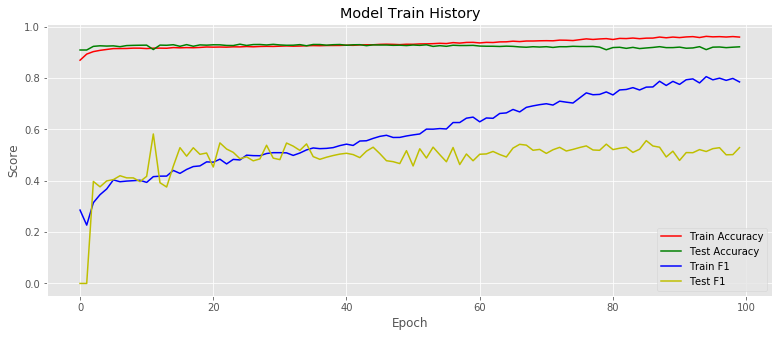

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,66.57,62.14,51.02,56.03,64.54,0.33,0.64,2330,1670
1,Dishwasher,99.00,0.00,0.00,0.00,49.75,0.01,0.50,3967,33
2,Furnace,96.90,3.67,17.39,6.06,52.24,0.03,0.57,3977,23
3,Wash Dryer 1,98.68,65.52,71.25,68.26,83.79,0.01,0.85,3920,80
4,Microwave,99.40,14.29,5.26,7.69,53.70,0.01,0.53,3981,19



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,92.11,29.12,28.98,27.61,60.80,0.08,0.62,3635.0,365.0
max,99.40,65.52,71.25,68.26,83.79,0.33,0.85,3981.0,1670.0
min,66.57,0.00,0.00,0.00,49.75,0.01,0.50,2330.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Refrigerator:
[[1811  519]
 [ 818  852]]

 - Dishwasher:
[[3960    7]
 [  33    0]]

 - Furnace:
[[3872  105]
 [  19    4]]

 - Wash Dryer 1:
[[3890   30]
 [  23   57]]

 - Microwave:
[[3975    6]
 [  18    1]]


In [149]:
# Model fit...
print("Training RP multilabel model...")

multiabel_rp_model = cnn_model()

callback = multiabel_rp_model.fit(
    train_rp_images, yb1_train,
    validation_data=(test_rp_images, yb1_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2#, callbacks = [tqdm_callback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_rp_model.predict(test_rp_images).round())
classification_report(yb1_test, y_pred, labels = valid_appliances)

## Classificadores Binários por Carga

In [71]:
from sklearn.metrics import confusion_matrix
def classification_report_appliance(y_test, y_pred, label = None):
    
    final_performance = []
    
    test = y_test
    predicted = y_pred
    #acc, prec, rec, f1, f1m, hl, supp = metrics(y_test[:, i], y_pred[:, i])
    acc = accuracy_score(test, predicted)
    prec = precision_score(test, predicted)
    rec = recall_score(test, predicted)    
    f1 = f1_score(test, predicted)
    f1m = f1_score(test, predicted, average='macro')
    hl = hamming_loss(test, predicted)   
    auc_ = roc_auc_score(test, predicted)
    y_i = y_test
    supp_0 = y_i[y_i==0].shape[0]
    supp_1 = y_i[y_i==1].shape[0]

    final_performance = [[
        label, 
        round(acc*100, 2), 
        round(prec*100, 2), 
        round(rec*100, 2), 
        round(f1*100, 2), 
        round(f1m*100, 2),
        round(hl, 2),
        round(auc_, 2),
        supp_0,
        supp_1
    ]]

    print("CLASSIFIER PERFORMANCE {} MODEL:".format(label.upper()))
    df_metrics = pd.DataFrame(
        data = final_performance,
        columns = ["Appliance", "Accuracy", "Precision", "Recall", "F1-score", "F1-macro", "Hamming Loss", "AUC", "Support (y=0)", "Support (y=1)"]
    )
    display(df_metrics)

#     print("")
#     print("OVERALL AVERAGE PERFORMANCE:")
#     display(df_metrics.describe().round(2).loc[['mean','max','min']])
    
    print("")
    print("CONFUSION MATRIX (OFF/ON):")
    
    cms = confusion_matrix(y_test, y_pred)
    for i, a in enumerate([label]):
        print("")
        print(" - {}:".format(a))
        print(cms)
        


def cnn_model_appliance(loss_function = 'binary_crossentropy'):
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss=[loss_function], metrics=['acc',f1_m])
    
    return model

### GAF

---> Training the `Refrigerator` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 18s - loss: 0.6434 - accuracy: 0.6730 - f1_m: 0.4588 - val_loss: 0.6882 - val_accuracy: 0.6665 - val_f1_m: 0.3805
Epoch 2/100
4000/4000 - 17s - loss: 0.6192 - accuracy: 0.6905 - f1_m: 0.4832 - val_loss: 0.6462 - val_accuracy: 0.6658 - val_f1_m: 0.3755
Epoch 3/100
4000/4000 - 17s - loss: 0.6107 - accuracy: 0.6933 - f1_m: 0.4873 - val_loss: 0.6228 - val_accuracy: 0.6683 - val_f1_m: 0.4215
Epoch 4/100
4000/4000 - 17s - loss: 0.6080 - accuracy: 0.6940 - f1_m: 0.4732 - val_loss: 0.6202 - val_accuracy: 0.6662 - val_f1_m: 0.4030
Epoch 5/100
4000/4000 - 18s - loss: 0.6033 - accuracy: 0.6938 - f1_m: 0.4793 - val_loss: 0.6155 - val_accuracy: 0.6680 - val_f1_m: 0.4347
Epoch 6/100
4000/4000 - 18s - loss: 0.6029 - accuracy: 0.6930 - f1_m: 0.4861 - val_loss: 0.6130 - val_accuracy: 0.6685 - val_f1_m: 0.4447
Epoch 7/100
4000/4000 - 18s - loss: 0.5963 - accuracy: 0.6950 - f1_m: 0.4883 - va

Epoch 60/100
4000/4000 - 18s - loss: 0.2866 - accuracy: 0.8698 - f1_m: 0.8254 - val_loss: 1.1407 - val_accuracy: 0.6385 - val_f1_m: 0.4563
Epoch 61/100
4000/4000 - 18s - loss: 0.3077 - accuracy: 0.8553 - f1_m: 0.8061 - val_loss: 1.2159 - val_accuracy: 0.6118 - val_f1_m: 0.5243
Epoch 62/100
4000/4000 - 18s - loss: 0.2708 - accuracy: 0.8755 - f1_m: 0.8299 - val_loss: 1.4010 - val_accuracy: 0.6075 - val_f1_m: 0.4876
Epoch 63/100
4000/4000 - 18s - loss: 0.2790 - accuracy: 0.8710 - f1_m: 0.8279 - val_loss: 1.3901 - val_accuracy: 0.5855 - val_f1_m: 0.4618
Epoch 64/100
4000/4000 - 18s - loss: 0.2814 - accuracy: 0.8692 - f1_m: 0.8241 - val_loss: 1.4370 - val_accuracy: 0.6102 - val_f1_m: 0.4325
Epoch 65/100
4000/4000 - 18s - loss: 0.2756 - accuracy: 0.8698 - f1_m: 0.8250 - val_loss: 1.3005 - val_accuracy: 0.6363 - val_f1_m: 0.4582
Epoch 66/100
4000/4000 - 18s - loss: 0.2606 - accuracy: 0.8820 - f1_m: 0.8439 - val_loss: 1.5996 - val_accuracy: 0.6310 - val_f1_m: 0.4819
Epoch 67/100
4000/4000 - 18

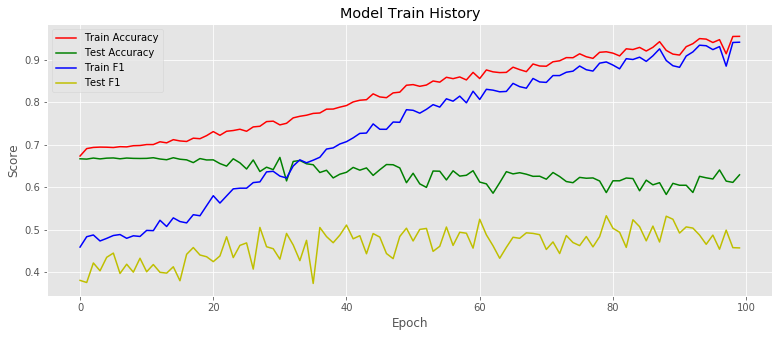

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,62.88,58.33,38.8,46.6,59.07,0.37,0.59,2330,1670



CONFUSION MATRIX (OFF/ON):

 - Refrigerator:
[[1867  463]
 [1022  648]]

---> Training the `Dishwasher` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 18s - loss: 0.0974 - accuracy: 0.9827 - f1_m: 0.0000e+00 - val_loss: 0.0486 - val_accuracy: 0.9918 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 18s - loss: 0.0779 - accuracy: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0552 - val_accuracy: 0.9918 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 18s - loss: 0.0737 - accuracy: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0705 - val_accuracy: 0.9918 - val_f1_m: 0.0000e+00
Epoch 4/100
4000/4000 - 18s - loss: 0.0729 - accuracy: 0.9830 - f1_m: 0.0000e+00 - val_loss: 0.0497 - val_accuracy: 0.9918 - val_f1_m: 0.0000e+00
Epoch 5/100
4000/4000 - 18s - loss: 0.0726 - accuracy: 0.9835 - f1_m: 0.0080 - val_loss: 0.0520 - val_accuracy: 0.9918 - val_f1_m: 0.0000e+00
Epoch 6/100
4000/4000 - 18s - loss: 0.0687 - accuracy: 0.9827 - f1_m: 0.0000e+00 - val_loss: 0.0487 - val_accur

Epoch 58/100
4000/4000 - 18s - loss: 0.0142 - accuracy: 0.9940 - f1_m: 0.3584 - val_loss: 0.0993 - val_accuracy: 0.9885 - val_f1_m: 0.0080
Epoch 59/100
4000/4000 - 18s - loss: 0.0176 - accuracy: 0.9945 - f1_m: 0.3467 - val_loss: 0.0858 - val_accuracy: 0.9877 - val_f1_m: 0.0000e+00
Epoch 60/100
4000/4000 - 18s - loss: 0.0135 - accuracy: 0.9958 - f1_m: 0.3360 - val_loss: 0.1041 - val_accuracy: 0.9858 - val_f1_m: 0.0160
Epoch 61/100
4000/4000 - 18s - loss: 0.0110 - accuracy: 0.9967 - f1_m: 0.3691 - val_loss: 0.1020 - val_accuracy: 0.9902 - val_f1_m: 0.0000e+00
Epoch 62/100
4000/4000 - 18s - loss: 0.0105 - accuracy: 0.9962 - f1_m: 0.3640 - val_loss: 0.1234 - val_accuracy: 0.9758 - val_f1_m: 0.0173
Epoch 63/100
4000/4000 - 18s - loss: 0.0115 - accuracy: 0.9965 - f1_m: 0.3747 - val_loss: 0.0997 - val_accuracy: 0.9872 - val_f1_m: 0.0000e+00
Epoch 64/100
4000/4000 - 18s - loss: 0.0086 - accuracy: 0.9977 - f1_m: 0.3667 - val_loss: 0.1183 - val_accuracy: 0.9822 - val_f1_m: 0.0107
Epoch 65/100
40

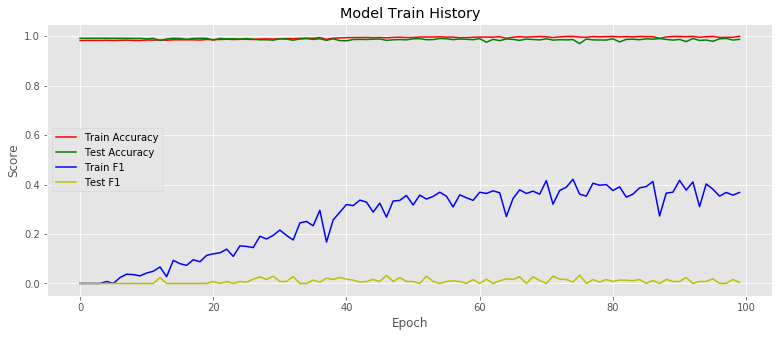

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Dishwasher,98.72,5.0,3.03,3.77,51.57,0.01,0.51,3967,33



CONFUSION MATRIX (OFF/ON):

 - Dishwasher:
[[3948   19]
 [  32    1]]

---> Training the `Furnace` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 18s - loss: 0.2151 - accuracy: 0.9410 - f1_m: 0.0000e+00 - val_loss: 0.0401 - val_accuracy: 0.9942 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 18s - loss: 0.1915 - accuracy: 0.9425 - f1_m: 0.0093 - val_loss: 0.1244 - val_accuracy: 0.9935 - val_f1_m: 0.0240
Epoch 3/100
4000/4000 - 18s - loss: 0.1839 - accuracy: 0.9433 - f1_m: 0.0469 - val_loss: 0.0990 - val_accuracy: 0.9937 - val_f1_m: 0.0160
Epoch 4/100
4000/4000 - 18s - loss: 0.1815 - accuracy: 0.9450 - f1_m: 0.0866 - val_loss: 0.0671 - val_accuracy: 0.9925 - val_f1_m: 0.0240
Epoch 5/100
4000/4000 - 18s - loss: 0.1782 - accuracy: 0.9457 - f1_m: 0.1074 - val_loss: 0.0747 - val_accuracy: 0.9883 - val_f1_m: 0.0347
Epoch 6/100
4000/4000 - 18s - loss: 0.1781 - accuracy: 0.9452 - f1_m: 0.1326 - val_loss: 0.0437 - val_accuracy: 0.9937 - val_f1_m: 0.0160
Epoch 

Epoch 59/100
4000/4000 - 18s - loss: 0.0544 - accuracy: 0.9808 - f1_m: 0.6520 - val_loss: 0.1518 - val_accuracy: 0.9503 - val_f1_m: 0.0453
Epoch 60/100
4000/4000 - 18s - loss: 0.0447 - accuracy: 0.9835 - f1_m: 0.6790 - val_loss: 0.1022 - val_accuracy: 0.9675 - val_f1_m: 0.0459
Epoch 61/100
4000/4000 - 18s - loss: 0.0444 - accuracy: 0.9847 - f1_m: 0.7626 - val_loss: 0.0847 - val_accuracy: 0.9772 - val_f1_m: 0.0480
Epoch 62/100
4000/4000 - 18s - loss: 0.0620 - accuracy: 0.9770 - f1_m: 0.5978 - val_loss: 0.1052 - val_accuracy: 0.9693 - val_f1_m: 0.0387
Epoch 63/100
4000/4000 - 18s - loss: 0.0478 - accuracy: 0.9825 - f1_m: 0.6973 - val_loss: 0.1526 - val_accuracy: 0.9563 - val_f1_m: 0.0424
Epoch 64/100
4000/4000 - 18s - loss: 0.0401 - accuracy: 0.9858 - f1_m: 0.6836 - val_loss: 0.1040 - val_accuracy: 0.9750 - val_f1_m: 0.0379
Epoch 65/100
4000/4000 - 18s - loss: 0.0573 - accuracy: 0.9783 - f1_m: 0.6296 - val_loss: 0.1856 - val_accuracy: 0.9480 - val_f1_m: 0.0376
Epoch 66/100
4000/4000 - 18

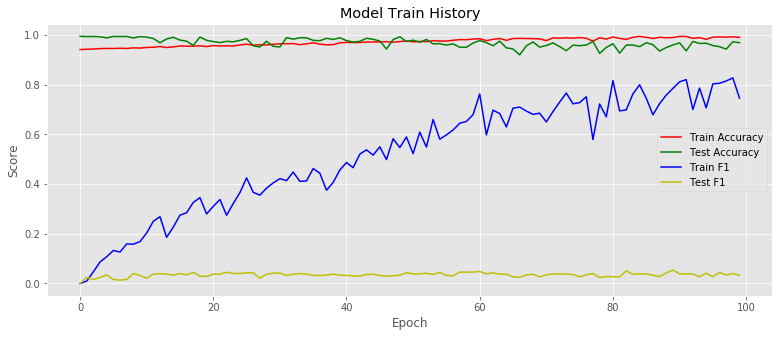

CLASSIFIER PERFORMANCE FURNACE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Furnace,96.88,5.26,26.09,8.76,53.58,0.03,0.62,3977,23



CONFUSION MATRIX (OFF/ON):

 - Furnace:
[[3869  108]
 [  17    6]]

---> Training the `Wash Dryer 1` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 18s - loss: 0.0877 - accuracy: 0.9670 - f1_m: 0.0816 - val_loss: 0.0411 - val_accuracy: 0.9847 - val_f1_m: 0.1261
Epoch 2/100
4000/4000 - 18s - loss: 0.0558 - accuracy: 0.9808 - f1_m: 0.2362 - val_loss: 0.0396 - val_accuracy: 0.9847 - val_f1_m: 0.1472
Epoch 3/100
4000/4000 - 18s - loss: 0.0610 - accuracy: 0.9785 - f1_m: 0.2922 - val_loss: 0.0361 - val_accuracy: 0.9872 - val_f1_m: 0.2219
Epoch 4/100
4000/4000 - 18s - loss: 0.0507 - accuracy: 0.9818 - f1_m: 0.3162 - val_loss: 0.0419 - val_accuracy: 0.9845 - val_f1_m: 0.1360
Epoch 5/100
4000/4000 - 18s - loss: 0.0474 - accuracy: 0.9820 - f1_m: 0.3257 - val_loss: 0.0413 - val_accuracy: 0.9858 - val_f1_m: 0.1776
Epoch 6/100
4000/4000 - 18s - loss: 0.0408 - accuracy: 0.9850 - f1_m: 0.4123 - val_loss: 0.0415 - val_accuracy: 0.9855 - val_f1_m: 0.1533
Epoch 7/100


Epoch 59/100
4000/4000 - 18s - loss: 0.0124 - accuracy: 0.9927 - f1_m: 0.4956 - val_loss: 0.0518 - val_accuracy: 0.9900 - val_f1_m: 0.3515
Epoch 60/100
4000/4000 - 18s - loss: 0.0161 - accuracy: 0.9915 - f1_m: 0.4921 - val_loss: 0.0493 - val_accuracy: 0.9895 - val_f1_m: 0.2741
Epoch 61/100
4000/4000 - 18s - loss: 0.0145 - accuracy: 0.9918 - f1_m: 0.4715 - val_loss: 0.0518 - val_accuracy: 0.9890 - val_f1_m: 0.2637
Epoch 62/100
4000/4000 - 18s - loss: 0.0158 - accuracy: 0.9930 - f1_m: 0.4982 - val_loss: 0.0480 - val_accuracy: 0.9890 - val_f1_m: 0.3131
Epoch 63/100
4000/4000 - 18s - loss: 0.0158 - accuracy: 0.9923 - f1_m: 0.5208 - val_loss: 0.0441 - val_accuracy: 0.9908 - val_f1_m: 0.3461
Epoch 64/100
4000/4000 - 18s - loss: 0.0135 - accuracy: 0.9942 - f1_m: 0.5065 - val_loss: 0.0540 - val_accuracy: 0.9900 - val_f1_m: 0.2653
Epoch 65/100
4000/4000 - 18s - loss: 0.0131 - accuracy: 0.9937 - f1_m: 0.5488 - val_loss: 0.0591 - val_accuracy: 0.9862 - val_f1_m: 0.3531
Epoch 66/100
4000/4000 - 18

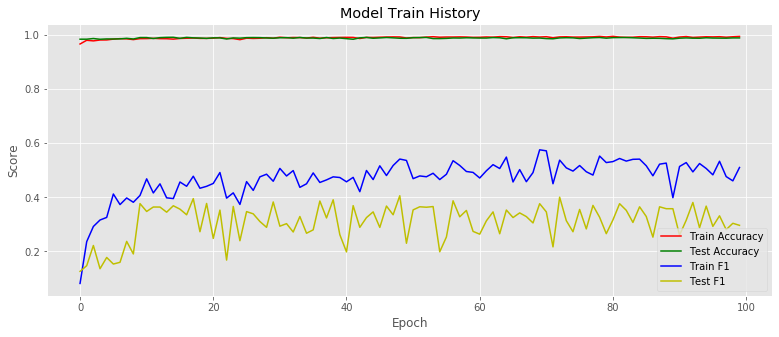

CLASSIFIER PERFORMANCE WASH DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Wash Dryer 1,98.95,82.76,60.0,69.57,84.52,0.01,0.8,3920,80



CONFUSION MATRIX (OFF/ON):

 - Wash Dryer 1:
[[3910   10]
 [  32   48]]

---> Training the `Microwave` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100


ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node block1_conv2_36/Conv2D (defined at <ipython-input-151-37183c96f09b>:12) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_4430394]

Function call stack:
keras_scratch_graph


In [151]:
# Model fit...
for i in range(yb1_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = vgg_model_appliance()
    
    # Calibrating model..
    callback = model.fit(
        train_gaf_images, yb1_train[:, i],
        validation_data=(test_gaf_images, yb1_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_gaf_images).round())
    classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

W1022 07:23:00.838338 14188 deprecation.py:323] From C:\Users\diego\anaconda3\envs\doutorado\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 20s - loss: 0.0709 - accuracy: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0349 - val_accuracy: 0.9952 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 18s - loss: 0.0503 - accuracy: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0212 - val_accuracy: 0.9952 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 18s - loss: 0.0464 - accuracy: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0194 - val_accuracy: 0.9952 - val_f1_m: 0.0000e+00
Epoch 4/100
4000/4000 - 18s - loss: 0.0469 - accuracy: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0202 - val_accuracy: 0.9952 - val_f1_m: 0.0000e+00
Epoch 5/100
4000/4000 - 18s - loss: 0.0437 - accuracy: 0.9887 - f1_m: 0.0000e+00 - val_loss: 0.0348 - val_accuracy: 0.9952 - val_f1_m: 0.0000e+00
Epoch 6/100
4000/4000 - 18s - loss: 0.0449 - accuracy: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0227 - val_accuracy: 0.9952 - val_f1_m: 0.0000e+00
Epoch 7/100
4000/4000 - 18s - loss: 0.0438 - accuracy: 0.9895 - f1_m: 0.0240

Epoch 60/100
4000/4000 - 18s - loss: 0.0127 - accuracy: 0.9960 - f1_m: 0.2227 - val_loss: 0.0389 - val_accuracy: 0.9952 - val_f1_m: 0.0080
Epoch 61/100
4000/4000 - 18s - loss: 0.0104 - accuracy: 0.9973 - f1_m: 0.2213 - val_loss: 0.0378 - val_accuracy: 0.9940 - val_f1_m: 0.0240
Epoch 62/100
4000/4000 - 18s - loss: 0.0086 - accuracy: 0.9967 - f1_m: 0.2453 - val_loss: 0.0389 - val_accuracy: 0.9948 - val_f1_m: 0.0160
Epoch 63/100
4000/4000 - 18s - loss: 0.0079 - accuracy: 0.9977 - f1_m: 0.2720 - val_loss: 0.0519 - val_accuracy: 0.9890 - val_f1_m: 0.0293
Epoch 64/100
4000/4000 - 18s - loss: 0.0062 - accuracy: 0.9977 - f1_m: 0.2480 - val_loss: 0.0492 - val_accuracy: 0.9948 - val_f1_m: 0.0080
Epoch 65/100
4000/4000 - 18s - loss: 0.0047 - accuracy: 0.9987 - f1_m: 0.2720 - val_loss: 0.0443 - val_accuracy: 0.9923 - val_f1_m: 0.0133
Epoch 66/100
4000/4000 - 18s - loss: 0.0047 - accuracy: 0.9983 - f1_m: 0.2987 - val_loss: 0.0537 - val_accuracy: 0.9950 - val_f1_m: 0.0080
Epoch 67/100
4000/4000 - 18

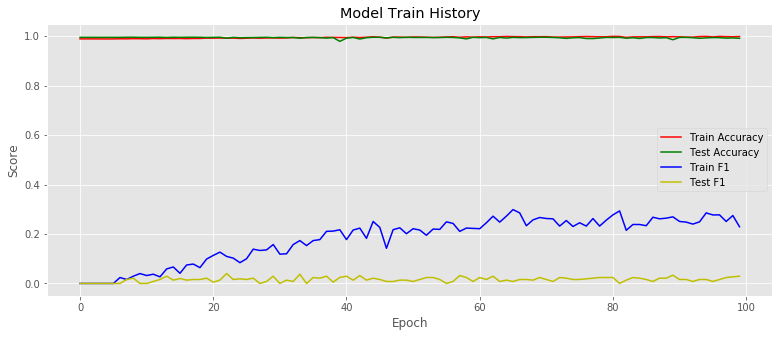

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Microwave,99.12,16.67,21.05,18.6,59.08,0.01,0.6,3981,19



CONFUSION MATRIX (OFF/ON):

 - Microwave:
[[3961   20]
 [  15    4]]



In [12]:
i = 4
model = vgg_model_appliance()

# Calibrating model..
callback = model.fit(
    train_gaf_images, yb1_train[:, i],
    validation_data=(test_gaf_images, yb1_test[:, i]), 
    epochs=100, batch_size=32,
    verbose = 2#, callbacks = [tqdm_callback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(model.predict(test_gaf_images).round())
classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])

print("")

---> Training the `Refrigerator` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 7s - loss: 0.6665 - acc: 0.6273 - f1_m: 0.2625 - val_loss: 0.6564 - val_acc: 0.6265 - val_f1_m: 0.3911
Epoch 2/100
4000/4000 - 6s - loss: 0.6435 - acc: 0.6683 - f1_m: 0.3949 - val_loss: 0.6515 - val_acc: 0.6378 - val_f1_m: 0.3757
Epoch 3/100
4000/4000 - 6s - loss: 0.6374 - acc: 0.6747 - f1_m: 0.4288 - val_loss: 0.6528 - val_acc: 0.6490 - val_f1_m: 0.3656
Epoch 4/100
4000/4000 - 6s - loss: 0.6384 - acc: 0.6722 - f1_m: 0.4279 - val_loss: 0.6544 - val_acc: 0.6403 - val_f1_m: 0.3809
Epoch 5/100
4000/4000 - 6s - loss: 0.6315 - acc: 0.6758 - f1_m: 0.4364 - val_loss: 0.6443 - val_acc: 0.6445 - val_f1_m: 0.3334
Epoch 6/100
4000/4000 - 6s - loss: 0.6294 - acc: 0.6820 - f1_m: 0.4371 - val_loss: 0.6511 - val_acc: 0.6375 - val_f1_m: 0.4279
Epoch 7/100
4000/4000 - 6s - loss: 0.6225 - acc: 0.6798 - f1_m: 0.4510 - val_loss: 0.6537 - val_acc: 0.6538 - val_f1_m: 0.3674
Epoch 8/100
4000/400

Epoch 65/100
4000/4000 - 6s - loss: 0.3341 - acc: 0.8595 - f1_m: 0.8213 - val_loss: 0.8643 - val_acc: 0.6155 - val_f1_m: 0.5048
Epoch 66/100
4000/4000 - 6s - loss: 0.3321 - acc: 0.8560 - f1_m: 0.8169 - val_loss: 0.8448 - val_acc: 0.6310 - val_f1_m: 0.5032
Epoch 67/100
4000/4000 - 6s - loss: 0.3217 - acc: 0.8648 - f1_m: 0.8285 - val_loss: 0.9058 - val_acc: 0.6250 - val_f1_m: 0.4808
Epoch 68/100
4000/4000 - 6s - loss: 0.3351 - acc: 0.8525 - f1_m: 0.8108 - val_loss: 0.8157 - val_acc: 0.6208 - val_f1_m: 0.5103
Epoch 69/100
4000/4000 - 6s - loss: 0.3108 - acc: 0.8658 - f1_m: 0.8295 - val_loss: 0.8840 - val_acc: 0.6300 - val_f1_m: 0.5080
Epoch 70/100
4000/4000 - 6s - loss: 0.2999 - acc: 0.8752 - f1_m: 0.8419 - val_loss: 0.9006 - val_acc: 0.6175 - val_f1_m: 0.4949
Epoch 71/100
4000/4000 - 6s - loss: 0.3015 - acc: 0.8725 - f1_m: 0.8386 - val_loss: 0.9041 - val_acc: 0.6240 - val_f1_m: 0.5016
Epoch 72/100
4000/4000 - 6s - loss: 0.3186 - acc: 0.8625 - f1_m: 0.8229 - val_loss: 0.8701 - val_acc: 0.

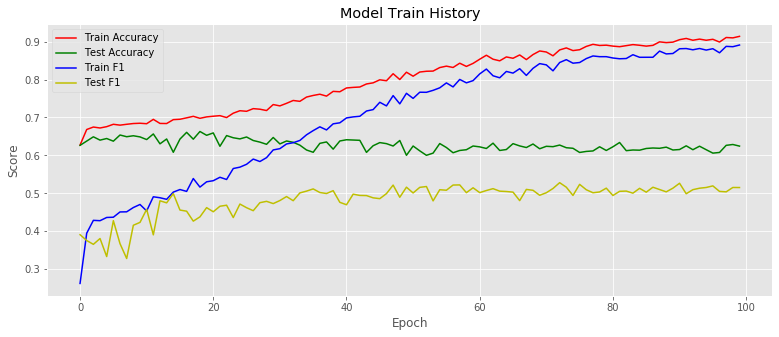

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,62.45,55.58,50.12,52.71,60.79,0.38,0.61,2330,1670



CONFUSION MATRIX (OFF/ON):

 - Refrigerator:
[[1661  669]
 [ 833  837]]

---> Training the `Dishwasher` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 7s - loss: 0.2727 - acc: 0.9768 - f1_m: 0.0000e+00 - val_loss: 0.1273 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 6s - loss: 0.2634 - acc: 0.9827 - f1_m: 0.0000e+00 - val_loss: 0.1273 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 6s - loss: 0.1417 - acc: 0.9830 - f1_m: 0.0000e+00 - val_loss: 0.0507 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 4/100
4000/4000 - 6s - loss: 0.1042 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0749 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 5/100
4000/4000 - 6s - loss: 0.1035 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0521 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 6/100
4000/4000 - 6s - loss: 0.1030 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0567 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 7/100
4000/4000 - 6s 

Epoch 62/100
4000/4000 - 6s - loss: 0.0462 - acc: 0.9868 - f1_m: 0.1133 - val_loss: 0.0932 - val_acc: 0.9900 - val_f1_m: 0.0000e+00
Epoch 63/100
4000/4000 - 6s - loss: 0.0450 - acc: 0.9860 - f1_m: 0.0987 - val_loss: 0.0787 - val_acc: 0.9905 - val_f1_m: 0.0000e+00
Epoch 64/100
4000/4000 - 6s - loss: 0.0411 - acc: 0.9877 - f1_m: 0.1467 - val_loss: 0.0821 - val_acc: 0.9895 - val_f1_m: 0.0000e+00
Epoch 65/100
4000/4000 - 6s - loss: 0.0384 - acc: 0.9880 - f1_m: 0.1411 - val_loss: 0.0912 - val_acc: 0.9902 - val_f1_m: 0.0000e+00
Epoch 66/100
4000/4000 - 6s - loss: 0.0348 - acc: 0.9872 - f1_m: 0.1440 - val_loss: 0.0974 - val_acc: 0.9885 - val_f1_m: 0.0000e+00
Epoch 67/100
4000/4000 - 6s - loss: 0.0367 - acc: 0.9893 - f1_m: 0.1845 - val_loss: 0.0934 - val_acc: 0.9880 - val_f1_m: 0.0080
Epoch 68/100
4000/4000 - 6s - loss: 0.0328 - acc: 0.9902 - f1_m: 0.2373 - val_loss: 0.0858 - val_acc: 0.9870 - val_f1_m: 0.0000e+00
Epoch 69/100
4000/4000 - 6s - loss: 0.0380 - acc: 0.9890 - f1_m: 0.2024 - val_lo

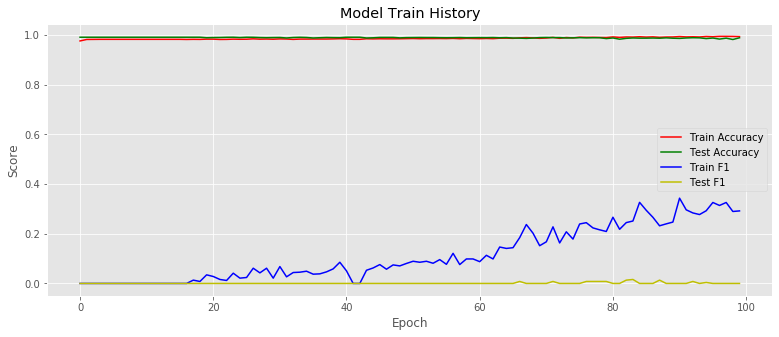

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Dishwasher,98.95,0.0,0.0,0.0,49.74,0.01,0.5,3967,33



CONFUSION MATRIX (OFF/ON):

 - Dishwasher:
[[3958    9]
 [  33    0]]

---> Training the `Furnace` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 7s - loss: 0.2710 - acc: 0.9350 - f1_m: 0.0000e+00 - val_loss: 0.1421 - val_acc: 0.9942 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 6s - loss: 0.2306 - acc: 0.9420 - f1_m: 0.0000e+00 - val_loss: 0.1798 - val_acc: 0.9942 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 6s - loss: 0.2320 - acc: 0.9420 - f1_m: 0.0000e+00 - val_loss: 0.1065 - val_acc: 0.9942 - val_f1_m: 0.0000e+00
Epoch 4/100
4000/4000 - 6s - loss: 0.2328 - acc: 0.9420 - f1_m: 0.0000e+00 - val_loss: 0.0970 - val_acc: 0.9942 - val_f1_m: 0.0000e+00
Epoch 5/100
4000/4000 - 6s - loss: 0.2174 - acc: 0.9420 - f1_m: 0.0000e+00 - val_loss: 0.0981 - val_acc: 0.9942 - val_f1_m: 0.0000e+00
Epoch 6/100
4000/4000 - 6s - loss: 0.2243 - acc: 0.9420 - f1_m: 0.0000e+00 - val_loss: 0.0680 - val_acc: 0.9942 - val_f1_m: 0.0000e+00
Epoch 7/100
4000/4000 - 6s - los

Epoch 63/100
4000/4000 - 6s - loss: 0.0790 - acc: 0.9715 - f1_m: 0.5592 - val_loss: 0.0676 - val_acc: 0.9877 - val_f1_m: 0.0133
Epoch 64/100
4000/4000 - 6s - loss: 0.0862 - acc: 0.9703 - f1_m: 0.5184 - val_loss: 0.0708 - val_acc: 0.9855 - val_f1_m: 0.0107
Epoch 65/100
4000/4000 - 7s - loss: 0.0878 - acc: 0.9675 - f1_m: 0.4615 - val_loss: 0.0767 - val_acc: 0.9875 - val_f1_m: 0.0160
Epoch 66/100
4000/4000 - 6s - loss: 0.0838 - acc: 0.9705 - f1_m: 0.5675 - val_loss: 0.0717 - val_acc: 0.9877 - val_f1_m: 0.0160
Epoch 67/100
4000/4000 - 6s - loss: 0.0830 - acc: 0.9695 - f1_m: 0.5053 - val_loss: 0.0827 - val_acc: 0.9845 - val_f1_m: 0.0133
Epoch 68/100
4000/4000 - 6s - loss: 0.0724 - acc: 0.9730 - f1_m: 0.5398 - val_loss: 0.0779 - val_acc: 0.9858 - val_f1_m: 0.0160
Epoch 69/100
4000/4000 - 6s - loss: 0.0920 - acc: 0.9665 - f1_m: 0.4590 - val_loss: 0.0915 - val_acc: 0.9858 - val_f1_m: 0.0267
Epoch 70/100
4000/4000 - 6s - loss: 0.0786 - acc: 0.9710 - f1_m: 0.5035 - val_loss: 0.0931 - val_acc: 0.

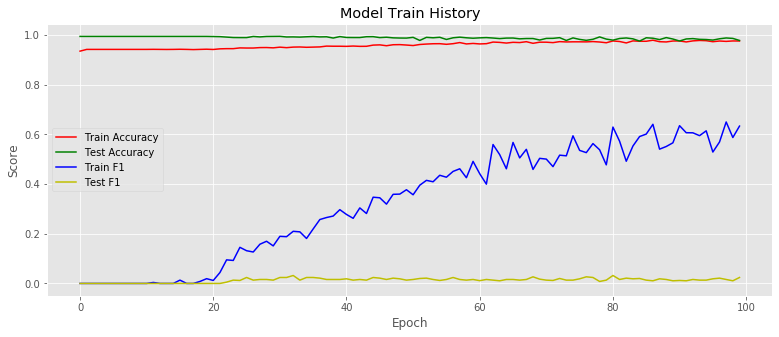

CLASSIFIER PERFORMANCE FURNACE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Furnace,97.8,4.23,13.04,6.38,52.63,0.02,0.56,3977,23



CONFUSION MATRIX (OFF/ON):

 - Furnace:
[[3909   68]
 [  20    3]]

---> Training the `Wash Dryer 1` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 7s - loss: 0.1697 - acc: 0.9670 - f1_m: 0.0000e+00 - val_loss: 0.0977 - val_acc: 0.9800 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 6s - loss: 0.1154 - acc: 0.9728 - f1_m: 0.0000e+00 - val_loss: 0.0888 - val_acc: 0.9800 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 6s - loss: 0.1140 - acc: 0.9728 - f1_m: 0.0000e+00 - val_loss: 0.1256 - val_acc: 0.9800 - val_f1_m: 0.0000e+00
Epoch 4/100
4000/4000 - 6s - loss: 0.1017 - acc: 0.9728 - f1_m: 0.0000e+00 - val_loss: 0.0612 - val_acc: 0.9800 - val_f1_m: 0.0000e+00
Epoch 5/100
4000/4000 - 6s - loss: 0.0930 - acc: 0.9728 - f1_m: 0.0000e+00 - val_loss: 0.0626 - val_acc: 0.9800 - val_f1_m: 0.0000e+00
Epoch 6/100
4000/4000 - 6s - loss: 0.0954 - acc: 0.9728 - f1_m: 0.0000e+00 - val_loss: 0.0579 - val_acc: 0.9800 - val_f1_m: 0.0000e+00
Epoch 7/100
4000/4000 - 6s - l

Epoch 64/100
4000/4000 - 6s - loss: 0.0340 - acc: 0.9865 - f1_m: 0.4066 - val_loss: 0.0545 - val_acc: 0.9877 - val_f1_m: 0.2789
Epoch 65/100
4000/4000 - 6s - loss: 0.0216 - acc: 0.9893 - f1_m: 0.4348 - val_loss: 0.0587 - val_acc: 0.9860 - val_f1_m: 0.2338
Epoch 66/100
4000/4000 - 6s - loss: 0.0220 - acc: 0.9905 - f1_m: 0.4367 - val_loss: 0.0562 - val_acc: 0.9895 - val_f1_m: 0.3477
Epoch 67/100
4000/4000 - 6s - loss: 0.0328 - acc: 0.9875 - f1_m: 0.4315 - val_loss: 0.0544 - val_acc: 0.9877 - val_f1_m: 0.2261
Epoch 68/100
4000/4000 - 6s - loss: 0.0275 - acc: 0.9885 - f1_m: 0.4106 - val_loss: 0.0634 - val_acc: 0.9855 - val_f1_m: 0.2656
Epoch 69/100
4000/4000 - 6s - loss: 0.0252 - acc: 0.9877 - f1_m: 0.4307 - val_loss: 0.0587 - val_acc: 0.9895 - val_f1_m: 0.3028
Epoch 70/100
4000/4000 - 6s - loss: 0.0207 - acc: 0.9895 - f1_m: 0.4584 - val_loss: 0.0535 - val_acc: 0.9898 - val_f1_m: 0.2832
Epoch 71/100
4000/4000 - 6s - loss: 0.0221 - acc: 0.9900 - f1_m: 0.4269 - val_loss: 0.0577 - val_acc: 0.

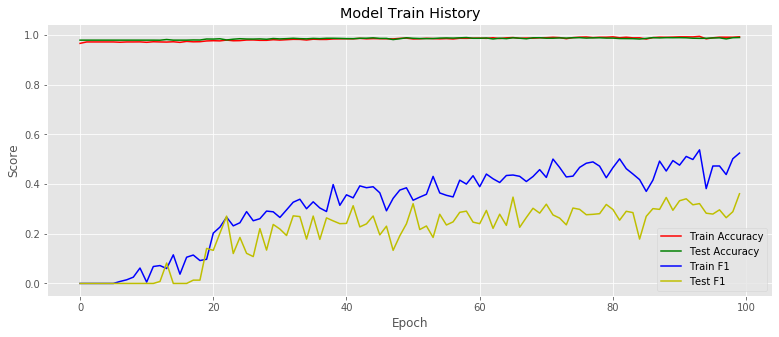

CLASSIFIER PERFORMANCE WASH DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Wash Dryer 1,99.05,79.17,71.25,75.0,87.26,0.01,0.85,3920,80



CONFUSION MATRIX (OFF/ON):

 - Wash Dryer 1:
[[3905   15]
 [  23   57]]

---> Training the `Microwave` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 6s - loss: 0.1081 - acc: 0.9827 - f1_m: 0.0000e+00 - val_loss: 0.0327 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 6s - loss: 0.0739 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0430 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 6s - loss: 0.0782 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0504 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 4/100
4000/4000 - 6s - loss: 0.1336 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 5/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 6/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 7/100
4000/4000 - 6s -

Epoch 61/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 62/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 63/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 64/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 65/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 66/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 67/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 68/100
4000/4000 - 6s - loss: 0.1697 - acc

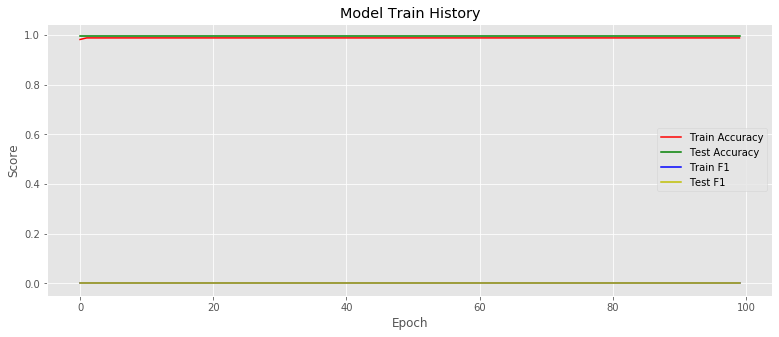

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Microwave,99.52,0.0,0.0,0.0,49.88,0.0,0.5,3981,19



CONFUSION MATRIX (OFF/ON):

 - Microwave:
[[3981    0]
 [  19    0]]



In [13]:
# Model fit...
for i in range(yb1_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = cnn_model_appliance()
    
    # Calibrating model..
    callback = model.fit(
        train_gaf_images, yb1_train[:, i],
        validation_data=(test_gaf_images, yb1_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_gaf_images).round())
    classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

### RP

Training the `Refrigerator` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 19s - loss: 0.6376 - accuracy: 0.6740 - f1_m: 0.4733 - val_loss: 0.6511 - val_accuracy: 0.6755 - val_f1_m: 0.4200
Epoch 2/100
4000/4000 - 18s - loss: 0.6074 - accuracy: 0.6960 - f1_m: 0.5068 - val_loss: 0.6286 - val_accuracy: 0.6817 - val_f1_m: 0.4400
Epoch 3/100
4000/4000 - 18s - loss: 0.6011 - accuracy: 0.6988 - f1_m: 0.5079 - val_loss: 0.6210 - val_accuracy: 0.6820 - val_f1_m: 0.4375
Epoch 4/100
4000/4000 - 18s - loss: 0.5954 - accuracy: 0.7005 - f1_m: 0.5150 - val_loss: 0.6126 - val_accuracy: 0.6755 - val_f1_m: 0.4702
Epoch 5/100
4000/4000 - 18s - loss: 0.5929 - accuracy: 0.7065 - f1_m: 0.5233 - val_loss: 0.6100 - val_accuracy: 0.6823 - val_f1_m: 0.4604
Epoch 6/100
4000/4000 - 18s - loss: 0.5855 - accuracy: 0.7088 - f1_m: 0.5250 - val_loss: 0.6133 - val_accuracy: 0.6675 - val_f1_m: 0.5026
Epoch 7/100
4000/4000 - 18s - loss: 0.5843 - accuracy: 0.7105 - f1_m: 0.5459 - val_los

Epoch 60/100
4000/4000 - 18s - loss: 0.2749 - accuracy: 0.8763 - f1_m: 0.8389 - val_loss: 1.2693 - val_accuracy: 0.6472 - val_f1_m: 0.5412
Epoch 61/100
4000/4000 - 18s - loss: 0.2819 - accuracy: 0.8708 - f1_m: 0.8277 - val_loss: 1.2916 - val_accuracy: 0.6550 - val_f1_m: 0.4923
Epoch 62/100
4000/4000 - 18s - loss: 0.2793 - accuracy: 0.8690 - f1_m: 0.8273 - val_loss: 1.5062 - val_accuracy: 0.6568 - val_f1_m: 0.3975
Epoch 63/100
4000/4000 - 18s - loss: 0.2697 - accuracy: 0.8773 - f1_m: 0.8400 - val_loss: 1.3269 - val_accuracy: 0.6200 - val_f1_m: 0.5428
Epoch 64/100
4000/4000 - 18s - loss: 0.2518 - accuracy: 0.8860 - f1_m: 0.8543 - val_loss: 1.1820 - val_accuracy: 0.6295 - val_f1_m: 0.5218
Epoch 65/100
4000/4000 - 18s - loss: 0.2373 - accuracy: 0.8920 - f1_m: 0.8591 - val_loss: 1.5039 - val_accuracy: 0.6420 - val_f1_m: 0.4904
Epoch 66/100
4000/4000 - 18s - loss: 0.2532 - accuracy: 0.8848 - f1_m: 0.8506 - val_loss: 1.4937 - val_accuracy: 0.6465 - val_f1_m: 0.4443
Epoch 67/100
4000/4000 - 18

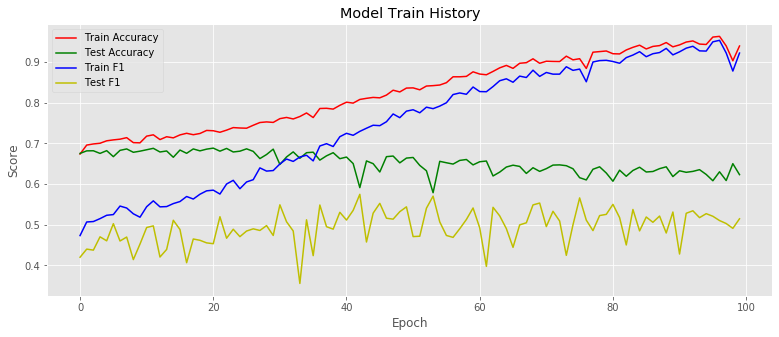

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,62.32,55.45,49.64,52.39,60.61,0.38,0.61,2330,1670



CONFUSION MATRIX (OFF/ON):

 - Refrigerator:
[[1664  666]
 [ 841  829]]

Training the `Dishwasher` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 18s - loss: 0.0981 - accuracy: 0.9753 - f1_m: 0.0000e+00 - val_loss: 0.0481 - val_accuracy: 0.9918 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 18s - loss: 0.0802 - accuracy: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0655 - val_accuracy: 0.9918 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 18s - loss: 0.0758 - accuracy: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0540 - val_accuracy: 0.9918 - val_f1_m: 0.0000e+00
Epoch 4/100
4000/4000 - 18s - loss: 0.0708 - accuracy: 0.9835 - f1_m: 0.0267 - val_loss: 0.0588 - val_accuracy: 0.9918 - val_f1_m: 0.0000e+00
Epoch 5/100
4000/4000 - 18s - loss: 0.0696 - accuracy: 0.9827 - f1_m: 0.0160 - val_loss: 0.0526 - val_accuracy: 0.9918 - val_f1_m: 0.0000e+00
Epoch 6/100
4000/4000 - 18s - loss: 0.0687 - accuracy: 0.9833 - f1_m: 0.0187 - val_loss: 0.0607 - val_accuracy: 0.9895 -

Epoch 58/100
4000/4000 - 18s - loss: 0.0130 - accuracy: 0.9967 - f1_m: 0.3195 - val_loss: 0.1014 - val_accuracy: 0.9868 - val_f1_m: 0.0000e+00
Epoch 59/100
4000/4000 - 18s - loss: 0.0106 - accuracy: 0.9970 - f1_m: 0.3691 - val_loss: 0.1020 - val_accuracy: 0.9900 - val_f1_m: 0.0000e+00
Epoch 60/100
4000/4000 - 18s - loss: 0.0118 - accuracy: 0.9967 - f1_m: 0.3840 - val_loss: 0.1110 - val_accuracy: 0.9860 - val_f1_m: 0.0000e+00
Epoch 61/100
4000/4000 - 18s - loss: 0.0177 - accuracy: 0.9942 - f1_m: 0.2997 - val_loss: 0.1081 - val_accuracy: 0.9833 - val_f1_m: 0.0000e+00
Epoch 62/100
4000/4000 - 18s - loss: 0.0217 - accuracy: 0.9937 - f1_m: 0.2940 - val_loss: 0.1103 - val_accuracy: 0.9858 - val_f1_m: 0.0000e+00
Epoch 63/100
4000/4000 - 18s - loss: 0.0153 - accuracy: 0.9948 - f1_m: 0.2739 - val_loss: 0.1016 - val_accuracy: 0.9887 - val_f1_m: 0.0000e+00
Epoch 64/100
4000/4000 - 18s - loss: 0.0128 - accuracy: 0.9962 - f1_m: 0.3293 - val_loss: 0.1358 - val_accuracy: 0.9720 - val_f1_m: 0.0080
Epo

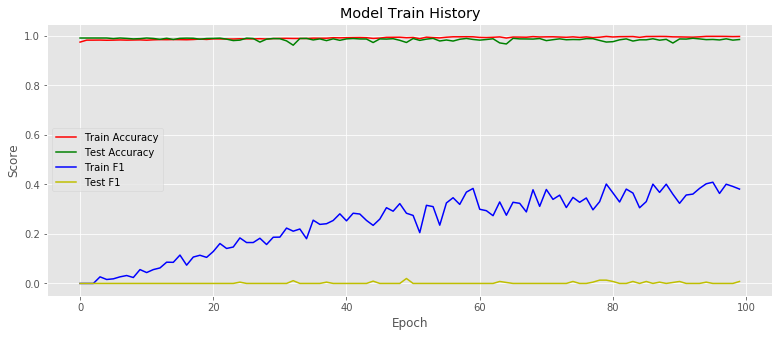

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Dishwasher,98.58,3.85,3.03,3.39,51.34,0.01,0.51,3967,33



CONFUSION MATRIX (OFF/ON):

 - Dishwasher:
[[3942   25]
 [  32    1]]

Training the `Furnace` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 18s - loss: 0.2041 - accuracy: 0.9420 - f1_m: 0.0000e+00 - val_loss: 0.0521 - val_accuracy: 0.9942 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 18s - loss: 0.1879 - accuracy: 0.9417 - f1_m: 0.0394 - val_loss: 0.0346 - val_accuracy: 0.9942 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 18s - loss: 0.1797 - accuracy: 0.9450 - f1_m: 0.0563 - val_loss: 0.0414 - val_accuracy: 0.9945 - val_f1_m: 0.0160
Epoch 4/100
4000/4000 - 18s - loss: 0.1763 - accuracy: 0.9450 - f1_m: 0.1355 - val_loss: 0.0853 - val_accuracy: 0.9910 - val_f1_m: 0.0267
Epoch 5/100
4000/4000 - 18s - loss: 0.1691 - accuracy: 0.9465 - f1_m: 0.1208 - val_loss: 0.0642 - val_accuracy: 0.9945 - val_f1_m: 0.0240
Epoch 6/100
4000/4000 - 18s - loss: 0.1685 - accuracy: 0.9495 - f1_m: 0.1766 - val_loss: 0.0737 - val_accuracy: 0.9908 - val_f1_m: 0.0400
Epoch 7

Epoch 59/100
4000/4000 - 18s - loss: 0.0736 - accuracy: 0.9745 - f1_m: 0.5784 - val_loss: 0.0986 - val_accuracy: 0.9785 - val_f1_m: 0.0272
Epoch 60/100
4000/4000 - 18s - loss: 0.0527 - accuracy: 0.9805 - f1_m: 0.6093 - val_loss: 0.1201 - val_accuracy: 0.9718 - val_f1_m: 0.0293
Epoch 61/100
4000/4000 - 18s - loss: 0.0435 - accuracy: 0.9835 - f1_m: 0.6242 - val_loss: 0.1684 - val_accuracy: 0.9628 - val_f1_m: 0.0312
Epoch 62/100
4000/4000 - 18s - loss: 0.0460 - accuracy: 0.9818 - f1_m: 0.6560 - val_loss: 0.1774 - val_accuracy: 0.9630 - val_f1_m: 0.0413
Epoch 63/100
4000/4000 - 18s - loss: 0.0503 - accuracy: 0.9815 - f1_m: 0.6538 - val_loss: 0.1719 - val_accuracy: 0.9563 - val_f1_m: 0.0352
Epoch 64/100
4000/4000 - 18s - loss: 0.0437 - accuracy: 0.9833 - f1_m: 0.6710 - val_loss: 0.0996 - val_accuracy: 0.9785 - val_f1_m: 0.0347
Epoch 65/100
4000/4000 - 18s - loss: 0.0511 - accuracy: 0.9820 - f1_m: 0.6663 - val_loss: 0.3265 - val_accuracy: 0.9352 - val_f1_m: 0.0349
Epoch 66/100
4000/4000 - 18

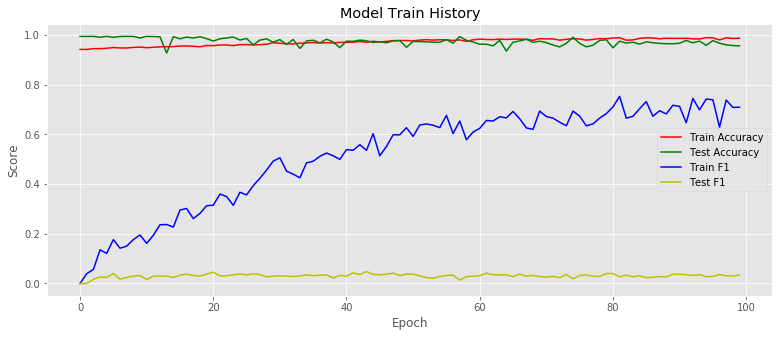

CLASSIFIER PERFORMANCE FURNACE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Furnace,95.62,3.66,26.09,6.42,52.09,0.04,0.61,3977,23



CONFUSION MATRIX (OFF/ON):

 - Furnace:
[[3819  158]
 [  17    6]]

Training the `Wash Dryer 1` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 18s - loss: 0.0972 - accuracy: 0.9653 - f1_m: 4.8485e-04 - val_loss: 0.0502 - val_accuracy: 0.9800 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 18s - loss: 0.0682 - accuracy: 0.9778 - f1_m: 0.1704 - val_loss: 0.0418 - val_accuracy: 0.9850 - val_f1_m: 0.1720
Epoch 3/100
4000/4000 - 18s - loss: 0.0611 - accuracy: 0.9797 - f1_m: 0.2297 - val_loss: 0.0432 - val_accuracy: 0.9885 - val_f1_m: 0.2418
Epoch 4/100
4000/4000 - 18s - loss: 0.0539 - accuracy: 0.9793 - f1_m: 0.2761 - val_loss: 0.0343 - val_accuracy: 0.9908 - val_f1_m: 0.3211
Epoch 5/100
4000/4000 - 18s - loss: 0.0498 - accuracy: 0.9815 - f1_m: 0.3303 - val_loss: 0.0343 - val_accuracy: 0.9890 - val_f1_m: 0.2677
Epoch 6/100
4000/4000 - 18s - loss: 0.0529 - accuracy: 0.9825 - f1_m: 0.3215 - val_loss: 0.0568 - val_accuracy: 0.9740 - val_f1_m: 0.3759
Epoch 7/1

Epoch 59/100
4000/4000 - 18s - loss: 0.0144 - accuracy: 0.9930 - f1_m: 0.4919 - val_loss: 0.0451 - val_accuracy: 0.9905 - val_f1_m: 0.3264
Epoch 60/100
4000/4000 - 18s - loss: 0.0157 - accuracy: 0.9918 - f1_m: 0.5199 - val_loss: 0.0459 - val_accuracy: 0.9898 - val_f1_m: 0.3800
Epoch 61/100
4000/4000 - 18s - loss: 0.0132 - accuracy: 0.9925 - f1_m: 0.5194 - val_loss: 0.0481 - val_accuracy: 0.9900 - val_f1_m: 0.3456
Epoch 62/100
4000/4000 - 18s - loss: 0.0165 - accuracy: 0.9920 - f1_m: 0.5021 - val_loss: 0.0470 - val_accuracy: 0.9908 - val_f1_m: 0.3184
Epoch 63/100
4000/4000 - 18s - loss: 0.0142 - accuracy: 0.9925 - f1_m: 0.4914 - val_loss: 0.0490 - val_accuracy: 0.9885 - val_f1_m: 0.2210
Epoch 64/100
4000/4000 - 18s - loss: 0.0360 - accuracy: 0.9875 - f1_m: 0.4629 - val_loss: 0.0603 - val_accuracy: 0.9793 - val_f1_m: 0.3535
Epoch 65/100
4000/4000 - 18s - loss: 0.0255 - accuracy: 0.9905 - f1_m: 0.4677 - val_loss: 0.0453 - val_accuracy: 0.9885 - val_f1_m: 0.2387
Epoch 66/100
4000/4000 - 18

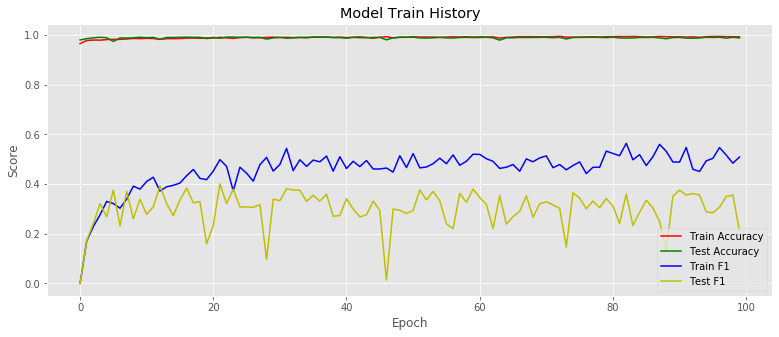

CLASSIFIER PERFORMANCE WASH DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Wash Dryer 1,98.8,92.11,43.75,59.32,79.36,0.01,0.72,3920,80



CONFUSION MATRIX (OFF/ON):

 - Wash Dryer 1:
[[3917    3]
 [  45   35]]

Training the `Microwave` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 18s - loss: 0.0719 - accuracy: 0.9815 - f1_m: 4.8485e-04 - val_loss: 0.0367 - val_accuracy: 0.9952 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 18s - loss: 0.0526 - accuracy: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0292 - val_accuracy: 0.9952 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 18s - loss: 0.0516 - accuracy: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0209 - val_accuracy: 0.9952 - val_f1_m: 0.0000e+00
Epoch 4/100
4000/4000 - 18s - loss: 0.0468 - accuracy: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0239 - val_accuracy: 0.9952 - val_f1_m: 0.0000e+00
Epoch 5/100
4000/4000 - 18s - loss: 0.0456 - accuracy: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0231 - val_accuracy: 0.9952 - val_f1_m: 0.0000e+00
Epoch 6/100
4000/4000 - 18s - loss: 0.0475 - accuracy: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0201 - val_accurac

Epoch 59/100
4000/4000 - 18s - loss: 0.0105 - accuracy: 0.9962 - f1_m: 0.2547 - val_loss: 0.0398 - val_accuracy: 0.9925 - val_f1_m: 0.0347
Epoch 60/100
4000/4000 - 18s - loss: 0.0107 - accuracy: 0.9970 - f1_m: 0.2480 - val_loss: 0.0409 - val_accuracy: 0.9905 - val_f1_m: 0.0333
Epoch 61/100
4000/4000 - 18s - loss: 0.0115 - accuracy: 0.9965 - f1_m: 0.2091 - val_loss: 0.0478 - val_accuracy: 0.9902 - val_f1_m: 0.0453
Epoch 62/100
4000/4000 - 18s - loss: 0.0133 - accuracy: 0.9967 - f1_m: 0.2187 - val_loss: 0.0333 - val_accuracy: 0.9930 - val_f1_m: 0.0360
Epoch 63/100
4000/4000 - 18s - loss: 0.0090 - accuracy: 0.9967 - f1_m: 0.2171 - val_loss: 0.0433 - val_accuracy: 0.9952 - val_f1_m: 0.0160
Epoch 64/100
4000/4000 - 18s - loss: 0.0079 - accuracy: 0.9973 - f1_m: 0.2293 - val_loss: 0.0487 - val_accuracy: 0.9895 - val_f1_m: 0.0453
Epoch 65/100
4000/4000 - 18s - loss: 0.0099 - accuracy: 0.9973 - f1_m: 0.2160 - val_loss: 0.0433 - val_accuracy: 0.9918 - val_f1_m: 0.0427
Epoch 66/100
4000/4000 - 18

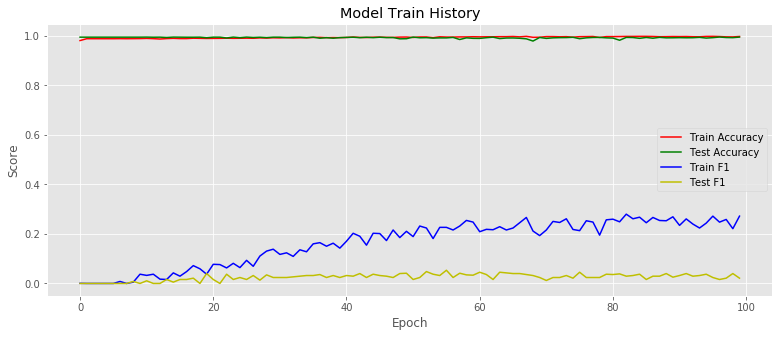

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Microwave,99.55,60.0,15.79,25.0,62.39,0.0,0.58,3981,19



CONFUSION MATRIX (OFF/ON):

 - Microwave:
[[3979    2]
 [  16    3]]



In [14]:
# Model fit...
for i in range(yb1_train.shape[1]):
    print("Training the `{}` model...\n".format(valid_appliances[i]))
    
    #model = cnn_model(output_layer_length=1)
    model = vgg_model_appliance()
    #image = preprocess_input(image)
    
    # Calibrating model..
    callback = model.fit(
        train_rp_images, yb1_train[:, i],
        validation_data=(test_rp_images, yb1_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    #classification_report(yb1_test[:, i], y_pred, labels = valid_appliances)
    classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

---> Training the `Refrigerator` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 6s - loss: 0.6719 - acc: 0.5895 - f1_m: 0.0663 - val_loss: 0.6678 - val_acc: 0.5825 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 6s - loss: 0.6483 - acc: 0.6490 - f1_m: 0.2958 - val_loss: 0.6477 - val_acc: 0.6470 - val_f1_m: 0.4128
Epoch 3/100
4000/4000 - 6s - loss: 0.6340 - acc: 0.6810 - f1_m: 0.4573 - val_loss: 0.6546 - val_acc: 0.6248 - val_f1_m: 0.4471
Epoch 4/100
4000/4000 - 6s - loss: 0.6292 - acc: 0.6858 - f1_m: 0.4683 - val_loss: 0.6406 - val_acc: 0.6450 - val_f1_m: 0.4384
Epoch 5/100
4000/4000 - 6s - loss: 0.6214 - acc: 0.6885 - f1_m: 0.4769 - val_loss: 0.6293 - val_acc: 0.6668 - val_f1_m: 0.4175
Epoch 6/100
4000/4000 - 6s - loss: 0.6220 - acc: 0.6875 - f1_m: 0.4769 - val_loss: 0.6447 - val_acc: 0.6332 - val_f1_m: 0.4673
Epoch 7/100
4000/4000 - 6s - loss: 0.6169 - acc: 0.6933 - f1_m: 0.4913 - val_loss: 0.6273 - val_acc: 0.6630 - val_f1_m: 0.4460
Epoch 8/100
4000

Epoch 65/100
4000/4000 - 6s - loss: 0.3587 - acc: 0.8430 - f1_m: 0.7980 - val_loss: 0.7981 - val_acc: 0.6313 - val_f1_m: 0.5054
Epoch 66/100
4000/4000 - 6s - loss: 0.3499 - acc: 0.8485 - f1_m: 0.8019 - val_loss: 0.8793 - val_acc: 0.6148 - val_f1_m: 0.5107
Epoch 67/100
4000/4000 - 6s - loss: 0.3459 - acc: 0.8503 - f1_m: 0.8063 - val_loss: 0.8527 - val_acc: 0.6237 - val_f1_m: 0.5116
Epoch 68/100
4000/4000 - 6s - loss: 0.3435 - acc: 0.8530 - f1_m: 0.8096 - val_loss: 0.8386 - val_acc: 0.6313 - val_f1_m: 0.5002
Epoch 69/100
4000/4000 - 6s - loss: 0.3348 - acc: 0.8530 - f1_m: 0.8102 - val_loss: 0.8913 - val_acc: 0.6087 - val_f1_m: 0.5260
Epoch 70/100
4000/4000 - 6s - loss: 0.3337 - acc: 0.8590 - f1_m: 0.8167 - val_loss: 0.8238 - val_acc: 0.6137 - val_f1_m: 0.5259
Epoch 71/100
4000/4000 - 6s - loss: 0.3300 - acc: 0.8575 - f1_m: 0.8153 - val_loss: 0.8948 - val_acc: 0.6180 - val_f1_m: 0.4823
Epoch 72/100
4000/4000 - 6s - loss: 0.3223 - acc: 0.8640 - f1_m: 0.8273 - val_loss: 0.9418 - val_acc: 0.

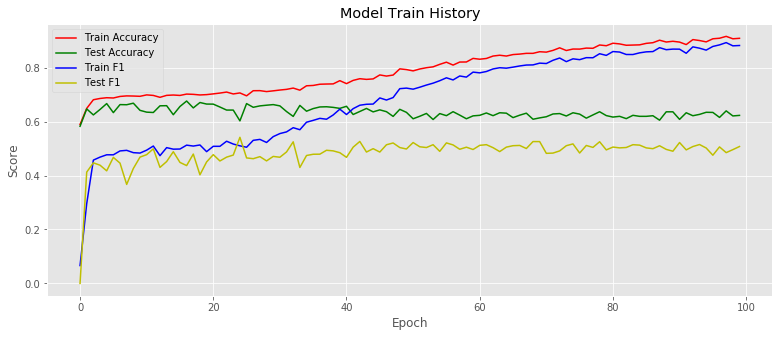

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,62.3,55.61,48.08,51.57,60.35,0.38,0.6,2330,1670



CONFUSION MATRIX (OFF/ON):

 - Refrigerator:
[[1689  641]
 [ 867  803]]

---> Training the `Dishwasher` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 6s - loss: 0.1549 - acc: 0.9747 - f1_m: 0.0000e+00 - val_loss: 0.0768 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 6s - loss: 0.1002 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0509 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 6s - loss: 0.1030 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0740 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 4/100
4000/4000 - 6s - loss: 0.0896 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0695 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 5/100
4000/4000 - 6s - loss: 0.0966 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0523 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 6/100
4000/4000 - 6s - loss: 0.0947 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0593 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 7/100
4000/4000 - 6s 

Epoch 62/100
4000/4000 - 6s - loss: 0.0174 - acc: 0.9942 - f1_m: 0.3013 - val_loss: 0.1041 - val_acc: 0.9870 - val_f1_m: 0.0160
Epoch 63/100
4000/4000 - 6s - loss: 0.0229 - acc: 0.9925 - f1_m: 0.2957 - val_loss: 0.1002 - val_acc: 0.9872 - val_f1_m: 0.0080
Epoch 64/100
4000/4000 - 6s - loss: 0.0203 - acc: 0.9935 - f1_m: 0.2720 - val_loss: 0.0960 - val_acc: 0.9825 - val_f1_m: 0.0133
Epoch 65/100
4000/4000 - 6s - loss: 0.0250 - acc: 0.9940 - f1_m: 0.3133 - val_loss: 0.1033 - val_acc: 0.9772 - val_f1_m: 0.0187
Epoch 66/100
4000/4000 - 6s - loss: 0.0170 - acc: 0.9948 - f1_m: 0.2827 - val_loss: 0.0905 - val_acc: 0.9875 - val_f1_m: 0.0080
Epoch 67/100
4000/4000 - 6s - loss: 0.0280 - acc: 0.9942 - f1_m: 0.3285 - val_loss: 0.0865 - val_acc: 0.9885 - val_f1_m: 0.0080
Epoch 68/100
4000/4000 - 6s - loss: 0.0190 - acc: 0.9945 - f1_m: 0.3304 - val_loss: 0.0879 - val_acc: 0.9872 - val_f1_m: 0.0133
Epoch 69/100
4000/4000 - 6s - loss: 0.0190 - acc: 0.9940 - f1_m: 0.3008 - val_loss: 0.0946 - val_acc: 0.

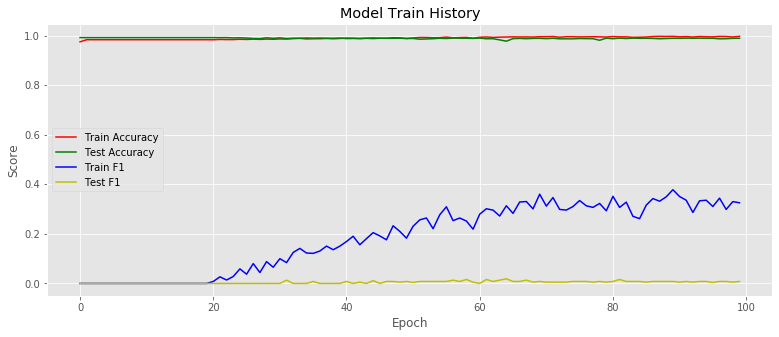

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Dishwasher,98.9,7.69,3.03,4.35,51.9,0.01,0.51,3967,33



CONFUSION MATRIX (OFF/ON):

 - Dishwasher:
[[3955   12]
 [  32    1]]

---> Training the `Furnace` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 6s - loss: 0.2635 - acc: 0.9375 - f1_m: 0.0022 - val_loss: 0.1633 - val_acc: 0.9942 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 6s - loss: 0.2269 - acc: 0.9420 - f1_m: 0.0000e+00 - val_loss: 0.1166 - val_acc: 0.9942 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 6s - loss: 0.2246 - acc: 0.9420 - f1_m: 0.0000e+00 - val_loss: 0.0753 - val_acc: 0.9942 - val_f1_m: 0.0000e+00
Epoch 4/100
4000/4000 - 6s - loss: 0.2246 - acc: 0.9420 - f1_m: 0.0000e+00 - val_loss: 0.0889 - val_acc: 0.9942 - val_f1_m: 0.0000e+00
Epoch 5/100
4000/4000 - 6s - loss: 0.2221 - acc: 0.9420 - f1_m: 0.0000e+00 - val_loss: 0.1005 - val_acc: 0.9942 - val_f1_m: 0.0000e+00
Epoch 6/100
4000/4000 - 6s - loss: 0.2196 - acc: 0.9420 - f1_m: 0.0000e+00 - val_loss: 0.0916 - val_acc: 0.9942 - val_f1_m: 0.0000e+00
Epoch 7/100
4000/4000 - 6s - loss: 0

Epoch 63/100
4000/4000 - 6s - loss: 0.0805 - acc: 0.9690 - f1_m: 0.5251 - val_loss: 0.0745 - val_acc: 0.9820 - val_f1_m: 0.0347
Epoch 64/100
4000/4000 - 6s - loss: 0.0876 - acc: 0.9690 - f1_m: 0.5196 - val_loss: 0.0948 - val_acc: 0.9745 - val_f1_m: 0.0200
Epoch 65/100
4000/4000 - 6s - loss: 0.0758 - acc: 0.9718 - f1_m: 0.5465 - val_loss: 0.1234 - val_acc: 0.9622 - val_f1_m: 0.0392
Epoch 66/100
4000/4000 - 6s - loss: 0.0824 - acc: 0.9710 - f1_m: 0.5273 - val_loss: 0.1062 - val_acc: 0.9710 - val_f1_m: 0.0365
Epoch 67/100
4000/4000 - 6s - loss: 0.0672 - acc: 0.9745 - f1_m: 0.5594 - val_loss: 0.0902 - val_acc: 0.9778 - val_f1_m: 0.0373
Epoch 68/100
4000/4000 - 6s - loss: 0.0739 - acc: 0.9725 - f1_m: 0.5121 - val_loss: 0.1191 - val_acc: 0.9638 - val_f1_m: 0.0267
Epoch 69/100
4000/4000 - 6s - loss: 0.0872 - acc: 0.9680 - f1_m: 0.4945 - val_loss: 0.0752 - val_acc: 0.9833 - val_f1_m: 0.0240
Epoch 70/100
4000/4000 - 6s - loss: 0.0719 - acc: 0.9740 - f1_m: 0.6065 - val_loss: 0.0794 - val_acc: 0.

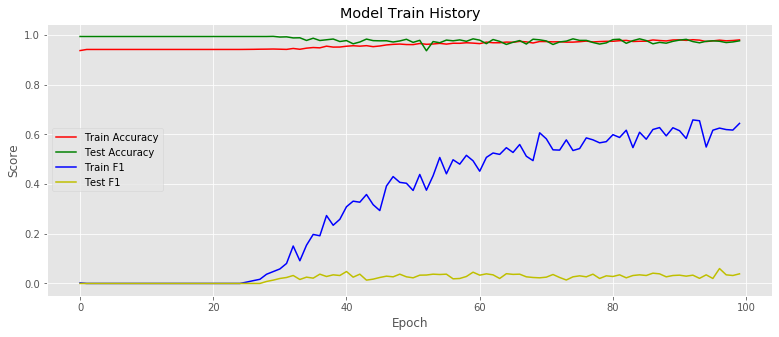

CLASSIFIER PERFORMANCE FURNACE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Furnace,97.68,7.32,26.09,11.43,55.13,0.02,0.62,3977,23



CONFUSION MATRIX (OFF/ON):

 - Furnace:
[[3901   76]
 [  17    6]]

---> Training the `Wash Dryer 1` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 6s - loss: 0.1370 - acc: 0.9693 - f1_m: 0.0000e+00 - val_loss: 0.0735 - val_acc: 0.9800 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 6s - loss: 0.0991 - acc: 0.9728 - f1_m: 0.0000e+00 - val_loss: 0.0726 - val_acc: 0.9800 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 6s - loss: 0.0959 - acc: 0.9728 - f1_m: 0.0000e+00 - val_loss: 0.0682 - val_acc: 0.9800 - val_f1_m: 0.0000e+00
Epoch 4/100
4000/4000 - 6s - loss: 0.0927 - acc: 0.9728 - f1_m: 0.0000e+00 - val_loss: 0.0556 - val_acc: 0.9800 - val_f1_m: 0.0000e+00
Epoch 5/100
4000/4000 - 6s - loss: 0.0807 - acc: 0.9728 - f1_m: 0.0000e+00 - val_loss: 0.0567 - val_acc: 0.9800 - val_f1_m: 0.0000e+00
Epoch 6/100
4000/4000 - 6s - loss: 0.0783 - acc: 0.9728 - f1_m: 0.0000e+00 - val_loss: 0.0655 - val_acc: 0.9800 - val_f1_m: 0.0000e+00
Epoch 7/100
4000/4000 - 6s - l

Epoch 64/100
4000/4000 - 6s - loss: 0.0307 - acc: 0.9898 - f1_m: 0.4057 - val_loss: 0.0475 - val_acc: 0.9885 - val_f1_m: 0.2682
Epoch 65/100
4000/4000 - 6s - loss: 0.0186 - acc: 0.9920 - f1_m: 0.4667 - val_loss: 0.0514 - val_acc: 0.9900 - val_f1_m: 0.3061
Epoch 66/100
4000/4000 - 6s - loss: 0.0166 - acc: 0.9930 - f1_m: 0.4821 - val_loss: 0.0553 - val_acc: 0.9877 - val_f1_m: 0.3187
Epoch 67/100
4000/4000 - 6s - loss: 0.0192 - acc: 0.9927 - f1_m: 0.4735 - val_loss: 0.0469 - val_acc: 0.9877 - val_f1_m: 0.3190
Epoch 68/100
4000/4000 - 6s - loss: 0.0190 - acc: 0.9923 - f1_m: 0.4263 - val_loss: 0.0527 - val_acc: 0.9900 - val_f1_m: 0.2755
Epoch 69/100
4000/4000 - 6s - loss: 0.0160 - acc: 0.9937 - f1_m: 0.4965 - val_loss: 0.0503 - val_acc: 0.9890 - val_f1_m: 0.2943
Epoch 70/100
4000/4000 - 6s - loss: 0.0195 - acc: 0.9935 - f1_m: 0.5165 - val_loss: 0.0492 - val_acc: 0.9872 - val_f1_m: 0.2950
Epoch 71/100
4000/4000 - 6s - loss: 0.0162 - acc: 0.9927 - f1_m: 0.4356 - val_loss: 0.0525 - val_acc: 0.

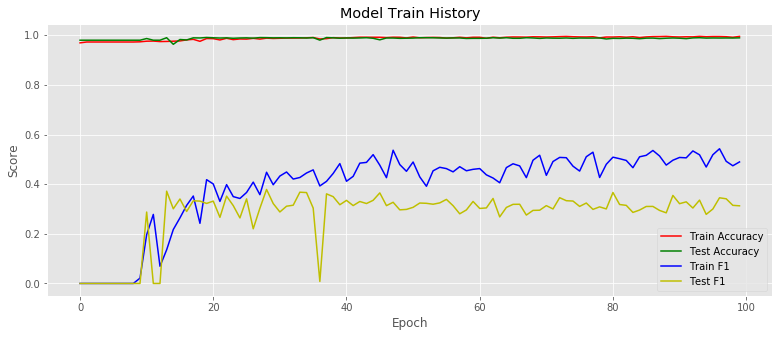

CLASSIFIER PERFORMANCE WASH DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Wash Dryer 1,98.95,77.94,66.25,71.62,85.54,0.01,0.83,3920,80



CONFUSION MATRIX (OFF/ON):

 - Wash Dryer 1:
[[3905   15]
 [  27   53]]

---> Training the `Microwave` model...

Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 6s - loss: 0.1707 - acc: 0.9868 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 4/100
4000/4000 - 6s - loss: 0.1737 - acc: 0.9885 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 5/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 6/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 7/100
4000/4000 - 6s -

Epoch 61/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 62/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 63/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 64/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 65/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 66/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 67/100
4000/4000 - 6s - loss: 0.1697 - acc: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.0733 - val_acc: 0.9952 - val_f1_m: 0.0000e+00
Epoch 68/100
4000/4000 - 6s - loss: 0.1697 - acc

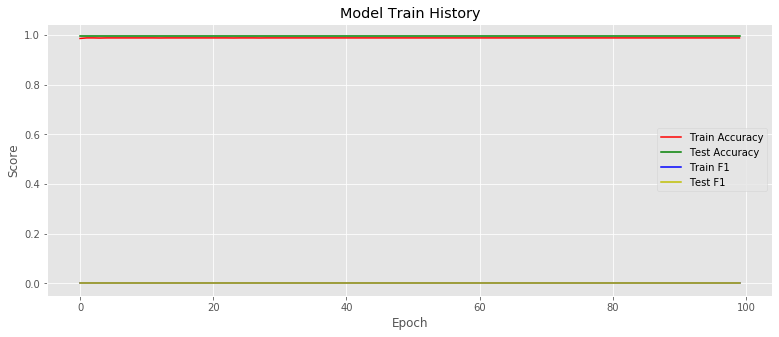

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Microwave,99.52,0.0,0.0,0.0,49.88,0.0,0.5,3981,19



CONFUSION MATRIX (OFF/ON):

 - Microwave:
[[3981    0]
 [  19    0]]



In [16]:
# Model fit...
for i in range(yb1_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = cnn_model_appliance()
    
    # Calibrating model..
    callback = model.fit(
        train_rp_images, yb1_train[:, i],
        validation_data=(test_rp_images, yb1_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

#### Balanceamento Classes

---> Training the `Refrigerator` model...

Class weights: [0.835771   1.24455507]
Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 6s - loss: 0.6697 - acc: 0.6050 - f1_m: 0.1361 - val_loss: 0.6621 - val_acc: 0.6597 - val_f1_m: 0.3727
Epoch 2/100
4000/4000 - 6s - loss: 0.6440 - acc: 0.6740 - f1_m: 0.4265 - val_loss: 0.6383 - val_acc: 0.6660 - val_f1_m: 0.4162
Epoch 3/100
4000/4000 - 6s - loss: 0.6323 - acc: 0.6873 - f1_m: 0.4663 - val_loss: 0.6398 - val_acc: 0.6615 - val_f1_m: 0.4115
Epoch 4/100
4000/4000 - 6s - loss: 0.6305 - acc: 0.6862 - f1_m: 0.4588 - val_loss: 0.6400 - val_acc: 0.6622 - val_f1_m: 0.3952
Epoch 5/100
4000/4000 - 6s - loss: 0.6245 - acc: 0.6873 - f1_m: 0.4651 - val_loss: 0.6371 - val_acc: 0.6625 - val_f1_m: 0.4021
Epoch 6/100
4000/4000 - 6s - loss: 0.6198 - acc: 0.6892 - f1_m: 0.4786 - val_loss: 0.6394 - val_acc: 0.6298 - val_f1_m: 0.5029
Epoch 7/100
4000/4000 - 6s - loss: 0.6200 - acc: 0.6965 - f1_m: 0.4920 - val_loss: 0.6373 - val_acc: 0.6653 

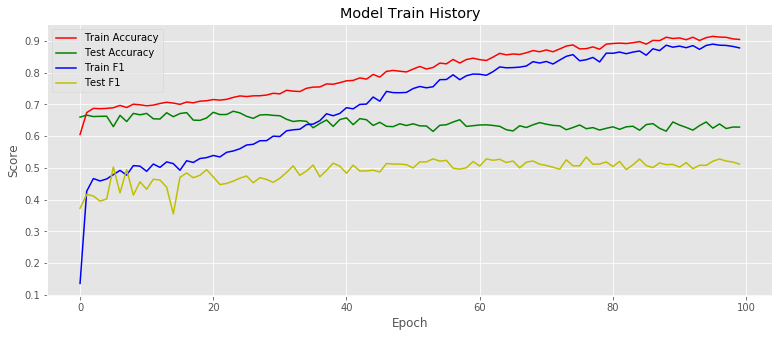

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,62.82,56.19,49.76,52.78,61.06,0.37,0.61,2330,1670



CONFUSION MATRIX (OFF/ON):

 - Refrigerator:
[[1682  648]
 [ 839  831]]

---> Training the `Dishwasher` model...

Class weights: [ 0.50851767 29.85074627]
Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 7s - loss: 0.1289 - acc: 0.9790 - f1_m: 0.0000e+00 - val_loss: 0.0693 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 6s - loss: 0.1032 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0600 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 6s - loss: 0.0979 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0482 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 4/100
4000/4000 - 6s - loss: 0.0968 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0686 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 5/100
4000/4000 - 6s - loss: 0.0941 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0512 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 6/100
4000/4000 - 6s - loss: 0.0942 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.0553 - val_acc: 0.9918 - val_f1_

KeyboardInterrupt: 

In [70]:
# CLASS WEIGHT
from sklearn.utils import class_weight

# Model fit...
for i in range(yb1_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    
    class_weights = class_weight.compute_class_weight(
        'balanced',
        np.unique(yb1_train[:, i]),
        yb1_train[:, i]
    )
    print("Class weights:", class_weights)

    model = cnn_model_appliance()
    
    # Calibrating model..
    callback = model.fit(
        train_rp_images, yb1_train[:, i],
        validation_data=(test_rp_images, yb1_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2,#, callbacks = [tqdm_callback],
        class_weight = class_weights
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")


#### Focal Loss

---> Training the `Refrigerator` model...

Class weights: [0.835771   1.24455507]
Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 7s - loss: 2.2033 - acc: 0.5972 - f1_m: 0.0256 - val_loss: 2.1165 - val_acc: 0.5825 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 6s - loss: 2.1045 - acc: 0.6037 - f1_m: 0.0447 - val_loss: 2.0829 - val_acc: 0.5990 - val_f1_m: 0.0984
Epoch 3/100
4000/4000 - 6s - loss: 2.0620 - acc: 0.6122 - f1_m: 0.0954 - val_loss: 2.0633 - val_acc: 0.6070 - val_f1_m: 0.1316
Epoch 4/100
4000/4000 - 6s - loss: 2.0622 - acc: 0.6070 - f1_m: 0.0581 - val_loss: 2.0653 - val_acc: 0.5825 - val_f1_m: 0.0000e+00
Epoch 5/100
4000/4000 - 6s - loss: 2.0280 - acc: 0.6275 - f1_m: 0.1640 - val_loss: 2.3822 - val_acc: 0.6058 - val_f1_m: 0.1275
Epoch 6/100
4000/4000 - 6s - loss: 2.0261 - acc: 0.6295 - f1_m: 0.1817 - val_loss: 2.1779 - val_acc: 0.5825 - val_f1_m: 0.0000e+00
Epoch 7/100
4000/4000 - 6s - loss: 2.0144 - acc: 0.6330 - f1_m: 0.1913 - val_loss: 2.0640 - val_

Epoch 64/100
4000/4000 - 6s - loss: 1.5709 - acc: 0.7303 - f1_m: 0.5171 - val_loss: 2.4173 - val_acc: 0.6140 - val_f1_m: 0.2226
Epoch 65/100
4000/4000 - 6s - loss: 1.5686 - acc: 0.7190 - f1_m: 0.4838 - val_loss: 2.3240 - val_acc: 0.6417 - val_f1_m: 0.3392
Epoch 66/100
4000/4000 - 6s - loss: 1.5791 - acc: 0.7268 - f1_m: 0.5116 - val_loss: 2.2921 - val_acc: 0.6187 - val_f1_m: 0.2254
Epoch 67/100
4000/4000 - 6s - loss: 1.5238 - acc: 0.7383 - f1_m: 0.5342 - val_loss: 2.3934 - val_acc: 0.6258 - val_f1_m: 0.3221
Epoch 68/100
4000/4000 - 6s - loss: 1.6130 - acc: 0.7107 - f1_m: 0.4599 - val_loss: 2.3076 - val_acc: 0.6302 - val_f1_m: 0.2945
Epoch 69/100
4000/4000 - 6s - loss: 1.5364 - acc: 0.7355 - f1_m: 0.5320 - val_loss: 2.2090 - val_acc: 0.6130 - val_f1_m: 0.1714
Epoch 70/100
4000/4000 - 6s - loss: 1.5496 - acc: 0.7253 - f1_m: 0.5039 - val_loss: 2.3805 - val_acc: 0.6105 - val_f1_m: 0.2037
Epoch 71/100
4000/4000 - 6s - loss: 1.5286 - acc: 0.7345 - f1_m: 0.5274 - val_loss: 2.4297 - val_acc: 0.

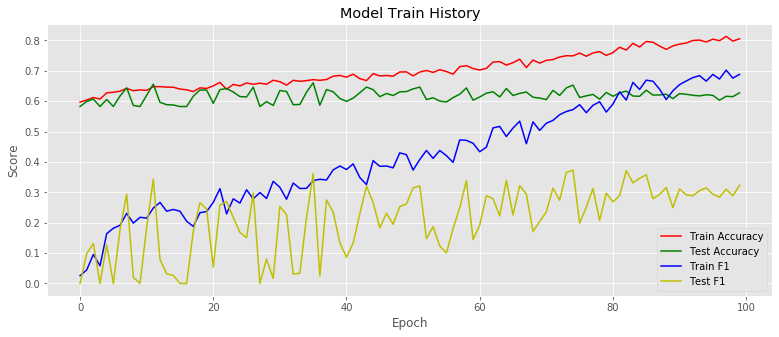

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,62.75,65.36,22.93,33.95,54.01,0.37,0.57,2330,1670



CONFUSION MATRIX (OFF/ON):

 - Refrigerator:
[[2127  203]
 [1287  383]]

---> Training the `Dishwasher` model...

Class weights: [ 0.50851767 29.85074627]
Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 - 7s - loss: 0.4807 - acc: 0.9772 - f1_m: 0.0000e+00 - val_loss: 0.1962 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 2/100
4000/4000 - 6s - loss: 0.3589 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.1526 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 3/100
4000/4000 - 6s - loss: 0.3093 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.1480 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 4/100
4000/4000 - 6s - loss: 0.3340 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.1497 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 5/100
4000/4000 - 6s - loss: 0.3100 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.1872 - val_acc: 0.9918 - val_f1_m: 0.0000e+00
Epoch 6/100
4000/4000 - 6s - loss: 0.3155 - acc: 0.9833 - f1_m: 0.0000e+00 - val_loss: 0.1493 - val_acc: 0.9918 - val_f1_

KeyboardInterrupt: 

In [73]:
# CLASS WEIGHT
from sklearn.utils import class_weight

# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tensorflow.where(tensorflow.equal(y_true, 1), y_pred, tensorflow.ones_like(y_pred))
    pt_0 = tensorflow.where(tensorflow.equal(y_true, 0), y_pred, tensorflow.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

# Model fit...
for i in range(yb1_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    
    class_weights = class_weight.compute_class_weight(
        'balanced',
        np.unique(yb1_train[:, i]),
        yb1_train[:, i]
    )
    print("Class weights:", class_weights)

    model = cnn_model_appliance(loss_function = focal_loss)
    
    # Calibrating model..
    callback = model.fit(
        train_rp_images, yb1_train[:, i],
        validation_data=(test_rp_images, yb1_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2,#, callbacks = [tqdm_callback],
        class_weight = class_weights
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")


#### Training Set Oversampling / Undersampling

In [88]:
print("Original shape:", train_rp_images.shape)
print("Reshaped:", train_rp_images.reshape(train_rp_images.shape[0], -1).shape)
print("Reshaped to original:", train_rp_images.reshape(train_rp_images.shape[0], -1).reshape(train_rp_images.shape).shape)


Original shape: (4000, 128, 128, 3)
Reshaped: (4000, 49152)
Reshaped to original: (4000, 128, 128, 3)


In [100]:
from collections import Counter
print("Original distribution (training set):", Counter(yb1_train[:, 1]))

Original distribution (training set): Counter({0: 3933, 1: 67})


In [102]:
from imblearn.over_sampling import RandomOverSampler
X_resampled, y_resampled = RandomOverSampler().fit_resample(
    train_rp_images.reshape(train_rp_images.shape[0], -1),
    yb1_train[:, 1]
)

print("New distribution (training set):", Counter(y_resampled))

New distribution (training set): Counter({0: 3933, 1: 3933})


---> Training the `Refrigerator` model...

Train on 4786 samples, validate on 4000 samples
Epoch 1/100
4786/4786 - 8s - loss: 0.6791 - acc: 0.5554 - f1_m: 0.5018 - val_loss: 0.6626 - val_acc: 0.6223 - val_f1_m: 0.4437
Epoch 2/100
4786/4786 - 6s - loss: 0.6669 - acc: 0.6126 - f1_m: 0.4744 - val_loss: 0.6697 - val_acc: 0.6360 - val_f1_m: 0.4595
Epoch 3/100
4786/4786 - 7s - loss: 0.6575 - acc: 0.6249 - f1_m: 0.4806 - val_loss: 0.6626 - val_acc: 0.6510 - val_f1_m: 0.3177
Epoch 4/100
4786/4786 - 6s - loss: 0.6480 - acc: 0.6394 - f1_m: 0.5383 - val_loss: 0.6447 - val_acc: 0.6565 - val_f1_m: 0.4511
Epoch 5/100
4786/4786 - 6s - loss: 0.6497 - acc: 0.6287 - f1_m: 0.5215 - val_loss: 0.6439 - val_acc: 0.6670 - val_f1_m: 0.4251
Epoch 6/100
4786/4786 - 6s - loss: 0.6395 - acc: 0.6446 - f1_m: 0.5439 - val_loss: 0.6339 - val_acc: 0.6747 - val_f1_m: 0.4441
Epoch 7/100
4786/4786 - 6s - loss: 0.6398 - acc: 0.6456 - f1_m: 0.5605 - val_loss: 0.6331 - val_acc: 0.6740 - val_f1_m: 0.4765
Epoch 8/100
4786/478

Epoch 65/100
4786/4786 - 6s - loss: 0.3135 - acc: 0.8728 - f1_m: 0.8704 - val_loss: 0.9811 - val_acc: 0.6047 - val_f1_m: 0.5108
Epoch 66/100
4786/4786 - 6s - loss: 0.3274 - acc: 0.8611 - f1_m: 0.8599 - val_loss: 0.9153 - val_acc: 0.6010 - val_f1_m: 0.5126
Epoch 67/100
4786/4786 - 6s - loss: 0.3106 - acc: 0.8742 - f1_m: 0.8726 - val_loss: 0.9198 - val_acc: 0.6242 - val_f1_m: 0.5002
Epoch 68/100
4786/4786 - 6s - loss: 0.2918 - acc: 0.8870 - f1_m: 0.8844 - val_loss: 0.9501 - val_acc: 0.6087 - val_f1_m: 0.5219
Epoch 69/100
4786/4786 - 6s - loss: 0.2964 - acc: 0.8776 - f1_m: 0.8763 - val_loss: 0.9828 - val_acc: 0.6085 - val_f1_m: 0.5023
Epoch 70/100
4786/4786 - 6s - loss: 0.2961 - acc: 0.8763 - f1_m: 0.8724 - val_loss: 0.9792 - val_acc: 0.5993 - val_f1_m: 0.4908
Epoch 71/100
4786/4786 - 6s - loss: 0.2954 - acc: 0.8759 - f1_m: 0.8734 - val_loss: 0.9649 - val_acc: 0.6010 - val_f1_m: 0.4958
Epoch 72/100
4786/4786 - 6s - loss: 0.2849 - acc: 0.8799 - f1_m: 0.8776 - val_loss: 1.0215 - val_acc: 0.

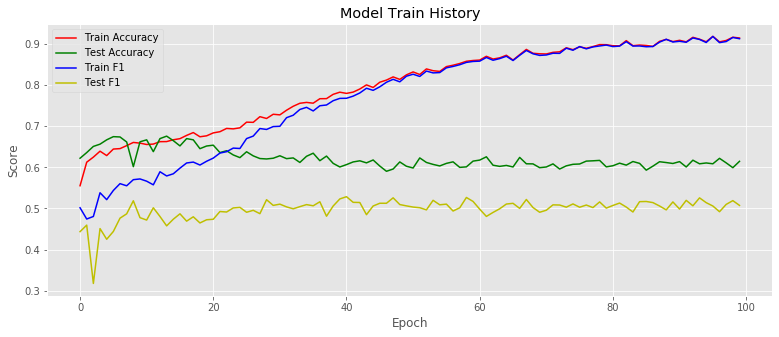

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,61.48,54.25,49.34,51.68,59.82,0.39,0.6,2330,1670



CONFUSION MATRIX (OFF/ON):

 - Refrigerator:
[[1635  695]
 [ 846  824]]

---> Training the `Dishwasher` model...

Train on 7866 samples, validate on 4000 samples
Epoch 1/100
7866/7866 - 11s - loss: 0.6416 - acc: 0.6255 - f1_m: 0.5473 - val_loss: 0.7135 - val_acc: 0.7352 - val_f1_m: 0.0134
Epoch 2/100
7866/7866 - 10s - loss: 0.5393 - acc: 0.7320 - f1_m: 0.6847 - val_loss: 0.3202 - val_acc: 0.9165 - val_f1_m: 0.0205
Epoch 3/100
7866/7866 - 10s - loss: 0.2848 - acc: 0.8875 - f1_m: 0.8832 - val_loss: 0.2276 - val_acc: 0.9038 - val_f1_m: 0.0247
Epoch 4/100
7866/7866 - 10s - loss: 0.1313 - acc: 0.9558 - f1_m: 0.9554 - val_loss: 0.2401 - val_acc: 0.9240 - val_f1_m: 0.0291
Epoch 5/100
7866/7866 - 10s - loss: 0.1005 - acc: 0.9662 - f1_m: 0.9654 - val_loss: 0.1587 - val_acc: 0.9488 - val_f1_m: 0.0147
Epoch 6/100
7866/7866 - 10s - loss: 0.0767 - acc: 0.9722 - f1_m: 0.9714 - val_loss: 0.1298 - val_acc: 0.9680 - val_f1_m: 0.0240
Epoch 7/100
7866/7866 - 10s - loss: 0.0673 - acc: 0.9781 - f1_m: 0.97

KeyboardInterrupt: 

In [114]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN

# Model fit...
for i in range(yb1_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = cnn_model_appliance()
    
    # Resampling...
    X_train_resampled, y_train_resampled = RandomOverSampler().fit_resample(
        train_rp_images.reshape(train_rp_images.shape[0], -1),
        yb1_train[:, i]
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(train_rp_images.shape[1:]))
                )
    
    # Calibrating model..
    callback = model.fit(
        X_resampled, y_resampled,
        validation_data=(test_rp_images, yb1_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    del X_resampled
    del y_resampled
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

---> Training the `Refrigerator` model...

Train on 4804 samples, validate on 4000 samples
Epoch 1/100
4804/4804 - 8s - loss: 0.6914 - acc: 0.5262 - f1_m: 0.4702 - val_loss: 0.6784 - val_acc: 0.5978 - val_f1_m: 0.5061
Epoch 2/100
4804/4804 - 6s - loss: 0.6736 - acc: 0.6016 - f1_m: 0.5742 - val_loss: 0.6709 - val_acc: 0.6008 - val_f1_m: 0.5355
Epoch 3/100
4804/4804 - 6s - loss: 0.6575 - acc: 0.6253 - f1_m: 0.5967 - val_loss: 0.6381 - val_acc: 0.6313 - val_f1_m: 0.4912
Epoch 4/100
4804/4804 - 7s - loss: 0.6474 - acc: 0.6393 - f1_m: 0.5965 - val_loss: 0.6320 - val_acc: 0.6500 - val_f1_m: 0.4935
Epoch 5/100
4804/4804 - 6s - loss: 0.6276 - acc: 0.6630 - f1_m: 0.5996 - val_loss: 0.6267 - val_acc: 0.6430 - val_f1_m: 0.5250
Epoch 6/100
4804/4804 - 6s - loss: 0.5994 - acc: 0.6880 - f1_m: 0.6436 - val_loss: 0.6196 - val_acc: 0.6655 - val_f1_m: 0.5339
Epoch 7/100
4804/4804 - 7s - loss: 0.5908 - acc: 0.6844 - f1_m: 0.6297 - val_loss: 0.6394 - val_acc: 0.6570 - val_f1_m: 0.5817
Epoch 8/100
4804/480

Epoch 65/100
4804/4804 - 7s - loss: 0.2947 - acc: 0.8732 - f1_m: 0.8700 - val_loss: 0.8281 - val_acc: 0.6300 - val_f1_m: 0.5737
Epoch 66/100
4804/4804 - 6s - loss: 0.2986 - acc: 0.8655 - f1_m: 0.8593 - val_loss: 0.9079 - val_acc: 0.6210 - val_f1_m: 0.5736
Epoch 67/100
4804/4804 - 7s - loss: 0.2824 - acc: 0.8799 - f1_m: 0.8674 - val_loss: 0.9690 - val_acc: 0.6187 - val_f1_m: 0.5830
Epoch 68/100
4804/4804 - 7s - loss: 0.2841 - acc: 0.8845 - f1_m: 0.8828 - val_loss: 0.8349 - val_acc: 0.6317 - val_f1_m: 0.5543
Epoch 69/100
4804/4804 - 7s - loss: 0.2783 - acc: 0.8838 - f1_m: 0.8789 - val_loss: 1.0828 - val_acc: 0.6150 - val_f1_m: 0.5973
Epoch 70/100
4804/4804 - 6s - loss: 0.2749 - acc: 0.8786 - f1_m: 0.8731 - val_loss: 0.8860 - val_acc: 0.6323 - val_f1_m: 0.5639
Epoch 71/100
4804/4804 - 6s - loss: 0.2624 - acc: 0.8888 - f1_m: 0.8836 - val_loss: 0.8426 - val_acc: 0.6265 - val_f1_m: 0.5650
Epoch 72/100
4804/4804 - 6s - loss: 0.2657 - acc: 0.8936 - f1_m: 0.8886 - val_loss: 0.8991 - val_acc: 0.

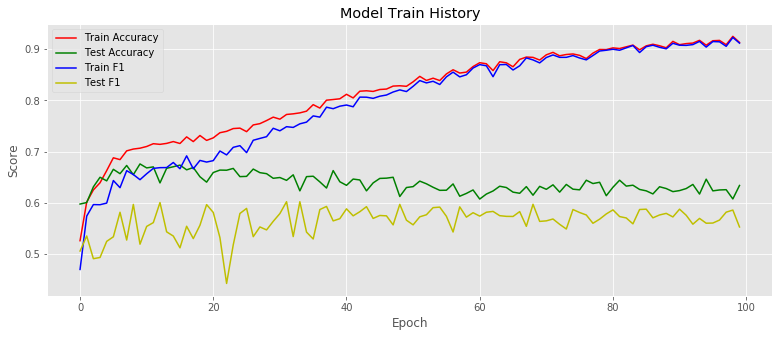

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,63.4,56.15,56.35,56.25,62.39,0.37,0.62,2330,1670



CONFUSION MATRIX (OFF/ON):

 - Refrigerator:
[[1595  735]
 [ 729  941]]

---> Training the `Dishwasher` model...



In [ ]:
# Model fit...
for i in range(yb1_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = cnn_model_appliance()
    
    # Resampling...
    X_train_resampled, y_train_resampled = ADASYN().fit_resample(
        train_rp_images.reshape(train_rp_images.shape[0], -1),
        yb1_train[:, i]
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(train_rp_images.shape[1:]))
                )
    
    # Calibrating model..
    callback = model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(test_rp_images, yb1_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    del X_train_resampled
    del y_train_resampled
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

---> Training the `Refrigerator` model...

Train on 4786 samples, validate on 3340 samples
Epoch 1/100
4786/4786 - 7s - loss: 0.6899 - acc: 0.5529 - f1_m: 0.4549 - val_loss: 0.6940 - val_acc: 0.5000 - val_f1_m: 0.6621
Epoch 2/100
4786/4786 - 6s - loss: 0.6659 - acc: 0.5967 - f1_m: 0.5405 - val_loss: 0.6526 - val_acc: 0.5937 - val_f1_m: 0.4525
Epoch 3/100
4786/4786 - 6s - loss: 0.6474 - acc: 0.6197 - f1_m: 0.4985 - val_loss: 0.6564 - val_acc: 0.5913 - val_f1_m: 0.4599
Epoch 4/100
4786/4786 - 6s - loss: 0.6438 - acc: 0.6295 - f1_m: 0.4922 - val_loss: 0.6499 - val_acc: 0.5982 - val_f1_m: 0.4970
Epoch 5/100
4786/4786 - 6s - loss: 0.6404 - acc: 0.6316 - f1_m: 0.4875 - val_loss: 0.6525 - val_acc: 0.6027 - val_f1_m: 0.4644
Epoch 6/100
4786/4786 - 6s - loss: 0.6370 - acc: 0.6281 - f1_m: 0.4874 - val_loss: 0.6485 - val_acc: 0.6024 - val_f1_m: 0.4692
Epoch 7/100
4786/4786 - 6s - loss: 0.6372 - acc: 0.6404 - f1_m: 0.5211 - val_loss: 0.6442 - val_acc: 0.6036 - val_f1_m: 0.4841
Epoch 8/100
4786/478

Epoch 65/100
4786/4786 - 6s - loss: 0.2468 - acc: 0.8978 - f1_m: 0.8956 - val_loss: 1.1547 - val_acc: 0.5985 - val_f1_m: 0.5399
Epoch 66/100
4786/4786 - 6s - loss: 0.2709 - acc: 0.8918 - f1_m: 0.8867 - val_loss: 0.9780 - val_acc: 0.6000 - val_f1_m: 0.5567
Epoch 67/100
4786/4786 - 6s - loss: 0.2392 - acc: 0.9012 - f1_m: 0.8991 - val_loss: 1.2906 - val_acc: 0.6012 - val_f1_m: 0.5098
Epoch 68/100
4786/4786 - 6s - loss: 0.2534 - acc: 0.8985 - f1_m: 0.8964 - val_loss: 1.0869 - val_acc: 0.5901 - val_f1_m: 0.5561
Epoch 69/100
4786/4786 - 6s - loss: 0.2435 - acc: 0.9012 - f1_m: 0.9011 - val_loss: 1.1125 - val_acc: 0.5877 - val_f1_m: 0.5674
Epoch 70/100
4786/4786 - 6s - loss: 0.2527 - acc: 0.8978 - f1_m: 0.8959 - val_loss: 1.0604 - val_acc: 0.6033 - val_f1_m: 0.5565
Epoch 71/100
4786/4786 - 6s - loss: 0.2403 - acc: 0.9033 - f1_m: 0.9013 - val_loss: 1.0597 - val_acc: 0.6048 - val_f1_m: 0.5720
Epoch 72/100
4786/4786 - 6s - loss: 0.2328 - acc: 0.9070 - f1_m: 0.9054 - val_loss: 1.0655 - val_acc: 0.

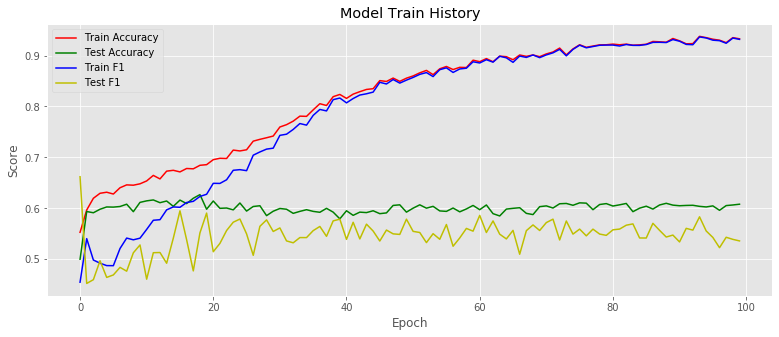

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,60.81,64.81,47.31,54.69,60.08,0.39,0.61,1670,1670



CONFUSION MATRIX (OFF/ON):

 - Refrigerator:
[[1241  429]
 [ 880  790]]

---> Training the `Dishwasher` model...

Train on 7866 samples, validate on 66 samples
Epoch 1/100
7866/7866 - 9s - loss: 0.6480 - acc: 0.6199 - f1_m: 0.5704 - val_loss: 0.6774 - val_acc: 0.5303 - val_f1_m: 0.2200
Epoch 2/100
7866/7866 - 8s - loss: 0.5175 - acc: 0.7538 - f1_m: 0.7289 - val_loss: 0.7701 - val_acc: 0.5455 - val_f1_m: 0.1905
Epoch 3/100
7866/7866 - 8s - loss: 0.2822 - acc: 0.8875 - f1_m: 0.8850 - val_loss: 2.4227 - val_acc: 0.5606 - val_f1_m: 0.3977
Epoch 4/100
7866/7866 - 8s - loss: 0.1174 - acc: 0.9633 - f1_m: 0.9623 - val_loss: 3.2305 - val_acc: 0.5909 - val_f1_m: 0.2083
Epoch 5/100
7866/7866 - 8s - loss: 0.0814 - acc: 0.9744 - f1_m: 0.9738 - val_loss: 4.0043 - val_acc: 0.5909 - val_f1_m: 0.1932
Epoch 6/100
7866/7866 - 8s - loss: 0.0655 - acc: 0.9781 - f1_m: 0.9785 - val_loss: 3.9954 - val_acc: 0.5758 - val_f1_m: 0.1742
Epoch 7/100
7866/7866 - 8s - loss: 0.0661 - acc: 0.9781 - f1_m: 0.9777 - val_

Epoch 64/100
7866/7866 - 8s - loss: 0.0191 - acc: 0.9944 - f1_m: 0.9941 - val_loss: 6.2633 - val_acc: 0.5303 - val_f1_m: 0.2593
Epoch 65/100
7866/7866 - 8s - loss: 0.0168 - acc: 0.9947 - f1_m: 0.9945 - val_loss: 6.8143 - val_acc: 0.5152 - val_f1_m: 0.0392
Epoch 66/100
7866/7866 - 8s - loss: 0.0168 - acc: 0.9954 - f1_m: 0.9949 - val_loss: 6.6753 - val_acc: 0.5000 - val_f1_m: 0.0000e+00
Epoch 67/100
7866/7866 - 8s - loss: 0.0083 - acc: 0.9975 - f1_m: 0.9973 - val_loss: 6.9240 - val_acc: 0.5152 - val_f1_m: 0.0303
Epoch 68/100
7866/7866 - 8s - loss: 0.0142 - acc: 0.9961 - f1_m: 0.9959 - val_loss: 6.0453 - val_acc: 0.5152 - val_f1_m: 0.0392
Epoch 69/100


KeyboardInterrupt: 

In [120]:
from imblearn.under_sampling import RandomUnderSampler

# Model fit...
for i in range(yb1_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = cnn_model_appliance()
    
    # Resampling...
    X_train_resampled, y_train_resampled = ADASYN().fit_resample(
        train_rp_images.reshape(train_rp_images.shape[0], -1),
        yb1_train[:, i]
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(train_rp_images.shape[1:]))
                )
    X_test_resampled, y_test_resampled = RandomUnderSampler().fit_resample(
        test_rp_images.reshape(test_rp_images.shape[0], -1),
        yb1_test[:, i]
    )
    X_test_resampled = X_test_resampled.reshape(
                    tuple(list([-1]) + list(test_rp_images.shape[1:]))
                )
    
    # Calibrating model..
    callback = model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_test_resampled, y_test_resampled), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test_resampled).round())
    classification_report_appliance(y_test_resampled, y_pred, label = valid_appliances[i])
    
    print("")
    
    del X_train_resampled
    del y_train_resampled
    del X_test_resampled
    del y_test_resampled

# Análise Adicional dos Dados

In [60]:
yb1_train.shape

(4000, 5)

In [66]:
for i, appliance in enumerate(valid_appliances):
    y_i = yb1_train[:, i]
    supp_0 = y_i[y_i==0].shape[0]
    supp_1 = y_i[y_i==1].shape[0]
    print(appliance, 
          "-> Suport OFF (y=0):", supp_0, "({}%)".format( round((supp_0/yb1_train.shape[0])*100,2) ),
          "/ Support ON (y=1):", supp_1, "({}%)".format( round((supp_1/yb1_train.shape[0])*100,2) ),
          "\n"
         )


Refrigerator -> Suport OFF (y=0): 2393 (59.82%) / Support ON (y=1): 1607 (40.17%) 

Dishwasher -> Suport OFF (y=0): 3933 (98.32%) / Support ON (y=1): 67 (1.68%) 

Furnace -> Suport OFF (y=0): 3768 (94.2%) / Support ON (y=1): 232 (5.8%) 

Wash Dryer 1 -> Suport OFF (y=0): 3891 (97.28%) / Support ON (y=1): 109 (2.73%) 

Microwave -> Suport OFF (y=0): 3956 (98.9%) / Support ON (y=1): 44 (1.1%) 



# Data Augmentation

In [74]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = batch_size
        self._shape = x.shape        
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(
            x.reshape(x.shape[0], -1), y, 
            sampler=RandomOverSampler(), 
            batch_size=self.batch_size, 
            keep_sparse=True
        )

    def __len__(self):
        return self._shape[0] // self.batch_size

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()
    
# x, y = ... # load your data
# datagen = ImageDataGenerator()
# balanced_gen = BalancedDataGenerator(x, y, datagen, batch_size=32)
# steps_per_epoch = balanced_gen.steps_per_epoch

# model = ... # define your model
# model.compile(...) # define your compile parameters
# model.fit_generator(balanced_gen, steps_per_epoch, ...)

In [ ]:
RecurrencePlot().fit_transform(tra)

In [55]:
# datagen = ImageDataGenerator()

# steps_per_epoch = balanced_gen.steps_per_epoch

from imblearn.keras import BalancedBatchGenerator
# >>> from imblearn.under_sampling import NearMiss
# >>> training_generator = BalancedBatchGenerator(
# ...     X, y, sampler=NearMiss(), batch_size=10, random_state=42)
# >>> callback_history = model.fit_generator(generator=training_generator,
# ...                                        epochs=10, verbose=0)


balanced_gen = BalancedBatchGenerator(
    train_rp_images, 
    yb1_train[:, 1], 
    sampler=RandomOverSampler(), 
    batch_size=32,
    random_state = 33
)

model = cnn_model_appliance()
# Calibrating model..
callback = model.fit_generator(
    balanced_gen, 
    steps_per_epoch, 
    epochs = 100, 
    verbose = 2, 
    use_multiprocessing = True,
    workers = 6
)

# # Calibrating model..
# callback = model.fit_generator(
#     BalancedDataGenerator(
#         train_rp_images, 
#         yb1_train[:, 1], # Applaicne 1
#         ImageDataGenerator(), 
#         batch_size=32
#     ), 
#     epochs=100,
#     verbose = 2#, callbacks = [tqdm_callback]
# )  

ValueError: Found array with dim 3. Estimator expected <= 2.

In [52]:
X_ = RecurrencePlot().fit_transform(np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/train_power_chunks.npy') ))

In [57]:
for x in X:
    print(x.reshape((1,) + x.shape).shape)
    break

(1, 30, 30)


In [54]:
from sklearn.datasets import load_iris
iris = load_iris()
from imblearn.datasets import make_imbalance
class_dict = dict()
class_dict[0] = 30; class_dict[1] = 50; class_dict[2] = 40
X, y = make_imbalance(iris.data, iris.target, class_dict)
X = X_
import tensorflow.keras as keras
y = keras.utils.to_categorical(y, 3)
model = keras.models.Sequential()
model.add(keras.layers.Dense(y.shape[1], input_dim=X.shape[1],
                              activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy',
               metrics=['accuracy'])
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import NearMiss
training_generator = BalancedBatchGenerator(
     X, y, sampler=RandomOverSampler(), batch_size=10, random_state=42)
callback_history = model.fit_generator(generator=training_generator,
                                        epochs=10, verbose=0)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [47]:
X.shape

(120, 4)

In [ ]:
# Model fit...
for i in range(yb1_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = cnn_model_appliance()
    
    # Calibrating model..
    callback = model.fit(
        train_rp_images, yb1_train[:, i],
        validation_data=(test_rp_images, yb1_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
del train_gaf_images
del test_gaf_images
del train_rp_images
del test_rp_images
del power_chunks

# Conclusões

A utilização de RPs para a classificação multirótulo de cargas, seja utilizando classificadores tradicionais ou DL, demonstra os melhores resultados considerando **Acurácia e F1**.

Para continuidade dos estudos, vamos avaliar a estratégia de construir classificadores especialistas (binários) para cada carga, utilizando modelos baseado em DL (CNN - e CapsNet, se possível), considerando tanto GAF quanto RPs.